# Cart Pole with neural function approximator

This code is based on:

https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb

In [1]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

In [3]:
test_episodes = 10
for _ in range(test_episodes):
    R = 0
    state = env.reset()  # environment starts in a random state, cart and pole are moving
    print("initial state:", state)
    while True:  # environment sets "done" to true after 200 steps 
        env.render()
        state, reward, done, info = env.step(env.action_space.sample()) # take a random action
        R += reward
        if done:
            print("return: ", R)
            env.reset()
            break

initial state: [ 0.04795208  0.01500633 -0.03702428 -0.01847812]
return:  12.0
initial state: [ 0.03170529 -0.02898545  0.00668258  0.02149798]
return:  12.0
initial state: [-0.02044873 -0.04026811  0.0009217   0.0064254 ]
return:  16.0
initial state: [ 0.03979829 -0.00058986  0.03343772 -0.03936687]
return:  17.0
initial state: [-0.0486449   0.02907453  0.03842453  0.00331445]
return:  15.0
initial state: [ 0.01100642  0.01033727 -0.04447482  0.04318801]
return:  47.0
initial state: [ 0.02079233 -0.01441534 -0.04831256 -0.03573594]
return:  11.0
initial state: [-0.0039576   0.04866464 -0.04605637  0.04014986]
return:  25.0
initial state: [ 0.03605504 -0.02224002  0.01019457 -0.01588433]
return:  18.0
initial state: [-0.03902349  0.04328185 -0.04042662 -0.00368995]
return:  19.0


In [5]:
env.close()  # closes the visualization window

In [14]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # State inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            
            ## One hidden level model
            # Hidden layers with non-linear activation functions
            self.fc1 = tf.layers.dense(self.inputs_, hidden_size, 
                                       activation=tf.nn.relu, use_bias=True)

            # Linear output layer
            self.output = tf.layers.dense(self.fc1, action_size, 
                                                    activation=None, use_bias=True)          
            
            ## Two hidden level model 
#             # Hidden layers with non-linear activation functions
#             self.fc1 = tf.layers.dense(self.inputs_, hidden_size, 
#                                        activation=tf.nn.relu, use_bias=True)
#             self.fc2 = tf.layers.dense(self.fc1, hidden_size, 
#                                        activation=tf.nn.relu, use_bias=True)

#             # Linear output layer
#             self.output = tf.layers.dense(self.fc2, action_size, 
#                                                     activation=None, use_bias=True)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [7]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [8]:
## Those parameters are the ones used in my last experiment
train_episodes = 2000           # max number of episodes to learn from
max_steps = 500                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 100               # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [9]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

In [65]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [66]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(train_episodes):
        total_reward = 0
        t = 0
        env.reset()
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
           
            if done:
                # Episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network           
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 0 Total reward: 41.0 Training loss: 1.1503 Explore P: 0.9959
Episode: 1 Total reward: 11.0 Training loss: 1.1581 Explore P: 0.9949
Episode: 2 Total reward: 15.0 Training loss: 1.1169 Explore P: 0.9934
Episode: 3 Total reward: 15.0 Training loss: 1.1014 Explore P: 0.9919
Episode: 4 Total reward: 22.0 Training loss: 1.1233 Explore P: 0.9898
Episode: 5 Total reward: 12.0 Training loss: 1.0940 Explore P: 0.9886
Episode: 6 Total reward: 17.0 Training loss: 1.1159 Explore P: 0.9869
Episode: 7 Total reward: 46.0 Training loss: 1.0034 Explore P: 0.9824
Episode: 8 Total reward: 13.0 Training loss: 1.0622 Explore P: 0.9812
Episode: 9 Total reward: 25.0 Training loss: 1.0315 Explore P: 0.9787
Episode: 10 Total reward: 13.0 Training loss: 1.0728 Explore P: 0.9775
Episode: 11 Total reward: 13.0 Training loss: 1.0898 Explore P: 0.9762
Episode: 12 Total reward: 34.0 Training loss: 1.0937 Explore P: 0.9730
Episode: 13 Total reward: 13.0 Training loss: 1.2206 Explore P: 0.9717
Episode: 14 Tota

Episode: 117 Total reward: 24.0 Training loss: 14.7335 Explore P: 0.7850
Episode: 118 Total reward: 10.0 Training loss: 15.8953 Explore P: 0.7843
Episode: 119 Total reward: 53.0 Training loss: 4.6430 Explore P: 0.7802
Episode: 120 Total reward: 31.0 Training loss: 19.1102 Explore P: 0.7778
Episode: 121 Total reward: 35.0 Training loss: 12.2774 Explore P: 0.7751
Episode: 122 Total reward: 27.0 Training loss: 11.1056 Explore P: 0.7730
Episode: 123 Total reward: 86.0 Training loss: 7.1856 Explore P: 0.7665
Episode: 124 Total reward: 13.0 Training loss: 22.6356 Explore P: 0.7655
Episode: 125 Total reward: 14.0 Training loss: 11.4062 Explore P: 0.7645
Episode: 126 Total reward: 29.0 Training loss: 14.6658 Explore P: 0.7623
Episode: 127 Total reward: 21.0 Training loss: 13.3910 Explore P: 0.7607
Episode: 128 Total reward: 18.0 Training loss: 12.0237 Explore P: 0.7593
Episode: 129 Total reward: 36.0 Training loss: 14.0278 Explore P: 0.7567
Episode: 130 Total reward: 31.0 Training loss: 16.874

Episode: 229 Total reward: 200.0 Training loss: 118.7320 Explore P: 0.3577
Episode: 230 Total reward: 200.0 Training loss: 47.7288 Explore P: 0.3508
Episode: 231 Total reward: 180.0 Training loss: 19.7101 Explore P: 0.3448
Episode: 232 Total reward: 200.0 Training loss: 53.4916 Explore P: 0.3381
Episode: 233 Total reward: 73.0 Training loss: 114.3990 Explore P: 0.3357
Episode: 234 Total reward: 200.0 Training loss: 102.8069 Explore P: 0.3293
Episode: 235 Total reward: 200.0 Training loss: 119.6696 Explore P: 0.3230
Episode: 236 Total reward: 200.0 Training loss: 37.7492 Explore P: 0.3168
Episode: 237 Total reward: 200.0 Training loss: 51.7409 Explore P: 0.3107
Episode: 238 Total reward: 200.0 Training loss: 74.7625 Explore P: 0.3047
Episode: 239 Total reward: 200.0 Training loss: 7.6058 Explore P: 0.2989
Episode: 240 Total reward: 200.0 Training loss: 1.6872 Explore P: 0.2932
Episode: 241 Total reward: 200.0 Training loss: 65.6693 Explore P: 0.2876
Episode: 242 Total reward: 200.0 Trai

Episode: 341 Total reward: 119.0 Training loss: 63.3374 Explore P: 0.0589
Episode: 342 Total reward: 120.0 Training loss: 62.7327 Explore P: 0.0584
Episode: 343 Total reward: 144.0 Training loss: 0.2097 Explore P: 0.0577
Episode: 344 Total reward: 188.0 Training loss: 14.9251 Explore P: 0.0568
Episode: 345 Total reward: 123.0 Training loss: 18.3312 Explore P: 0.0562
Episode: 346 Total reward: 126.0 Training loss: 25.6789 Explore P: 0.0556
Episode: 347 Total reward: 145.0 Training loss: 0.1217 Explore P: 0.0550
Episode: 348 Total reward: 100.0 Training loss: 2.3140 Explore P: 0.0545
Episode: 349 Total reward: 102.0 Training loss: 77.7323 Explore P: 0.0541
Episode: 350 Total reward: 111.0 Training loss: 17.6593 Explore P: 0.0536
Episode: 351 Total reward: 89.0 Training loss: 69.7425 Explore P: 0.0532
Episode: 352 Total reward: 158.0 Training loss: 18.5750 Explore P: 0.0525
Episode: 353 Total reward: 117.0 Training loss: 20.3691 Explore P: 0.0520
Episode: 354 Total reward: 91.0 Training l

Episode: 453 Total reward: 200.0 Training loss: 0.1910 Explore P: 0.0174
Episode: 454 Total reward: 200.0 Training loss: 41.0751 Explore P: 0.0172
Episode: 455 Total reward: 200.0 Training loss: 0.1526 Explore P: 0.0171
Episode: 456 Total reward: 200.0 Training loss: 0.1733 Explore P: 0.0169
Episode: 457 Total reward: 200.0 Training loss: 0.2638 Explore P: 0.0168
Episode: 458 Total reward: 200.0 Training loss: 0.2200 Explore P: 0.0167
Episode: 459 Total reward: 200.0 Training loss: 0.2313 Explore P: 0.0165
Episode: 460 Total reward: 200.0 Training loss: 0.2237 Explore P: 0.0164
Episode: 461 Total reward: 200.0 Training loss: 0.2190 Explore P: 0.0163
Episode: 462 Total reward: 200.0 Training loss: 46.2517 Explore P: 0.0162
Episode: 463 Total reward: 200.0 Training loss: 0.2736 Explore P: 0.0160
Episode: 464 Total reward: 200.0 Training loss: 0.1886 Explore P: 0.0159
Episode: 465 Total reward: 200.0 Training loss: 0.2830 Explore P: 0.0158
Episode: 466 Total reward: 200.0 Training loss: 9

Episode: 566 Total reward: 63.0 Training loss: 167.8007 Explore P: 0.0113
Episode: 567 Total reward: 117.0 Training loss: 1.4066 Explore P: 0.0113
Episode: 568 Total reward: 200.0 Training loss: 61.8580 Explore P: 0.0113
Episode: 569 Total reward: 200.0 Training loss: 69.9268 Explore P: 0.0112
Episode: 570 Total reward: 200.0 Training loss: 221.2652 Explore P: 0.0112
Episode: 571 Total reward: 200.0 Training loss: 6.3116 Explore P: 0.0112
Episode: 572 Total reward: 200.0 Training loss: 4.3703 Explore P: 0.0112
Episode: 573 Total reward: 200.0 Training loss: 25.5375 Explore P: 0.0111
Episode: 574 Total reward: 200.0 Training loss: 3.4913 Explore P: 0.0111
Episode: 575 Total reward: 200.0 Training loss: 35.0535 Explore P: 0.0111
Episode: 576 Total reward: 200.0 Training loss: 135.2348 Explore P: 0.0111
Episode: 577 Total reward: 200.0 Training loss: 52.0782 Explore P: 0.0110
Episode: 578 Total reward: 200.0 Training loss: 54.5090 Explore P: 0.0110
Episode: 579 Total reward: 200.0 Trainin

Episode: 678 Total reward: 200.0 Training loss: 0.2330 Explore P: 0.0101
Episode: 679 Total reward: 200.0 Training loss: 0.2683 Explore P: 0.0101
Episode: 680 Total reward: 200.0 Training loss: 0.3090 Explore P: 0.0101
Episode: 681 Total reward: 200.0 Training loss: 0.2332 Explore P: 0.0101
Episode: 682 Total reward: 200.0 Training loss: 50.3686 Explore P: 0.0101
Episode: 683 Total reward: 200.0 Training loss: 53.8585 Explore P: 0.0101
Episode: 684 Total reward: 200.0 Training loss: 1.5435 Explore P: 0.0101
Episode: 685 Total reward: 200.0 Training loss: 58.7154 Explore P: 0.0101
Episode: 686 Total reward: 200.0 Training loss: 50.4259 Explore P: 0.0101
Episode: 687 Total reward: 200.0 Training loss: 0.3679 Explore P: 0.0101
Episode: 688 Total reward: 200.0 Training loss: 46.9058 Explore P: 0.0101
Episode: 689 Total reward: 200.0 Training loss: 50.3614 Explore P: 0.0101
Episode: 690 Total reward: 200.0 Training loss: 94.8651 Explore P: 0.0101
Episode: 691 Total reward: 200.0 Training lo

Episode: 790 Total reward: 200.0 Training loss: 0.0763 Explore P: 0.0100
Episode: 791 Total reward: 200.0 Training loss: 11.2949 Explore P: 0.0100
Episode: 792 Total reward: 200.0 Training loss: 11.8405 Explore P: 0.0100
Episode: 793 Total reward: 200.0 Training loss: 15.6362 Explore P: 0.0100
Episode: 794 Total reward: 200.0 Training loss: 31.6676 Explore P: 0.0100
Episode: 795 Total reward: 200.0 Training loss: 29.4003 Explore P: 0.0100
Episode: 796 Total reward: 200.0 Training loss: 0.0573 Explore P: 0.0100
Episode: 797 Total reward: 200.0 Training loss: 57.2306 Explore P: 0.0100
Episode: 798 Total reward: 200.0 Training loss: 56.2759 Explore P: 0.0100
Episode: 799 Total reward: 200.0 Training loss: 105.0594 Explore P: 0.0100
Episode: 800 Total reward: 200.0 Training loss: 0.0652 Explore P: 0.0100
Episode: 801 Total reward: 200.0 Training loss: 42.2745 Explore P: 0.0100
Episode: 802 Total reward: 200.0 Training loss: 41.2892 Explore P: 0.0100
Episode: 803 Total reward: 200.0 Trainin

Episode: 903 Total reward: 198.0 Training loss: 1.5545 Explore P: 0.0100
Episode: 904 Total reward: 200.0 Training loss: 77.1633 Explore P: 0.0100
Episode: 905 Total reward: 200.0 Training loss: 87.2514 Explore P: 0.0100
Episode: 906 Total reward: 200.0 Training loss: 49.2089 Explore P: 0.0100
Episode: 907 Total reward: 200.0 Training loss: 0.6886 Explore P: 0.0100
Episode: 908 Total reward: 96.0 Training loss: 328.2034 Explore P: 0.0100
Episode: 909 Total reward: 111.0 Training loss: 238.7206 Explore P: 0.0100
Episode: 910 Total reward: 115.0 Training loss: 71.3232 Explore P: 0.0100
Episode: 911 Total reward: 122.0 Training loss: 0.6454 Explore P: 0.0100
Episode: 912 Total reward: 75.0 Training loss: 148.5470 Explore P: 0.0100
Episode: 913 Total reward: 101.0 Training loss: 9.6329 Explore P: 0.0100
Episode: 914 Total reward: 109.0 Training loss: 4.5448 Explore P: 0.0100
Episode: 915 Total reward: 121.0 Training loss: 7.3122 Explore P: 0.0100
Episode: 916 Total reward: 70.0 Training lo

Episode: 1015 Total reward: 167.0 Training loss: 17.3918 Explore P: 0.0100
Episode: 1016 Total reward: 170.0 Training loss: 50.3604 Explore P: 0.0100
Episode: 1017 Total reward: 178.0 Training loss: 46.9053 Explore P: 0.0100
Episode: 1018 Total reward: 171.0 Training loss: 43.1691 Explore P: 0.0100
Episode: 1019 Total reward: 171.0 Training loss: 41.8739 Explore P: 0.0100
Episode: 1020 Total reward: 198.0 Training loss: 0.1034 Explore P: 0.0100
Episode: 1021 Total reward: 172.0 Training loss: 42.5050 Explore P: 0.0100
Episode: 1022 Total reward: 186.0 Training loss: 39.9783 Explore P: 0.0100
Episode: 1023 Total reward: 148.0 Training loss: 40.4708 Explore P: 0.0100
Episode: 1024 Total reward: 194.0 Training loss: 21.8781 Explore P: 0.0100
Episode: 1025 Total reward: 199.0 Training loss: 39.2061 Explore P: 0.0100
Episode: 1026 Total reward: 198.0 Training loss: 36.2280 Explore P: 0.0100
Episode: 1027 Total reward: 156.0 Training loss: 0.0787 Explore P: 0.0100
Episode: 1028 Total reward:

Episode: 1125 Total reward: 200.0 Training loss: 0.1154 Explore P: 0.0100
Episode: 1126 Total reward: 200.0 Training loss: 0.1188 Explore P: 0.0100
Episode: 1127 Total reward: 200.0 Training loss: 0.1834 Explore P: 0.0100
Episode: 1128 Total reward: 200.0 Training loss: 0.1359 Explore P: 0.0100
Episode: 1129 Total reward: 200.0 Training loss: 54.1946 Explore P: 0.0100
Episode: 1130 Total reward: 200.0 Training loss: 11.0559 Explore P: 0.0100
Episode: 1131 Total reward: 200.0 Training loss: 56.2343 Explore P: 0.0100
Episode: 1132 Total reward: 200.0 Training loss: 132.9975 Explore P: 0.0100
Episode: 1133 Total reward: 200.0 Training loss: 0.1480 Explore P: 0.0100
Episode: 1134 Total reward: 200.0 Training loss: 3.0089 Explore P: 0.0100
Episode: 1135 Total reward: 200.0 Training loss: 8.5148 Explore P: 0.0100
Episode: 1136 Total reward: 200.0 Training loss: 0.1204 Explore P: 0.0100
Episode: 1137 Total reward: 200.0 Training loss: 0.1074 Explore P: 0.0100
Episode: 1138 Total reward: 199.0

Episode: 1235 Total reward: 182.0 Training loss: 43.8428 Explore P: 0.0100
Episode: 1236 Total reward: 191.0 Training loss: 0.0078 Explore P: 0.0100
Episode: 1237 Total reward: 188.0 Training loss: 23.0343 Explore P: 0.0100
Episode: 1238 Total reward: 174.0 Training loss: 20.7833 Explore P: 0.0100
Episode: 1239 Total reward: 200.0 Training loss: 0.0414 Explore P: 0.0100
Episode: 1240 Total reward: 200.0 Training loss: 22.0356 Explore P: 0.0100
Episode: 1241 Total reward: 191.0 Training loss: 41.6832 Explore P: 0.0100
Episode: 1242 Total reward: 200.0 Training loss: 21.6151 Explore P: 0.0100
Episode: 1243 Total reward: 200.0 Training loss: 21.9468 Explore P: 0.0100
Episode: 1244 Total reward: 170.0 Training loss: 0.0453 Explore P: 0.0100
Episode: 1245 Total reward: 166.0 Training loss: 70.2168 Explore P: 0.0100
Episode: 1246 Total reward: 166.0 Training loss: 21.3274 Explore P: 0.0100
Episode: 1247 Total reward: 180.0 Training loss: 41.1563 Explore P: 0.0100
Episode: 1248 Total reward: 

Episode: 1345 Total reward: 183.0 Training loss: 23.7118 Explore P: 0.0100
Episode: 1346 Total reward: 200.0 Training loss: 0.0401 Explore P: 0.0100
Episode: 1347 Total reward: 196.0 Training loss: 23.0152 Explore P: 0.0100
Episode: 1348 Total reward: 200.0 Training loss: 40.5954 Explore P: 0.0100
Episode: 1349 Total reward: 200.0 Training loss: 24.3572 Explore P: 0.0100
Episode: 1350 Total reward: 191.0 Training loss: 86.7507 Explore P: 0.0100
Episode: 1351 Total reward: 188.0 Training loss: 22.3629 Explore P: 0.0100
Episode: 1352 Total reward: 198.0 Training loss: 20.4116 Explore P: 0.0100
Episode: 1353 Total reward: 200.0 Training loss: 0.0488 Explore P: 0.0100
Episode: 1354 Total reward: 195.0 Training loss: 20.6854 Explore P: 0.0100
Episode: 1355 Total reward: 200.0 Training loss: 0.0107 Explore P: 0.0100
Episode: 1356 Total reward: 200.0 Training loss: 0.0216 Explore P: 0.0100
Episode: 1357 Total reward: 200.0 Training loss: 17.3181 Explore P: 0.0100
Episode: 1358 Total reward: 2

Episode: 1455 Total reward: 200.0 Training loss: 28.9878 Explore P: 0.0100
Episode: 1456 Total reward: 200.0 Training loss: 46.4609 Explore P: 0.0100
Episode: 1457 Total reward: 200.0 Training loss: 98.0733 Explore P: 0.0100
Episode: 1458 Total reward: 200.0 Training loss: 3.1934 Explore P: 0.0100
Episode: 1459 Total reward: 200.0 Training loss: 3.5360 Explore P: 0.0100
Episode: 1460 Total reward: 200.0 Training loss: 0.0801 Explore P: 0.0100
Episode: 1461 Total reward: 200.0 Training loss: 34.0727 Explore P: 0.0100
Episode: 1462 Total reward: 200.0 Training loss: 0.0777 Explore P: 0.0100
Episode: 1463 Total reward: 200.0 Training loss: 37.5079 Explore P: 0.0100
Episode: 1464 Total reward: 200.0 Training loss: 0.0713 Explore P: 0.0100
Episode: 1465 Total reward: 200.0 Training loss: 0.0837 Explore P: 0.0100
Episode: 1466 Total reward: 200.0 Training loss: 4.0203 Explore P: 0.0100
Episode: 1467 Total reward: 200.0 Training loss: 8.4746 Explore P: 0.0100
Episode: 1468 Total reward: 200.0

Episode: 1565 Total reward: 200.0 Training loss: 0.1095 Explore P: 0.0100
Episode: 1566 Total reward: 200.0 Training loss: 0.1154 Explore P: 0.0100
Episode: 1567 Total reward: 200.0 Training loss: 19.3496 Explore P: 0.0100
Episode: 1568 Total reward: 200.0 Training loss: 5.6908 Explore P: 0.0100
Episode: 1569 Total reward: 152.0 Training loss: 0.1015 Explore P: 0.0100
Episode: 1570 Total reward: 200.0 Training loss: 61.7898 Explore P: 0.0100
Episode: 1571 Total reward: 200.0 Training loss: 11.8359 Explore P: 0.0100
Episode: 1572 Total reward: 200.0 Training loss: 17.2337 Explore P: 0.0100
Episode: 1573 Total reward: 200.0 Training loss: 17.1958 Explore P: 0.0100
Episode: 1574 Total reward: 200.0 Training loss: 17.7408 Explore P: 0.0100
Episode: 1575 Total reward: 200.0 Training loss: 19.3322 Explore P: 0.0100
Episode: 1576 Total reward: 200.0 Training loss: 0.1335 Explore P: 0.0100
Episode: 1577 Total reward: 200.0 Training loss: 0.0892 Explore P: 0.0100
Episode: 1578 Total reward: 169

Episode: 1675 Total reward: 200.0 Training loss: 0.0639 Explore P: 0.0100
Episode: 1676 Total reward: 200.0 Training loss: 0.0609 Explore P: 0.0100
Episode: 1677 Total reward: 200.0 Training loss: 0.0843 Explore P: 0.0100
Episode: 1678 Total reward: 200.0 Training loss: 5.7285 Explore P: 0.0100
Episode: 1679 Total reward: 200.0 Training loss: 26.3281 Explore P: 0.0100
Episode: 1680 Total reward: 200.0 Training loss: 35.4866 Explore P: 0.0100
Episode: 1681 Total reward: 200.0 Training loss: 0.0315 Explore P: 0.0100
Episode: 1682 Total reward: 200.0 Training loss: 14.1944 Explore P: 0.0100
Episode: 1683 Total reward: 200.0 Training loss: 0.1213 Explore P: 0.0100
Episode: 1684 Total reward: 200.0 Training loss: 34.7370 Explore P: 0.0100
Episode: 1685 Total reward: 200.0 Training loss: 5.7925 Explore P: 0.0100
Episode: 1686 Total reward: 116.0 Training loss: 0.0627 Explore P: 0.0100
Episode: 1687 Total reward: 140.0 Training loss: 0.1184 Explore P: 0.0100
Episode: 1688 Total reward: 200.0 

Episode: 1785 Total reward: 180.0 Training loss: 18.9097 Explore P: 0.0100
Episode: 1786 Total reward: 200.0 Training loss: 0.0513 Explore P: 0.0100
Episode: 1787 Total reward: 200.0 Training loss: 64.4364 Explore P: 0.0100
Episode: 1788 Total reward: 183.0 Training loss: 0.0308 Explore P: 0.0100
Episode: 1789 Total reward: 200.0 Training loss: 0.0388 Explore P: 0.0100
Episode: 1790 Total reward: 184.0 Training loss: 0.0511 Explore P: 0.0100
Episode: 1791 Total reward: 200.0 Training loss: 123.3401 Explore P: 0.0100
Episode: 1792 Total reward: 158.0 Training loss: 5.4330 Explore P: 0.0100
Episode: 1793 Total reward: 190.0 Training loss: 30.7221 Explore P: 0.0100
Episode: 1794 Total reward: 200.0 Training loss: 15.4115 Explore P: 0.0100
Episode: 1795 Total reward: 200.0 Training loss: 0.0594 Explore P: 0.0100
Episode: 1796 Total reward: 200.0 Training loss: 0.0229 Explore P: 0.0100
Episode: 1797 Total reward: 200.0 Training loss: 26.6911 Explore P: 0.0100
Episode: 1798 Total reward: 200

Episode: 1895 Total reward: 200.0 Training loss: 67.2376 Explore P: 0.0100
Episode: 1896 Total reward: 200.0 Training loss: 19.8331 Explore P: 0.0100
Episode: 1897 Total reward: 200.0 Training loss: 28.1678 Explore P: 0.0100
Episode: 1898 Total reward: 200.0 Training loss: 18.5651 Explore P: 0.0100
Episode: 1899 Total reward: 200.0 Training loss: 155.5194 Explore P: 0.0100
Episode: 1900 Total reward: 200.0 Training loss: 17.2549 Explore P: 0.0100
Episode: 1901 Total reward: 200.0 Training loss: 30.9591 Explore P: 0.0100
Episode: 1902 Total reward: 200.0 Training loss: 0.0542 Explore P: 0.0100
Episode: 1903 Total reward: 200.0 Training loss: 9.7926 Explore P: 0.0100
Episode: 1904 Total reward: 176.0 Training loss: 1.9778 Explore P: 0.0100
Episode: 1905 Total reward: 200.0 Training loss: 12.2470 Explore P: 0.0100
Episode: 1906 Total reward: 200.0 Training loss: 0.0596 Explore P: 0.0100
Episode: 1907 Total reward: 200.0 Training loss: 0.7105 Explore P: 0.0100
Episode: 1908 Total reward: 2

Episode: 2005 Total reward: 200.0 Training loss: 0.0649 Explore P: 0.0100
Episode: 2006 Total reward: 200.0 Training loss: 0.1266 Explore P: 0.0100
Episode: 2007 Total reward: 200.0 Training loss: 38.3373 Explore P: 0.0100
Episode: 2008 Total reward: 200.0 Training loss: 4.0950 Explore P: 0.0100
Episode: 2009 Total reward: 200.0 Training loss: 8.5265 Explore P: 0.0100
Episode: 2010 Total reward: 200.0 Training loss: 20.6247 Explore P: 0.0100
Episode: 2011 Total reward: 200.0 Training loss: 33.9497 Explore P: 0.0100
Episode: 2012 Total reward: 200.0 Training loss: 0.0800 Explore P: 0.0100
Episode: 2013 Total reward: 200.0 Training loss: 83.6552 Explore P: 0.0100
Episode: 2014 Total reward: 200.0 Training loss: 20.9435 Explore P: 0.0100
Episode: 2015 Total reward: 200.0 Training loss: 0.0845 Explore P: 0.0100
Episode: 2016 Total reward: 200.0 Training loss: 37.7968 Explore P: 0.0100
Episode: 2017 Total reward: 200.0 Training loss: 25.1378 Explore P: 0.0100
Episode: 2018 Total reward: 200

Episode: 2115 Total reward: 200.0 Training loss: 49.1916 Explore P: 0.0100
Episode: 2116 Total reward: 200.0 Training loss: 72.6581 Explore P: 0.0100
Episode: 2117 Total reward: 200.0 Training loss: 73.2617 Explore P: 0.0100
Episode: 2118 Total reward: 200.0 Training loss: 17.1680 Explore P: 0.0100
Episode: 2119 Total reward: 200.0 Training loss: 49.1518 Explore P: 0.0100
Episode: 2120 Total reward: 200.0 Training loss: 0.0485 Explore P: 0.0100
Episode: 2121 Total reward: 200.0 Training loss: 96.9898 Explore P: 0.0100
Episode: 2122 Total reward: 200.0 Training loss: 0.0407 Explore P: 0.0100
Episode: 2123 Total reward: 196.0 Training loss: 0.0384 Explore P: 0.0100
Episode: 2124 Total reward: 200.0 Training loss: 17.4837 Explore P: 0.0100
Episode: 2125 Total reward: 200.0 Training loss: 62.6996 Explore P: 0.0100
Episode: 2126 Total reward: 200.0 Training loss: 0.0592 Explore P: 0.0100
Episode: 2127 Total reward: 200.0 Training loss: 69.1003 Explore P: 0.0100
Episode: 2128 Total reward: 2

Episode: 2225 Total reward: 200.0 Training loss: 0.1020 Explore P: 0.0100
Episode: 2226 Total reward: 200.0 Training loss: 64.8622 Explore P: 0.0100
Episode: 2227 Total reward: 200.0 Training loss: 0.0892 Explore P: 0.0100
Episode: 2228 Total reward: 200.0 Training loss: 0.0961 Explore P: 0.0100
Episode: 2229 Total reward: 200.0 Training loss: 0.1179 Explore P: 0.0100
Episode: 2230 Total reward: 200.0 Training loss: 0.0959 Explore P: 0.0100
Episode: 2231 Total reward: 200.0 Training loss: 0.1118 Explore P: 0.0100
Episode: 2232 Total reward: 200.0 Training loss: 9.3874 Explore P: 0.0100
Episode: 2233 Total reward: 200.0 Training loss: 55.1548 Explore P: 0.0100
Episode: 2234 Total reward: 200.0 Training loss: 0.1014 Explore P: 0.0100
Episode: 2235 Total reward: 200.0 Training loss: 0.0786 Explore P: 0.0100
Episode: 2236 Total reward: 200.0 Training loss: 39.8173 Explore P: 0.0100
Episode: 2237 Total reward: 200.0 Training loss: 53.2657 Explore P: 0.0100
Episode: 2238 Total reward: 200.0 

Episode: 2336 Total reward: 192.0 Training loss: 0.1621 Explore P: 0.0100
Episode: 2337 Total reward: 189.0 Training loss: 31.1216 Explore P: 0.0100
Episode: 2338 Total reward: 200.0 Training loss: 0.0849 Explore P: 0.0100
Episode: 2339 Total reward: 200.0 Training loss: 10.3930 Explore P: 0.0100
Episode: 2340 Total reward: 193.0 Training loss: 46.3001 Explore P: 0.0100
Episode: 2341 Total reward: 200.0 Training loss: 163.5446 Explore P: 0.0100
Episode: 2342 Total reward: 181.0 Training loss: 0.2306 Explore P: 0.0100
Episode: 2343 Total reward: 182.0 Training loss: 0.1106 Explore P: 0.0100
Episode: 2344 Total reward: 167.0 Training loss: 106.0485 Explore P: 0.0100
Episode: 2345 Total reward: 173.0 Training loss: 76.2316 Explore P: 0.0100
Episode: 2346 Total reward: 197.0 Training loss: 109.7751 Explore P: 0.0100
Episode: 2347 Total reward: 185.0 Training loss: 10.7914 Explore P: 0.0100
Episode: 2348 Total reward: 157.0 Training loss: 0.1914 Explore P: 0.0100
Episode: 2349 Total reward:

Episode: 2446 Total reward: 128.0 Training loss: 0.0947 Explore P: 0.0100
Episode: 2447 Total reward: 115.0 Training loss: 77.8465 Explore P: 0.0100
Episode: 2448 Total reward: 138.0 Training loss: 58.6980 Explore P: 0.0100
Episode: 2449 Total reward: 145.0 Training loss: 54.1802 Explore P: 0.0100
Episode: 2450 Total reward: 188.0 Training loss: 0.0828 Explore P: 0.0100
Episode: 2451 Total reward: 200.0 Training loss: 18.2969 Explore P: 0.0100
Episode: 2452 Total reward: 160.0 Training loss: 23.4019 Explore P: 0.0100
Episode: 2453 Total reward: 187.0 Training loss: 40.8264 Explore P: 0.0100
Episode: 2454 Total reward: 200.0 Training loss: 20.2077 Explore P: 0.0100
Episode: 2455 Total reward: 200.0 Training loss: 30.6386 Explore P: 0.0100
Episode: 2456 Total reward: 200.0 Training loss: 0.0336 Explore P: 0.0100
Episode: 2457 Total reward: 155.0 Training loss: 47.0221 Explore P: 0.0100
Episode: 2458 Total reward: 160.0 Training loss: 21.8825 Explore P: 0.0100
Episode: 2459 Total reward: 

Episode: 2556 Total reward: 145.0 Training loss: 37.8267 Explore P: 0.0100
Episode: 2557 Total reward: 171.0 Training loss: 59.1224 Explore P: 0.0100
Episode: 2558 Total reward: 199.0 Training loss: 34.4239 Explore P: 0.0100
Episode: 2559 Total reward: 187.0 Training loss: 0.0684 Explore P: 0.0100
Episode: 2560 Total reward: 200.0 Training loss: 18.4957 Explore P: 0.0100
Episode: 2561 Total reward: 177.0 Training loss: 0.0493 Explore P: 0.0100
Episode: 2562 Total reward: 159.0 Training loss: 0.0381 Explore P: 0.0100
Episode: 2563 Total reward: 168.0 Training loss: 0.0404 Explore P: 0.0100
Episode: 2564 Total reward: 167.0 Training loss: 18.9450 Explore P: 0.0100
Episode: 2565 Total reward: 174.0 Training loss: 18.3993 Explore P: 0.0100
Episode: 2566 Total reward: 200.0 Training loss: 0.0312 Explore P: 0.0100
Episode: 2567 Total reward: 149.0 Training loss: 13.8674 Explore P: 0.0100
Episode: 2568 Total reward: 200.0 Training loss: 20.7267 Explore P: 0.0100
Episode: 2569 Total reward: 20

Episode: 2666 Total reward: 200.0 Training loss: 59.0362 Explore P: 0.0100
Episode: 2667 Total reward: 200.0 Training loss: 0.2636 Explore P: 0.0100
Episode: 2668 Total reward: 200.0 Training loss: 0.3474 Explore P: 0.0100
Episode: 2669 Total reward: 11.0 Training loss: 74.4737 Explore P: 0.0100
Episode: 2670 Total reward: 13.0 Training loss: 60.6669 Explore P: 0.0100
Episode: 2671 Total reward: 15.0 Training loss: 75.4914 Explore P: 0.0100
Episode: 2672 Total reward: 10.0 Training loss: 50.8758 Explore P: 0.0100
Episode: 2673 Total reward: 200.0 Training loss: 0.1825 Explore P: 0.0100
Episode: 2674 Total reward: 200.0 Training loss: 0.3518 Explore P: 0.0100
Episode: 2675 Total reward: 200.0 Training loss: 0.6393 Explore P: 0.0100
Episode: 2676 Total reward: 200.0 Training loss: 86.4053 Explore P: 0.0100
Episode: 2677 Total reward: 200.0 Training loss: 0.9790 Explore P: 0.0100
Episode: 2678 Total reward: 131.0 Training loss: 0.7443 Explore P: 0.0100
Episode: 2679 Total reward: 41.0 Tra

Episode: 2777 Total reward: 200.0 Training loss: 106.7699 Explore P: 0.0100
Episode: 2778 Total reward: 200.0 Training loss: 0.2260 Explore P: 0.0100
Episode: 2779 Total reward: 200.0 Training loss: 52.2735 Explore P: 0.0100
Episode: 2780 Total reward: 200.0 Training loss: 0.2600 Explore P: 0.0100
Episode: 2781 Total reward: 200.0 Training loss: 0.2529 Explore P: 0.0100
Episode: 2782 Total reward: 200.0 Training loss: 0.3265 Explore P: 0.0100
Episode: 2783 Total reward: 200.0 Training loss: 52.7363 Explore P: 0.0100
Episode: 2784 Total reward: 200.0 Training loss: 0.3193 Explore P: 0.0100
Episode: 2785 Total reward: 200.0 Training loss: 51.2116 Explore P: 0.0100
Episode: 2786 Total reward: 200.0 Training loss: 0.2880 Explore P: 0.0100
Episode: 2787 Total reward: 200.0 Training loss: 0.4887 Explore P: 0.0100
Episode: 2788 Total reward: 200.0 Training loss: 50.1018 Explore P: 0.0100
Episode: 2789 Total reward: 200.0 Training loss: 0.4569 Explore P: 0.0100
Episode: 2790 Total reward: 200.

Episode: 2888 Total reward: 200.0 Training loss: 0.4144 Explore P: 0.0100
Episode: 2889 Total reward: 200.0 Training loss: 0.1501 Explore P: 0.0100
Episode: 2890 Total reward: 200.0 Training loss: 22.8543 Explore P: 0.0100
Episode: 2891 Total reward: 200.0 Training loss: 79.5813 Explore P: 0.0100
Episode: 2892 Total reward: 200.0 Training loss: 58.9959 Explore P: 0.0100
Episode: 2893 Total reward: 200.0 Training loss: 59.5903 Explore P: 0.0100
Episode: 2894 Total reward: 200.0 Training loss: 36.9177 Explore P: 0.0100
Episode: 2895 Total reward: 200.0 Training loss: 12.6384 Explore P: 0.0100
Episode: 2896 Total reward: 200.0 Training loss: 0.1482 Explore P: 0.0100
Episode: 2897 Total reward: 200.0 Training loss: 0.2550 Explore P: 0.0100
Episode: 2898 Total reward: 200.0 Training loss: 49.9695 Explore P: 0.0100
Episode: 2899 Total reward: 200.0 Training loss: 11.4482 Explore P: 0.0100
Episode: 2900 Total reward: 200.0 Training loss: 0.1299 Explore P: 0.0100
Episode: 2901 Total reward: 20

Episode: 2999 Total reward: 200.0 Training loss: 0.2636 Explore P: 0.0100
Episode: 3000 Total reward: 200.0 Training loss: 44.9888 Explore P: 0.0100
Episode: 3001 Total reward: 200.0 Training loss: 41.8706 Explore P: 0.0100
Episode: 3002 Total reward: 200.0 Training loss: 0.3096 Explore P: 0.0100
Episode: 3003 Total reward: 200.0 Training loss: 0.2722 Explore P: 0.0100
Episode: 3004 Total reward: 200.0 Training loss: 0.2581 Explore P: 0.0100
Episode: 3005 Total reward: 200.0 Training loss: 161.6974 Explore P: 0.0100
Episode: 3006 Total reward: 200.0 Training loss: 0.2905 Explore P: 0.0100
Episode: 3007 Total reward: 200.0 Training loss: 0.3869 Explore P: 0.0100
Episode: 3008 Total reward: 200.0 Training loss: 48.9129 Explore P: 0.0100
Episode: 3009 Total reward: 200.0 Training loss: 27.1775 Explore P: 0.0100
Episode: 3010 Total reward: 200.0 Training loss: 0.3018 Explore P: 0.0100
Episode: 3011 Total reward: 200.0 Training loss: 0.3403 Explore P: 0.0100
Episode: 3012 Total reward: 200.

Episode: 3110 Total reward: 200.0 Training loss: 86.7490 Explore P: 0.0100
Episode: 3111 Total reward: 200.0 Training loss: 91.9854 Explore P: 0.0100
Episode: 3112 Total reward: 200.0 Training loss: 50.0834 Explore P: 0.0100
Episode: 3113 Total reward: 200.0 Training loss: 45.8936 Explore P: 0.0100
Episode: 3114 Total reward: 184.0 Training loss: 0.4098 Explore P: 0.0100
Episode: 3115 Total reward: 200.0 Training loss: 0.5563 Explore P: 0.0100
Episode: 3116 Total reward: 160.0 Training loss: 13.7427 Explore P: 0.0100
Episode: 3117 Total reward: 200.0 Training loss: 31.2383 Explore P: 0.0100
Episode: 3118 Total reward: 197.0 Training loss: 99.5248 Explore P: 0.0100
Episode: 3119 Total reward: 180.0 Training loss: 52.4648 Explore P: 0.0100
Episode: 3120 Total reward: 190.0 Training loss: 152.6645 Explore P: 0.0100
Episode: 3121 Total reward: 190.0 Training loss: 0.6206 Explore P: 0.0100
Episode: 3122 Total reward: 200.0 Training loss: 49.6048 Explore P: 0.0100
Episode: 3123 Total reward:

Episode: 3220 Total reward: 200.0 Training loss: 13.2605 Explore P: 0.0100
Episode: 3221 Total reward: 200.0 Training loss: 0.1916 Explore P: 0.0100
Episode: 3222 Total reward: 200.0 Training loss: 51.8970 Explore P: 0.0100
Episode: 3223 Total reward: 200.0 Training loss: 70.6274 Explore P: 0.0100
Episode: 3224 Total reward: 200.0 Training loss: 0.1631 Explore P: 0.0100
Episode: 3225 Total reward: 200.0 Training loss: 0.4851 Explore P: 0.0100
Episode: 3226 Total reward: 200.0 Training loss: 0.1932 Explore P: 0.0100
Episode: 3227 Total reward: 200.0 Training loss: 3.5357 Explore P: 0.0100
Episode: 3228 Total reward: 200.0 Training loss: 0.5276 Explore P: 0.0100
Episode: 3229 Total reward: 200.0 Training loss: 0.8726 Explore P: 0.0100
Episode: 3230 Total reward: 200.0 Training loss: 85.1486 Explore P: 0.0100
Episode: 3231 Total reward: 200.0 Training loss: 0.3059 Explore P: 0.0100
Episode: 3232 Total reward: 200.0 Training loss: 54.6833 Explore P: 0.0100
Episode: 3233 Total reward: 200.0

Episode: 3337 Total reward: 15.0 Training loss: 135.5736 Explore P: 0.0100
Episode: 3338 Total reward: 18.0 Training loss: 123.9373 Explore P: 0.0100
Episode: 3339 Total reward: 13.0 Training loss: 281.5943 Explore P: 0.0100
Episode: 3340 Total reward: 15.0 Training loss: 0.8162 Explore P: 0.0100
Episode: 3341 Total reward: 20.0 Training loss: 0.9250 Explore P: 0.0100
Episode: 3342 Total reward: 14.0 Training loss: 7.5832 Explore P: 0.0100
Episode: 3343 Total reward: 41.0 Training loss: 0.6725 Explore P: 0.0100
Episode: 3344 Total reward: 200.0 Training loss: 1.0048 Explore P: 0.0100
Episode: 3345 Total reward: 200.0 Training loss: 81.3387 Explore P: 0.0100
Episode: 3346 Total reward: 200.0 Training loss: 0.5850 Explore P: 0.0100
Episode: 3347 Total reward: 200.0 Training loss: 54.9010 Explore P: 0.0100
Episode: 3348 Total reward: 200.0 Training loss: 72.9222 Explore P: 0.0100
Episode: 3349 Total reward: 200.0 Training loss: 8.0384 Explore P: 0.0100
Episode: 3350 Total reward: 200.0 Tr

Episode: 3448 Total reward: 200.0 Training loss: 22.5963 Explore P: 0.0100
Episode: 3449 Total reward: 200.0 Training loss: 51.7773 Explore P: 0.0100
Episode: 3450 Total reward: 200.0 Training loss: 0.1801 Explore P: 0.0100
Episode: 3451 Total reward: 200.0 Training loss: 62.2577 Explore P: 0.0100
Episode: 3452 Total reward: 200.0 Training loss: 0.1648 Explore P: 0.0100
Episode: 3453 Total reward: 200.0 Training loss: 29.4941 Explore P: 0.0100
Episode: 3454 Total reward: 200.0 Training loss: 42.5961 Explore P: 0.0100
Episode: 3455 Total reward: 200.0 Training loss: 177.2485 Explore P: 0.0100
Episode: 3456 Total reward: 200.0 Training loss: 0.1227 Explore P: 0.0100
Episode: 3457 Total reward: 200.0 Training loss: 79.9422 Explore P: 0.0100
Episode: 3458 Total reward: 200.0 Training loss: 48.6539 Explore P: 0.0100
Episode: 3459 Total reward: 200.0 Training loss: 0.1471 Explore P: 0.0100
Episode: 3460 Total reward: 200.0 Training loss: 0.1291 Explore P: 0.0100
Episode: 3461 Total reward: 2

Episode: 3558 Total reward: 200.0 Training loss: 8.5255 Explore P: 0.0100
Episode: 3559 Total reward: 200.0 Training loss: 60.4306 Explore P: 0.0100
Episode: 3560 Total reward: 200.0 Training loss: 81.9640 Explore P: 0.0100
Episode: 3561 Total reward: 200.0 Training loss: 132.9846 Explore P: 0.0100
Episode: 3562 Total reward: 200.0 Training loss: 0.4514 Explore P: 0.0100
Episode: 3563 Total reward: 200.0 Training loss: 2.2968 Explore P: 0.0100
Episode: 3564 Total reward: 200.0 Training loss: 0.9439 Explore P: 0.0100
Episode: 3565 Total reward: 200.0 Training loss: 0.1892 Explore P: 0.0100
Episode: 3566 Total reward: 200.0 Training loss: 56.6064 Explore P: 0.0100
Episode: 3567 Total reward: 200.0 Training loss: 44.8188 Explore P: 0.0100
Episode: 3568 Total reward: 200.0 Training loss: 9.7983 Explore P: 0.0100
Episode: 3569 Total reward: 200.0 Training loss: 11.3963 Explore P: 0.0100
Episode: 3570 Total reward: 200.0 Training loss: 11.5683 Explore P: 0.0100
Episode: 3571 Total reward: 20

Episode: 3669 Total reward: 200.0 Training loss: 0.2418 Explore P: 0.0100
Episode: 3670 Total reward: 200.0 Training loss: 14.5389 Explore P: 0.0100
Episode: 3671 Total reward: 200.0 Training loss: 0.3058 Explore P: 0.0100
Episode: 3672 Total reward: 200.0 Training loss: 0.2546 Explore P: 0.0100
Episode: 3673 Total reward: 200.0 Training loss: 0.3515 Explore P: 0.0100
Episode: 3674 Total reward: 200.0 Training loss: 177.4486 Explore P: 0.0100
Episode: 3675 Total reward: 200.0 Training loss: 98.8691 Explore P: 0.0100
Episode: 3676 Total reward: 200.0 Training loss: 0.3400 Explore P: 0.0100
Episode: 3677 Total reward: 200.0 Training loss: 1.9919 Explore P: 0.0100
Episode: 3678 Total reward: 200.0 Training loss: 0.2663 Explore P: 0.0100
Episode: 3679 Total reward: 200.0 Training loss: 54.0177 Explore P: 0.0100
Episode: 3680 Total reward: 200.0 Training loss: 0.2774 Explore P: 0.0100
Episode: 3681 Total reward: 200.0 Training loss: 0.2400 Explore P: 0.0100
Episode: 3682 Total reward: 200.0

Episode: 3780 Total reward: 200.0 Training loss: 75.4046 Explore P: 0.0100
Episode: 3781 Total reward: 200.0 Training loss: 0.3240 Explore P: 0.0100
Episode: 3782 Total reward: 200.0 Training loss: 0.8053 Explore P: 0.0100
Episode: 3783 Total reward: 173.0 Training loss: 4.5453 Explore P: 0.0100
Episode: 3784 Total reward: 11.0 Training loss: 0.6617 Explore P: 0.0100
Episode: 3785 Total reward: 14.0 Training loss: 93.5617 Explore P: 0.0100
Episode: 3786 Total reward: 193.0 Training loss: 298.1897 Explore P: 0.0100
Episode: 3787 Total reward: 146.0 Training loss: 0.4819 Explore P: 0.0100
Episode: 3788 Total reward: 200.0 Training loss: 0.9956 Explore P: 0.0100
Episode: 3789 Total reward: 200.0 Training loss: 6.3845 Explore P: 0.0100
Episode: 3790 Total reward: 200.0 Training loss: 15.1863 Explore P: 0.0100
Episode: 3791 Total reward: 200.0 Training loss: 4.0287 Explore P: 0.0100
Episode: 3792 Total reward: 200.0 Training loss: 72.1753 Explore P: 0.0100
Episode: 3793 Total reward: 200.0 

Episode: 3890 Total reward: 200.0 Training loss: 235.9107 Explore P: 0.0100
Episode: 3891 Total reward: 200.0 Training loss: 0.5568 Explore P: 0.0100
Episode: 3892 Total reward: 200.0 Training loss: 130.3193 Explore P: 0.0100
Episode: 3893 Total reward: 200.0 Training loss: 104.0201 Explore P: 0.0100
Episode: 3894 Total reward: 200.0 Training loss: 57.3511 Explore P: 0.0100
Episode: 3895 Total reward: 200.0 Training loss: 0.2798 Explore P: 0.0100
Episode: 3896 Total reward: 200.0 Training loss: 68.2030 Explore P: 0.0100
Episode: 3897 Total reward: 200.0 Training loss: 0.3064 Explore P: 0.0100
Episode: 3898 Total reward: 200.0 Training loss: 115.2455 Explore P: 0.0100
Episode: 3899 Total reward: 200.0 Training loss: 0.1822 Explore P: 0.0100
Episode: 3900 Total reward: 200.0 Training loss: 0.1768 Explore P: 0.0100
Episode: 3901 Total reward: 200.0 Training loss: 0.2374 Explore P: 0.0100
Episode: 3902 Total reward: 200.0 Training loss: 63.0357 Explore P: 0.0100
Episode: 3903 Total reward:

Episode: 4000 Total reward: 200.0 Training loss: 45.9049 Explore P: 0.0100
Episode: 4001 Total reward: 200.0 Training loss: 52.9771 Explore P: 0.0100
Episode: 4002 Total reward: 200.0 Training loss: 3.8568 Explore P: 0.0100
Episode: 4003 Total reward: 200.0 Training loss: 20.9805 Explore P: 0.0100
Episode: 4004 Total reward: 200.0 Training loss: 15.4651 Explore P: 0.0100
Episode: 4005 Total reward: 200.0 Training loss: 39.5439 Explore P: 0.0100
Episode: 4006 Total reward: 200.0 Training loss: 4.1147 Explore P: 0.0100
Episode: 4007 Total reward: 200.0 Training loss: 0.1424 Explore P: 0.0100
Episode: 4008 Total reward: 200.0 Training loss: 48.1507 Explore P: 0.0100
Episode: 4009 Total reward: 200.0 Training loss: 36.0933 Explore P: 0.0100
Episode: 4010 Total reward: 200.0 Training loss: 6.5181 Explore P: 0.0100
Episode: 4011 Total reward: 200.0 Training loss: 0.1087 Explore P: 0.0100
Episode: 4012 Total reward: 200.0 Training loss: 0.4005 Explore P: 0.0100
Episode: 4013 Total reward: 200

Episode: 4110 Total reward: 200.0 Training loss: 0.0640 Explore P: 0.0100
Episode: 4111 Total reward: 200.0 Training loss: 9.5983 Explore P: 0.0100
Episode: 4112 Total reward: 200.0 Training loss: 1.7447 Explore P: 0.0100
Episode: 4113 Total reward: 200.0 Training loss: 72.1009 Explore P: 0.0100
Episode: 4114 Total reward: 200.0 Training loss: 28.0592 Explore P: 0.0100
Episode: 4115 Total reward: 200.0 Training loss: 43.3819 Explore P: 0.0100
Episode: 4116 Total reward: 200.0 Training loss: 0.1131 Explore P: 0.0100
Episode: 4117 Total reward: 200.0 Training loss: 5.1981 Explore P: 0.0100
Episode: 4118 Total reward: 200.0 Training loss: 0.1019 Explore P: 0.0100
Episode: 4119 Total reward: 200.0 Training loss: 10.2001 Explore P: 0.0100
Episode: 4120 Total reward: 200.0 Training loss: 0.1434 Explore P: 0.0100
Episode: 4121 Total reward: 200.0 Training loss: 46.2083 Explore P: 0.0100
Episode: 4122 Total reward: 200.0 Training loss: 32.8886 Explore P: 0.0100
Episode: 4123 Total reward: 200.

Episode: 4220 Total reward: 142.0 Training loss: 0.2331 Explore P: 0.0100
Episode: 4221 Total reward: 183.0 Training loss: 130.3467 Explore P: 0.0100
Episode: 4222 Total reward: 134.0 Training loss: 55.0867 Explore P: 0.0100
Episode: 4223 Total reward: 172.0 Training loss: 48.6756 Explore P: 0.0100
Episode: 4224 Total reward: 200.0 Training loss: 50.2143 Explore P: 0.0100
Episode: 4225 Total reward: 178.0 Training loss: 38.8703 Explore P: 0.0100
Episode: 4226 Total reward: 172.0 Training loss: 20.2875 Explore P: 0.0100
Episode: 4227 Total reward: 159.0 Training loss: 0.2856 Explore P: 0.0100
Episode: 4228 Total reward: 173.0 Training loss: 28.8098 Explore P: 0.0100
Episode: 4229 Total reward: 200.0 Training loss: 0.2888 Explore P: 0.0100
Episode: 4230 Total reward: 200.0 Training loss: 0.2417 Explore P: 0.0100
Episode: 4231 Total reward: 200.0 Training loss: 0.2832 Explore P: 0.0100
Episode: 4232 Total reward: 184.0 Training loss: 13.6277 Explore P: 0.0100
Episode: 4233 Total reward: 2

Episode: 4331 Total reward: 105.0 Training loss: 1.5755 Explore P: 0.0100
Episode: 4332 Total reward: 85.0 Training loss: 67.1572 Explore P: 0.0100
Episode: 4333 Total reward: 84.0 Training loss: 200.4981 Explore P: 0.0100
Episode: 4334 Total reward: 71.0 Training loss: 212.2569 Explore P: 0.0100
Episode: 4335 Total reward: 12.0 Training loss: 3.2821 Explore P: 0.0100
Episode: 4336 Total reward: 10.0 Training loss: 250.3722 Explore P: 0.0100
Episode: 4337 Total reward: 9.0 Training loss: 240.3034 Explore P: 0.0100
Episode: 4338 Total reward: 63.0 Training loss: 21.6810 Explore P: 0.0100
Episode: 4339 Total reward: 13.0 Training loss: 1.8686 Explore P: 0.0100
Episode: 4340 Total reward: 71.0 Training loss: 42.7505 Explore P: 0.0100
Episode: 4341 Total reward: 12.0 Training loss: 3.8030 Explore P: 0.0100
Episode: 4342 Total reward: 9.0 Training loss: 4.2949 Explore P: 0.0100
Episode: 4343 Total reward: 11.0 Training loss: 107.2318 Explore P: 0.0100
Episode: 4344 Total reward: 9.0 Trainin

Episode: 4441 Total reward: 200.0 Training loss: 70.8589 Explore P: 0.0100
Episode: 4442 Total reward: 200.0 Training loss: 0.2254 Explore P: 0.0100
Episode: 4443 Total reward: 200.0 Training loss: 13.8616 Explore P: 0.0100
Episode: 4444 Total reward: 200.0 Training loss: 93.8204 Explore P: 0.0100
Episode: 4445 Total reward: 200.0 Training loss: 29.1290 Explore P: 0.0100
Episode: 4446 Total reward: 200.0 Training loss: 0.2905 Explore P: 0.0100
Episode: 4447 Total reward: 200.0 Training loss: 0.1746 Explore P: 0.0100
Episode: 4448 Total reward: 200.0 Training loss: 0.1994 Explore P: 0.0100
Episode: 4449 Total reward: 200.0 Training loss: 0.1509 Explore P: 0.0100
Episode: 4450 Total reward: 200.0 Training loss: 0.2001 Explore P: 0.0100
Episode: 4451 Total reward: 200.0 Training loss: 55.6820 Explore P: 0.0100
Episode: 4452 Total reward: 200.0 Training loss: 41.1908 Explore P: 0.0100
Episode: 4453 Total reward: 200.0 Training loss: 0.2260 Explore P: 0.0100
Episode: 4454 Total reward: 200.

Episode: 4553 Total reward: 140.0 Training loss: 11.7663 Explore P: 0.0100
Episode: 4554 Total reward: 196.0 Training loss: 284.2959 Explore P: 0.0100
Episode: 4555 Total reward: 95.0 Training loss: 76.7517 Explore P: 0.0100
Episode: 4556 Total reward: 87.0 Training loss: 464.4378 Explore P: 0.0100
Episode: 4557 Total reward: 91.0 Training loss: 201.5122 Explore P: 0.0100
Episode: 4558 Total reward: 94.0 Training loss: 56.3864 Explore P: 0.0100
Episode: 4559 Total reward: 113.0 Training loss: 499.6877 Explore P: 0.0100
Episode: 4560 Total reward: 131.0 Training loss: 228.4261 Explore P: 0.0100
Episode: 4561 Total reward: 123.0 Training loss: 1.9588 Explore P: 0.0100
Episode: 4562 Total reward: 132.0 Training loss: 203.4166 Explore P: 0.0100
Episode: 4563 Total reward: 139.0 Training loss: 2.2294 Explore P: 0.0100
Episode: 4564 Total reward: 136.0 Training loss: 260.6481 Explore P: 0.0100
Episode: 4565 Total reward: 147.0 Training loss: 284.2288 Explore P: 0.0100
Episode: 4566 Total rew

Episode: 4663 Total reward: 200.0 Training loss: 0.1713 Explore P: 0.0100
Episode: 4664 Total reward: 200.0 Training loss: 8.7293 Explore P: 0.0100
Episode: 4665 Total reward: 200.0 Training loss: 28.1810 Explore P: 0.0100
Episode: 4666 Total reward: 200.0 Training loss: 64.8525 Explore P: 0.0100
Episode: 4667 Total reward: 200.0 Training loss: 37.8623 Explore P: 0.0100
Episode: 4668 Total reward: 200.0 Training loss: 0.2212 Explore P: 0.0100
Episode: 4669 Total reward: 200.0 Training loss: 18.4073 Explore P: 0.0100
Episode: 4670 Total reward: 200.0 Training loss: 86.4699 Explore P: 0.0100
Episode: 4671 Total reward: 200.0 Training loss: 0.1394 Explore P: 0.0100
Episode: 4672 Total reward: 200.0 Training loss: 33.6082 Explore P: 0.0100
Episode: 4673 Total reward: 200.0 Training loss: 34.8989 Explore P: 0.0100
Episode: 4674 Total reward: 200.0 Training loss: 27.8700 Explore P: 0.0100
Episode: 4675 Total reward: 200.0 Training loss: 9.6452 Explore P: 0.0100
Episode: 4676 Total reward: 20

Episode: 4774 Total reward: 12.0 Training loss: 69.4441 Explore P: 0.0100
Episode: 4775 Total reward: 8.0 Training loss: 12.2998 Explore P: 0.0100
Episode: 4776 Total reward: 29.0 Training loss: 67.8746 Explore P: 0.0100
Episode: 4777 Total reward: 15.0 Training loss: 52.7048 Explore P: 0.0100
Episode: 4778 Total reward: 13.0 Training loss: 88.4515 Explore P: 0.0100
Episode: 4779 Total reward: 19.0 Training loss: 40.0533 Explore P: 0.0100
Episode: 4780 Total reward: 33.0 Training loss: 146.5411 Explore P: 0.0100
Episode: 4781 Total reward: 11.0 Training loss: 217.4710 Explore P: 0.0100
Episode: 4782 Total reward: 9.0 Training loss: 54.6687 Explore P: 0.0100
Episode: 4783 Total reward: 9.0 Training loss: 123.4449 Explore P: 0.0100
Episode: 4784 Total reward: 11.0 Training loss: 84.3589 Explore P: 0.0100
Episode: 4785 Total reward: 9.0 Training loss: 19.5426 Explore P: 0.0100
Episode: 4786 Total reward: 10.0 Training loss: 51.7651 Explore P: 0.0100
Episode: 4787 Total reward: 31.0 Traini

Episode: 4885 Total reward: 9.0 Training loss: 549.1722 Explore P: 0.0100
Episode: 4886 Total reward: 9.0 Training loss: 2265.2178 Explore P: 0.0100
Episode: 4887 Total reward: 13.0 Training loss: 8361.7070 Explore P: 0.0100
Episode: 4888 Total reward: 8.0 Training loss: 12688.4551 Explore P: 0.0100
Episode: 4889 Total reward: 10.0 Training loss: 955.8300 Explore P: 0.0100
Episode: 4890 Total reward: 9.0 Training loss: 4507.7744 Explore P: 0.0100
Episode: 4891 Total reward: 8.0 Training loss: 3565.7476 Explore P: 0.0100
Episode: 4892 Total reward: 10.0 Training loss: 6215.7412 Explore P: 0.0100
Episode: 4893 Total reward: 12.0 Training loss: 465.0048 Explore P: 0.0100
Episode: 4894 Total reward: 13.0 Training loss: 5722.3477 Explore P: 0.0100
Episode: 4895 Total reward: 9.0 Training loss: 8068.6245 Explore P: 0.0100
Episode: 4896 Total reward: 10.0 Training loss: 6086.0820 Explore P: 0.0100
Episode: 4897 Total reward: 12.0 Training loss: 4883.8921 Explore P: 0.0100
Episode: 4898 Total 

Episode: 4998 Total reward: 13.0 Training loss: 14206.7324 Explore P: 0.0100
Episode: 4999 Total reward: 16.0 Training loss: 16027.2891 Explore P: 0.0100


In [10]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total Reward')

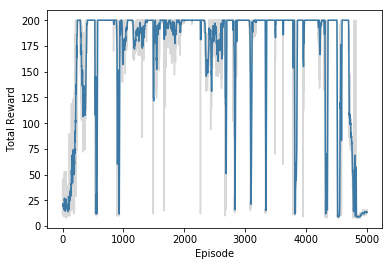

In [68]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [69]:
test_episodes = 10
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(test_episodes):
        state = env.reset()
        print("initial state:", state)
        R = 0
        while True:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            R += reward
            
            if done:
                print("number of steps:", t)
                break
            else:
                state = next_state
                

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt
initial state: [ 0.0193688   0.03542415 -0.04117589  0.04223873]
number of steps: 500
initial state: [ 0.02288549 -0.0031696   0.04251049 -0.02776405]
number of steps: 500
initial state: [-0.03386105 -0.02167067 -0.01470753  0.01671924]
number of steps: 500
initial state: [-0.00881433 -0.01371351  0.00468984  0.00223634]
number of steps: 500
initial state: [ 0.03619746 -0.01036908  0.04528468  0.03425896]
number of steps: 500
initial state: [-0.03146048  0.01203191 -0.02664164  0.02427958]
number of steps: 500
initial state: [-0.03758733 -0.02045957 -0.04326565 -0.04081986]
number of steps: 500
initial state: [ 0.02798031 -0.02414972 -0.02383051 -0.04927738]
number of steps: 500
initial state: [ 0.01911806 -0.01253856  0.02932458 -0.03214634]
number of steps: 500
initial state: [ 0.00726358  0.02174947 -0.03545914  0.02421349]
number of steps: 500


In [ ]:
env.close()

In [11]:
# Code to make the repetitions and generate the final plot
# The parameters and the rnn have to be modified in the above code

n_rep = 10
epss = np.zeros([n_rep, train_episodes])
rewss = np.zeros([n_rep, train_episodes])
for it in range(n_rep):
    # Initialize the simulation
    env.reset()
    # Take one random step to get the pole and cart moving
    state, reward, done, _ = env.step(env.action_space.sample())

    memory = Memory(max_size=memory_size)

    # Make a bunch of random actions and store the experiences
    for ii in range(pretrain_length):
        # Uncomment the line below to watch the simulation
        # env.render()

        # Make a random action
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)

        if done:
            # The simulation fails so no next state
            next_state = np.zeros(state.shape)
            # Add experience to memory
            memory.add((state, action, reward, next_state))

            # Start new episode
            env.reset()
            # Take one random step to get the pole and cart moving
            state, reward, done, _ = env.step(env.action_space.sample())
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state

        # Now train with experiences
    saver = tf.train.Saver()
    rewards_list = []
    with tf.Session() as sess:
        # Initialize variables
        sess.run(tf.global_variables_initializer())

        step = 0
        for ep in range(train_episodes):
            total_reward = 0
            t = 0
            env.reset()
            while t < max_steps:
                step += 1
                # Uncomment this next line to watch the training
                # env.render() 

                # Explore or exploit
                explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
                if explore_p > np.random.rand():
                    # Make a random action
                    action = env.action_space.sample()
                else:
                    # Get action from Q-network
                    feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                    Qs = sess.run(mainQN.output, feed_dict=feed)
                    action = np.argmax(Qs)

                # Take action, get new state and reward
                next_state, reward, done, _ = env.step(action)

                total_reward += reward

                if done:
                    # Episode ends so no next state
                    next_state = np.zeros(state.shape)
                    t = max_steps

                    print('Episode: {}'.format(ep),
                          'Total reward: {}'.format(total_reward),
                          'Training loss: {:.4f}'.format(loss),
                          'Explore P: {:.4f}'.format(explore_p))
                    rewards_list.append((ep, total_reward))

                    # Add experience to memory
                    memory.add((state, action, reward, next_state))
                else:
                    # Add experience to memory
                    memory.add((state, action, reward, next_state))
                    state = next_state
                    t += 1

                # Sample mini-batch from memory
                batch = memory.sample(batch_size)
                states = np.array([each[0] for each in batch])
                actions = np.array([each[1] for each in batch])
                rewards = np.array([each[2] for each in batch])
                next_states = np.array([each[3] for each in batch])

                # Train network           
                target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})

                # Set target_Qs to 0 for states where episode ends
                episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
                target_Qs[episode_ends] = (0, 0)

                targets = rewards + gamma * np.max(target_Qs, axis=1)

                loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                    feed_dict={mainQN.inputs_: states,
                                               mainQN.targetQs_: targets,
                                               mainQN.actions_: actions})

        saver.save(sess, "checkpoints/cartpole.ckpt")
        
        
        
        eps, rews = np.array(rewards_list).T
        epss[it, :] = eps
        rewss[it, :] = rews


Episode: 0 Total reward: 15.0 Training loss: 1.0243 Explore P: 0.9985
Episode: 1 Total reward: 10.0 Training loss: 1.0114 Explore P: 0.9975
Episode: 2 Total reward: 21.0 Training loss: 1.0307 Explore P: 0.9955
Episode: 3 Total reward: 19.0 Training loss: 1.0221 Explore P: 0.9936
Episode: 4 Total reward: 49.0 Training loss: 1.0793 Explore P: 0.9888
Episode: 5 Total reward: 13.0 Training loss: 1.1281 Explore P: 0.9875
Episode: 6 Total reward: 12.0 Training loss: 1.1344 Explore P: 0.9863
Episode: 7 Total reward: 38.0 Training loss: 1.2058 Explore P: 0.9826
Episode: 8 Total reward: 13.0 Training loss: 1.1688 Explore P: 0.9814
Episode: 9 Total reward: 25.0 Training loss: 1.2272 Explore P: 0.9789
Episode: 10 Total reward: 21.0 Training loss: 1.2813 Explore P: 0.9769
Episode: 11 Total reward: 18.0 Training loss: 1.3400 Explore P: 0.9752
Episode: 12 Total reward: 18.0 Training loss: 1.4402 Explore P: 0.9734
Episode: 13 Total reward: 9.0 Training loss: 1.4429 Explore P: 0.9726
Episode: 14 Total

Episode: 117 Total reward: 19.0 Training loss: 64.6529 Explore P: 0.8016
Episode: 118 Total reward: 21.0 Training loss: 53.2072 Explore P: 0.7999
Episode: 119 Total reward: 9.0 Training loss: 88.8761 Explore P: 0.7992
Episode: 120 Total reward: 22.0 Training loss: 58.2205 Explore P: 0.7975
Episode: 121 Total reward: 14.0 Training loss: 63.1461 Explore P: 0.7964
Episode: 122 Total reward: 41.0 Training loss: 54.3008 Explore P: 0.7931
Episode: 123 Total reward: 10.0 Training loss: 79.3688 Explore P: 0.7924
Episode: 124 Total reward: 9.0 Training loss: 39.5849 Explore P: 0.7916
Episode: 125 Total reward: 16.0 Training loss: 64.4424 Explore P: 0.7904
Episode: 126 Total reward: 17.0 Training loss: 20.7422 Explore P: 0.7891
Episode: 127 Total reward: 11.0 Training loss: 39.3200 Explore P: 0.7882
Episode: 128 Total reward: 16.0 Training loss: 59.8195 Explore P: 0.7870
Episode: 129 Total reward: 21.0 Training loss: 37.4728 Explore P: 0.7853
Episode: 130 Total reward: 27.0 Training loss: 38.211

Episode: 233 Total reward: 20.0 Training loss: 19.5725 Explore P: 0.6356
Episode: 234 Total reward: 42.0 Training loss: 16.3417 Explore P: 0.6330
Episode: 235 Total reward: 39.0 Training loss: 12.5528 Explore P: 0.6305
Episode: 236 Total reward: 31.0 Training loss: 32.2715 Explore P: 0.6286
Episode: 237 Total reward: 14.0 Training loss: 8.7109 Explore P: 0.6278
Episode: 238 Total reward: 30.0 Training loss: 14.7279 Explore P: 0.6259
Episode: 239 Total reward: 24.0 Training loss: 38.7385 Explore P: 0.6244
Episode: 240 Total reward: 27.0 Training loss: 18.6375 Explore P: 0.6228
Episode: 241 Total reward: 17.0 Training loss: 11.3274 Explore P: 0.6217
Episode: 242 Total reward: 78.0 Training loss: 48.3890 Explore P: 0.6170
Episode: 243 Total reward: 39.0 Training loss: 19.4229 Explore P: 0.6146
Episode: 244 Total reward: 18.0 Training loss: 22.5024 Explore P: 0.6135
Episode: 245 Total reward: 21.0 Training loss: 40.9680 Explore P: 0.6123
Episode: 246 Total reward: 27.0 Training loss: 17.98

Episode: 346 Total reward: 156.0 Training loss: 71.1522 Explore P: 0.3666
Episode: 347 Total reward: 86.0 Training loss: 49.7925 Explore P: 0.3635
Episode: 348 Total reward: 64.0 Training loss: 31.1261 Explore P: 0.3613
Episode: 349 Total reward: 131.0 Training loss: 57.5738 Explore P: 0.3567
Episode: 350 Total reward: 67.0 Training loss: 94.5593 Explore P: 0.3544
Episode: 351 Total reward: 68.0 Training loss: 53.7421 Explore P: 0.3521
Episode: 352 Total reward: 77.0 Training loss: 67.9838 Explore P: 0.3494
Episode: 353 Total reward: 188.0 Training loss: 78.2308 Explore P: 0.3431
Episode: 354 Total reward: 74.0 Training loss: 70.8753 Explore P: 0.3407
Episode: 355 Total reward: 98.0 Training loss: 23.8198 Explore P: 0.3374
Episode: 356 Total reward: 78.0 Training loss: 49.1007 Explore P: 0.3349
Episode: 357 Total reward: 96.0 Training loss: 8.0529 Explore P: 0.3318
Episode: 358 Total reward: 173.0 Training loss: 42.8308 Explore P: 0.3263
Episode: 359 Total reward: 27.0 Training loss: 9

Episode: 459 Total reward: 93.0 Training loss: 0.1041 Explore P: 0.0721
Episode: 460 Total reward: 166.0 Training loss: 49.3592 Explore P: 0.0711
Episode: 461 Total reward: 96.0 Training loss: 19.4489 Explore P: 0.0705
Episode: 462 Total reward: 88.0 Training loss: 57.8059 Explore P: 0.0700
Episode: 463 Total reward: 72.0 Training loss: 0.1742 Explore P: 0.0695
Episode: 464 Total reward: 111.0 Training loss: 0.1312 Explore P: 0.0689
Episode: 465 Total reward: 122.0 Training loss: 28.8487 Explore P: 0.0682
Episode: 466 Total reward: 86.0 Training loss: 19.5848 Explore P: 0.0677
Episode: 467 Total reward: 120.0 Training loss: 64.2921 Explore P: 0.0670
Episode: 468 Total reward: 98.0 Training loss: 0.1198 Explore P: 0.0664
Episode: 469 Total reward: 125.0 Training loss: 0.1148 Explore P: 0.0657
Episode: 470 Total reward: 96.0 Training loss: 0.2069 Explore P: 0.0652
Episode: 471 Total reward: 106.0 Training loss: 30.1361 Explore P: 0.0646
Episode: 472 Total reward: 120.0 Training loss: 16.

Episode: 571 Total reward: 200.0 Training loss: 0.2784 Explore P: 0.0187
Episode: 572 Total reward: 200.0 Training loss: 0.2354 Explore P: 0.0185
Episode: 573 Total reward: 200.0 Training loss: 38.7348 Explore P: 0.0184
Episode: 574 Total reward: 200.0 Training loss: 0.4213 Explore P: 0.0182
Episode: 575 Total reward: 200.0 Training loss: 0.2694 Explore P: 0.0180
Episode: 576 Total reward: 200.0 Training loss: 98.7311 Explore P: 0.0179
Episode: 577 Total reward: 200.0 Training loss: 0.3181 Explore P: 0.0177
Episode: 578 Total reward: 200.0 Training loss: 0.3455 Explore P: 0.0176
Episode: 579 Total reward: 200.0 Training loss: 49.9121 Explore P: 0.0174
Episode: 580 Total reward: 200.0 Training loss: 12.4763 Explore P: 0.0173
Episode: 581 Total reward: 200.0 Training loss: 46.2649 Explore P: 0.0171
Episode: 582 Total reward: 200.0 Training loss: 47.5743 Explore P: 0.0170
Episode: 583 Total reward: 200.0 Training loss: 0.3049 Explore P: 0.0168
Episode: 584 Total reward: 200.0 Training los

Episode: 683 Total reward: 200.0 Training loss: 0.2467 Explore P: 0.0109
Episode: 684 Total reward: 200.0 Training loss: 47.2361 Explore P: 0.0109
Episode: 685 Total reward: 200.0 Training loss: 90.5930 Explore P: 0.0109
Episode: 686 Total reward: 200.0 Training loss: 0.2226 Explore P: 0.0109
Episode: 687 Total reward: 200.0 Training loss: 0.1962 Explore P: 0.0109
Episode: 688 Total reward: 200.0 Training loss: 0.2018 Explore P: 0.0108
Episode: 689 Total reward: 200.0 Training loss: 0.1938 Explore P: 0.0108
Episode: 690 Total reward: 200.0 Training loss: 42.6285 Explore P: 0.0108
Episode: 691 Total reward: 200.0 Training loss: 44.1374 Explore P: 0.0108
Episode: 692 Total reward: 200.0 Training loss: 45.2308 Explore P: 0.0108
Episode: 693 Total reward: 200.0 Training loss: 46.3614 Explore P: 0.0108
Episode: 694 Total reward: 200.0 Training loss: 46.8997 Explore P: 0.0107
Episode: 695 Total reward: 200.0 Training loss: 45.8534 Explore P: 0.0107
Episode: 696 Total reward: 200.0 Training l

Episode: 796 Total reward: 62.0 Training loss: 0.2340 Explore P: 0.0101
Episode: 797 Total reward: 64.0 Training loss: 1.2484 Explore P: 0.0101
Episode: 798 Total reward: 61.0 Training loss: 0.1396 Explore P: 0.0101
Episode: 799 Total reward: 63.0 Training loss: 59.4064 Explore P: 0.0101
Episode: 800 Total reward: 82.0 Training loss: 11.6407 Explore P: 0.0101
Episode: 801 Total reward: 69.0 Training loss: 17.7853 Explore P: 0.0101
Episode: 802 Total reward: 41.0 Training loss: 29.8054 Explore P: 0.0101
Episode: 803 Total reward: 61.0 Training loss: 60.2467 Explore P: 0.0101
Episode: 804 Total reward: 72.0 Training loss: 33.8559 Explore P: 0.0101
Episode: 805 Total reward: 56.0 Training loss: 19.2679 Explore P: 0.0101
Episode: 806 Total reward: 55.0 Training loss: 30.3074 Explore P: 0.0101
Episode: 807 Total reward: 58.0 Training loss: 0.2253 Explore P: 0.0101
Episode: 808 Total reward: 56.0 Training loss: 53.8802 Explore P: 0.0101
Episode: 809 Total reward: 47.0 Training loss: 110.5683

Episode: 908 Total reward: 200.0 Training loss: 87.6235 Explore P: 0.0100
Episode: 909 Total reward: 200.0 Training loss: 31.0310 Explore P: 0.0100
Episode: 910 Total reward: 200.0 Training loss: 0.1684 Explore P: 0.0100
Episode: 911 Total reward: 200.0 Training loss: 81.4852 Explore P: 0.0100
Episode: 912 Total reward: 200.0 Training loss: 0.2239 Explore P: 0.0100
Episode: 913 Total reward: 200.0 Training loss: 14.4905 Explore P: 0.0100
Episode: 914 Total reward: 200.0 Training loss: 0.2000 Explore P: 0.0100
Episode: 915 Total reward: 200.0 Training loss: 66.5901 Explore P: 0.0100
Episode: 916 Total reward: 200.0 Training loss: 12.1231 Explore P: 0.0100
Episode: 917 Total reward: 200.0 Training loss: 0.1842 Explore P: 0.0100
Episode: 918 Total reward: 200.0 Training loss: 0.2943 Explore P: 0.0100
Episode: 919 Total reward: 200.0 Training loss: 0.1935 Explore P: 0.0100
Episode: 920 Total reward: 200.0 Training loss: 2.7279 Explore P: 0.0100
Episode: 921 Total reward: 200.0 Training los

Episode: 1020 Total reward: 200.0 Training loss: 4.9641 Explore P: 0.0100
Episode: 1021 Total reward: 200.0 Training loss: 177.9177 Explore P: 0.0100
Episode: 1022 Total reward: 200.0 Training loss: 88.6771 Explore P: 0.0100
Episode: 1023 Total reward: 200.0 Training loss: 0.7083 Explore P: 0.0100
Episode: 1024 Total reward: 200.0 Training loss: 0.7297 Explore P: 0.0100
Episode: 1025 Total reward: 14.0 Training loss: 9.4403 Explore P: 0.0100
Episode: 1026 Total reward: 16.0 Training loss: 95.3905 Explore P: 0.0100
Episode: 1027 Total reward: 200.0 Training loss: 148.6550 Explore P: 0.0100
Episode: 1028 Total reward: 11.0 Training loss: 111.0628 Explore P: 0.0100
Episode: 1029 Total reward: 13.0 Training loss: 160.9873 Explore P: 0.0100
Episode: 1030 Total reward: 13.0 Training loss: 176.7087 Explore P: 0.0100
Episode: 1031 Total reward: 15.0 Training loss: 109.4131 Explore P: 0.0100
Episode: 1032 Total reward: 200.0 Training loss: 95.3805 Explore P: 0.0100
Episode: 1033 Total reward: 2

Episode: 1130 Total reward: 200.0 Training loss: 0.0574 Explore P: 0.0100
Episode: 1131 Total reward: 200.0 Training loss: 8.8922 Explore P: 0.0100
Episode: 1132 Total reward: 200.0 Training loss: 0.0433 Explore P: 0.0100
Episode: 1133 Total reward: 200.0 Training loss: 28.7343 Explore P: 0.0100
Episode: 1134 Total reward: 200.0 Training loss: 0.0417 Explore P: 0.0100
Episode: 1135 Total reward: 200.0 Training loss: 0.0612 Explore P: 0.0100
Episode: 1136 Total reward: 200.0 Training loss: 33.9293 Explore P: 0.0100
Episode: 1137 Total reward: 200.0 Training loss: 59.6662 Explore P: 0.0100
Episode: 1138 Total reward: 200.0 Training loss: 76.8630 Explore P: 0.0100
Episode: 1139 Total reward: 200.0 Training loss: 28.5694 Explore P: 0.0100
Episode: 1140 Total reward: 200.0 Training loss: 43.6229 Explore P: 0.0100
Episode: 1141 Total reward: 200.0 Training loss: 17.4521 Explore P: 0.0100
Episode: 1142 Total reward: 200.0 Training loss: 13.5537 Explore P: 0.0100
Episode: 1143 Total reward: 20

Episode: 1240 Total reward: 200.0 Training loss: 0.2194 Explore P: 0.0100
Episode: 1241 Total reward: 200.0 Training loss: 48.3909 Explore P: 0.0100
Episode: 1242 Total reward: 200.0 Training loss: 0.1069 Explore P: 0.0100
Episode: 1243 Total reward: 200.0 Training loss: 0.2169 Explore P: 0.0100
Episode: 1244 Total reward: 200.0 Training loss: 5.2442 Explore P: 0.0100
Episode: 1245 Total reward: 200.0 Training loss: 0.1439 Explore P: 0.0100
Episode: 1246 Total reward: 200.0 Training loss: 76.6601 Explore P: 0.0100
Episode: 1247 Total reward: 200.0 Training loss: 111.7921 Explore P: 0.0100
Episode: 1248 Total reward: 200.0 Training loss: 30.0740 Explore P: 0.0100
Episode: 1249 Total reward: 200.0 Training loss: 121.3594 Explore P: 0.0100
Episode: 1250 Total reward: 200.0 Training loss: 27.9397 Explore P: 0.0100
Episode: 1251 Total reward: 200.0 Training loss: 38.6423 Explore P: 0.0100
Episode: 1252 Total reward: 200.0 Training loss: 0.1276 Explore P: 0.0100
Episode: 1253 Total reward: 2

Episode: 1351 Total reward: 200.0 Training loss: 0.1891 Explore P: 0.0100
Episode: 1352 Total reward: 200.0 Training loss: 97.8679 Explore P: 0.0100
Episode: 1353 Total reward: 200.0 Training loss: 0.1498 Explore P: 0.0100
Episode: 1354 Total reward: 200.0 Training loss: 71.1218 Explore P: 0.0100
Episode: 1355 Total reward: 200.0 Training loss: 0.1738 Explore P: 0.0100
Episode: 1356 Total reward: 200.0 Training loss: 0.1845 Explore P: 0.0100
Episode: 1357 Total reward: 200.0 Training loss: 3.8053 Explore P: 0.0100
Episode: 1358 Total reward: 200.0 Training loss: 0.1431 Explore P: 0.0100
Episode: 1359 Total reward: 200.0 Training loss: 0.1631 Explore P: 0.0100
Episode: 1360 Total reward: 200.0 Training loss: 0.1416 Explore P: 0.0100
Episode: 1361 Total reward: 200.0 Training loss: 33.0022 Explore P: 0.0100
Episode: 1362 Total reward: 200.0 Training loss: 84.8490 Explore P: 0.0100
Episode: 1363 Total reward: 200.0 Training loss: 45.1988 Explore P: 0.0100
Episode: 1364 Total reward: 200.0

Episode: 1461 Total reward: 165.0 Training loss: 0.7535 Explore P: 0.0100
Episode: 1462 Total reward: 137.0 Training loss: 0.6391 Explore P: 0.0100
Episode: 1463 Total reward: 131.0 Training loss: 0.8681 Explore P: 0.0100
Episode: 1464 Total reward: 139.0 Training loss: 1.7270 Explore P: 0.0100
Episode: 1465 Total reward: 186.0 Training loss: 257.7010 Explore P: 0.0100
Episode: 1466 Total reward: 176.0 Training loss: 231.4355 Explore P: 0.0100
Episode: 1467 Total reward: 200.0 Training loss: 97.9315 Explore P: 0.0100
Episode: 1468 Total reward: 200.0 Training loss: 0.3910 Explore P: 0.0100
Episode: 1469 Total reward: 200.0 Training loss: 0.2936 Explore P: 0.0100
Episode: 1470 Total reward: 200.0 Training loss: 0.2522 Explore P: 0.0100
Episode: 1471 Total reward: 200.0 Training loss: 1.6284 Explore P: 0.0100
Episode: 1472 Total reward: 200.0 Training loss: 37.9273 Explore P: 0.0100
Episode: 1473 Total reward: 200.0 Training loss: 0.2173 Explore P: 0.0100
Episode: 1474 Total reward: 200.

Episode: 1572 Total reward: 200.0 Training loss: 117.1666 Explore P: 0.0100
Episode: 1573 Total reward: 200.0 Training loss: 2.2551 Explore P: 0.0100
Episode: 1574 Total reward: 200.0 Training loss: 109.1241 Explore P: 0.0100
Episode: 1575 Total reward: 200.0 Training loss: 0.1372 Explore P: 0.0100
Episode: 1576 Total reward: 200.0 Training loss: 2.3984 Explore P: 0.0100
Episode: 1577 Total reward: 200.0 Training loss: 0.1832 Explore P: 0.0100
Episode: 1578 Total reward: 200.0 Training loss: 0.2499 Explore P: 0.0100
Episode: 1579 Total reward: 200.0 Training loss: 0.2922 Explore P: 0.0100
Episode: 1580 Total reward: 200.0 Training loss: 61.2491 Explore P: 0.0100
Episode: 1581 Total reward: 200.0 Training loss: 7.4716 Explore P: 0.0100
Episode: 1582 Total reward: 200.0 Training loss: 0.2113 Explore P: 0.0100
Episode: 1583 Total reward: 200.0 Training loss: 117.5010 Explore P: 0.0100
Episode: 1584 Total reward: 200.0 Training loss: 56.7654 Explore P: 0.0100
Episode: 1585 Total reward: 20

Episode: 1683 Total reward: 200.0 Training loss: 0.2428 Explore P: 0.0100
Episode: 1684 Total reward: 200.0 Training loss: 0.3446 Explore P: 0.0100
Episode: 1685 Total reward: 200.0 Training loss: 50.8001 Explore P: 0.0100
Episode: 1686 Total reward: 200.0 Training loss: 0.1821 Explore P: 0.0100
Episode: 1687 Total reward: 200.0 Training loss: 0.2599 Explore P: 0.0100
Episode: 1688 Total reward: 200.0 Training loss: 49.8076 Explore P: 0.0100
Episode: 1689 Total reward: 200.0 Training loss: 49.4939 Explore P: 0.0100
Episode: 1690 Total reward: 200.0 Training loss: 96.4542 Explore P: 0.0100
Episode: 1691 Total reward: 200.0 Training loss: 0.2542 Explore P: 0.0100
Episode: 1692 Total reward: 200.0 Training loss: 47.4038 Explore P: 0.0100
Episode: 1693 Total reward: 200.0 Training loss: 0.2204 Explore P: 0.0100
Episode: 1694 Total reward: 200.0 Training loss: 52.3733 Explore P: 0.0100
Episode: 1695 Total reward: 200.0 Training loss: 53.8952 Explore P: 0.0100
Episode: 1696 Total reward: 200

Episode: 1793 Total reward: 200.0 Training loss: 113.1458 Explore P: 0.0100
Episode: 1794 Total reward: 200.0 Training loss: 0.7557 Explore P: 0.0100
Episode: 1795 Total reward: 200.0 Training loss: 57.0766 Explore P: 0.0100
Episode: 1796 Total reward: 200.0 Training loss: 0.9109 Explore P: 0.0100
Episode: 1797 Total reward: 200.0 Training loss: 0.4351 Explore P: 0.0100
Episode: 1798 Total reward: 200.0 Training loss: 0.3531 Explore P: 0.0100
Episode: 1799 Total reward: 200.0 Training loss: 62.2273 Explore P: 0.0100
Episode: 1800 Total reward: 200.0 Training loss: 0.2464 Explore P: 0.0100
Episode: 1801 Total reward: 200.0 Training loss: 0.2650 Explore P: 0.0100
Episode: 1802 Total reward: 200.0 Training loss: 0.2501 Explore P: 0.0100
Episode: 1803 Total reward: 200.0 Training loss: 0.2969 Explore P: 0.0100
Episode: 1804 Total reward: 200.0 Training loss: 44.8198 Explore P: 0.0100
Episode: 1805 Total reward: 200.0 Training loss: 0.2823 Explore P: 0.0100
Episode: 1806 Total reward: 200.0

Episode: 1904 Total reward: 200.0 Training loss: 0.2043 Explore P: 0.0100
Episode: 1905 Total reward: 200.0 Training loss: 20.9502 Explore P: 0.0100
Episode: 1906 Total reward: 200.0 Training loss: 0.1700 Explore P: 0.0100
Episode: 1907 Total reward: 200.0 Training loss: 0.1801 Explore P: 0.0100
Episode: 1908 Total reward: 200.0 Training loss: 22.7548 Explore P: 0.0100
Episode: 1909 Total reward: 200.0 Training loss: 14.1833 Explore P: 0.0100
Episode: 1910 Total reward: 200.0 Training loss: 84.9888 Explore P: 0.0100
Episode: 1911 Total reward: 200.0 Training loss: 25.1300 Explore P: 0.0100
Episode: 1912 Total reward: 200.0 Training loss: 0.1743 Explore P: 0.0100
Episode: 1913 Total reward: 200.0 Training loss: 0.1708 Explore P: 0.0100
Episode: 1914 Total reward: 200.0 Training loss: 0.1261 Explore P: 0.0100
Episode: 1915 Total reward: 200.0 Training loss: 24.1037 Explore P: 0.0100
Episode: 1916 Total reward: 200.0 Training loss: 0.2089 Explore P: 0.0100
Episode: 1917 Total reward: 200.

Episode: 15 Total reward: 32.0 Training loss: 1.7565 Explore P: 0.9685
Episode: 16 Total reward: 42.0 Training loss: 1.9586 Explore P: 0.9645
Episode: 17 Total reward: 17.0 Training loss: 2.1856 Explore P: 0.9629
Episode: 18 Total reward: 33.0 Training loss: 2.3946 Explore P: 0.9598
Episode: 19 Total reward: 16.0 Training loss: 2.0712 Explore P: 0.9582
Episode: 20 Total reward: 16.0 Training loss: 2.2529 Explore P: 0.9567
Episode: 21 Total reward: 28.0 Training loss: 2.8094 Explore P: 0.9541
Episode: 22 Total reward: 24.0 Training loss: 2.5933 Explore P: 0.9518
Episode: 23 Total reward: 43.0 Training loss: 5.0357 Explore P: 0.9478
Episode: 24 Total reward: 45.0 Training loss: 3.2926 Explore P: 0.9436
Episode: 25 Total reward: 27.0 Training loss: 5.1828 Explore P: 0.9410
Episode: 26 Total reward: 35.0 Training loss: 9.3690 Explore P: 0.9378
Episode: 27 Total reward: 17.0 Training loss: 9.3744 Explore P: 0.9362
Episode: 28 Total reward: 17.0 Training loss: 7.7745 Explore P: 0.9346
Episod

Episode: 129 Total reward: 25.0 Training loss: 51.1375 Explore P: 0.7623
Episode: 130 Total reward: 26.0 Training loss: 28.4675 Explore P: 0.7603
Episode: 131 Total reward: 30.0 Training loss: 43.3884 Explore P: 0.7581
Episode: 132 Total reward: 11.0 Training loss: 26.6825 Explore P: 0.7573
Episode: 133 Total reward: 20.0 Training loss: 24.7110 Explore P: 0.7558
Episode: 134 Total reward: 11.0 Training loss: 42.3074 Explore P: 0.7549
Episode: 135 Total reward: 27.0 Training loss: 30.4538 Explore P: 0.7529
Episode: 136 Total reward: 12.0 Training loss: 9.9731 Explore P: 0.7520
Episode: 137 Total reward: 11.0 Training loss: 29.0595 Explore P: 0.7512
Episode: 138 Total reward: 30.0 Training loss: 19.8750 Explore P: 0.7490
Episode: 139 Total reward: 15.0 Training loss: 21.9644 Explore P: 0.7479
Episode: 140 Total reward: 14.0 Training loss: 25.7369 Explore P: 0.7469
Episode: 141 Total reward: 14.0 Training loss: 11.7437 Explore P: 0.7458
Episode: 142 Total reward: 28.0 Training loss: 29.94

Episode: 244 Total reward: 78.0 Training loss: 32.0586 Explore P: 0.4973
Episode: 245 Total reward: 131.0 Training loss: 19.2305 Explore P: 0.4910
Episode: 246 Total reward: 36.0 Training loss: 15.7639 Explore P: 0.4892
Episode: 247 Total reward: 72.0 Training loss: 33.5951 Explore P: 0.4858
Episode: 248 Total reward: 21.0 Training loss: 72.3728 Explore P: 0.4848
Episode: 249 Total reward: 114.0 Training loss: 33.3380 Explore P: 0.4794
Episode: 250 Total reward: 45.0 Training loss: 28.1395 Explore P: 0.4773
Episode: 251 Total reward: 58.0 Training loss: 37.7529 Explore P: 0.4746
Episode: 252 Total reward: 86.0 Training loss: 69.3215 Explore P: 0.4706
Episode: 253 Total reward: 30.0 Training loss: 56.3979 Explore P: 0.4693
Episode: 254 Total reward: 59.0 Training loss: 27.1386 Explore P: 0.4666
Episode: 255 Total reward: 88.0 Training loss: 46.4054 Explore P: 0.4626
Episode: 256 Total reward: 83.0 Training loss: 37.8509 Explore P: 0.4588
Episode: 257 Total reward: 83.0 Training loss: 41

Episode: 356 Total reward: 200.0 Training loss: 0.2208 Explore P: 0.0902
Episode: 357 Total reward: 200.0 Training loss: 99.1471 Explore P: 0.0886
Episode: 358 Total reward: 200.0 Training loss: 0.2912 Explore P: 0.0871
Episode: 359 Total reward: 200.0 Training loss: 0.3485 Explore P: 0.0855
Episode: 360 Total reward: 200.0 Training loss: 40.4156 Explore P: 0.0840
Episode: 361 Total reward: 200.0 Training loss: 0.2312 Explore P: 0.0826
Episode: 362 Total reward: 200.0 Training loss: 0.3159 Explore P: 0.0811
Episode: 363 Total reward: 200.0 Training loss: 0.2127 Explore P: 0.0797
Episode: 364 Total reward: 200.0 Training loss: 51.9591 Explore P: 0.0783
Episode: 365 Total reward: 200.0 Training loss: 0.2197 Explore P: 0.0770
Episode: 366 Total reward: 200.0 Training loss: 47.5476 Explore P: 0.0757
Episode: 367 Total reward: 200.0 Training loss: 0.6385 Explore P: 0.0744
Episode: 368 Total reward: 200.0 Training loss: 52.8366 Explore P: 0.0731
Episode: 369 Total reward: 200.0 Training loss

Episode: 468 Total reward: 200.0 Training loss: 52.0727 Explore P: 0.0185
Episode: 469 Total reward: 200.0 Training loss: 0.2044 Explore P: 0.0184
Episode: 470 Total reward: 200.0 Training loss: 50.6821 Explore P: 0.0182
Episode: 471 Total reward: 200.0 Training loss: 0.2473 Explore P: 0.0180
Episode: 472 Total reward: 200.0 Training loss: 55.1089 Explore P: 0.0179
Episode: 473 Total reward: 200.0 Training loss: 52.1631 Explore P: 0.0177
Episode: 474 Total reward: 200.0 Training loss: 0.2073 Explore P: 0.0176
Episode: 475 Total reward: 200.0 Training loss: 51.7441 Explore P: 0.0174
Episode: 476 Total reward: 200.0 Training loss: 0.1602 Explore P: 0.0173
Episode: 477 Total reward: 200.0 Training loss: 1.0076 Explore P: 0.0171
Episode: 478 Total reward: 200.0 Training loss: 0.1932 Explore P: 0.0170
Episode: 479 Total reward: 200.0 Training loss: 152.1981 Explore P: 0.0169
Episode: 480 Total reward: 200.0 Training loss: 0.6236 Explore P: 0.0167
Episode: 481 Total reward: 200.0 Training lo

Episode: 580 Total reward: 200.0 Training loss: 57.4338 Explore P: 0.0109
Episode: 581 Total reward: 200.0 Training loss: 31.9313 Explore P: 0.0109
Episode: 582 Total reward: 200.0 Training loss: 2.5898 Explore P: 0.0109
Episode: 583 Total reward: 200.0 Training loss: 0.1386 Explore P: 0.0109
Episode: 584 Total reward: 200.0 Training loss: 2.2066 Explore P: 0.0108
Episode: 585 Total reward: 200.0 Training loss: 0.1507 Explore P: 0.0108
Episode: 586 Total reward: 200.0 Training loss: 8.6187 Explore P: 0.0108
Episode: 587 Total reward: 200.0 Training loss: 33.9860 Explore P: 0.0108
Episode: 588 Total reward: 200.0 Training loss: 48.9675 Explore P: 0.0108
Episode: 589 Total reward: 200.0 Training loss: 0.1346 Explore P: 0.0108
Episode: 590 Total reward: 200.0 Training loss: 70.5649 Explore P: 0.0107
Episode: 591 Total reward: 200.0 Training loss: 29.2575 Explore P: 0.0107
Episode: 592 Total reward: 200.0 Training loss: 28.4321 Explore P: 0.0107
Episode: 593 Total reward: 200.0 Training lo

Episode: 692 Total reward: 168.0 Training loss: 7.4913 Explore P: 0.0101
Episode: 693 Total reward: 167.0 Training loss: 0.0816 Explore P: 0.0101
Episode: 694 Total reward: 152.0 Training loss: 9.8305 Explore P: 0.0101
Episode: 695 Total reward: 115.0 Training loss: 6.3560 Explore P: 0.0101
Episode: 696 Total reward: 123.0 Training loss: 16.2937 Explore P: 0.0101
Episode: 697 Total reward: 146.0 Training loss: 0.0779 Explore P: 0.0101
Episode: 698 Total reward: 133.0 Training loss: 22.9831 Explore P: 0.0101
Episode: 699 Total reward: 81.0 Training loss: 22.2546 Explore P: 0.0101
Episode: 700 Total reward: 73.0 Training loss: 29.5489 Explore P: 0.0101
Episode: 701 Total reward: 129.0 Training loss: 19.6862 Explore P: 0.0101
Episode: 702 Total reward: 191.0 Training loss: 8.3904 Explore P: 0.0101
Episode: 703 Total reward: 161.0 Training loss: 75.2739 Explore P: 0.0101
Episode: 704 Total reward: 145.0 Training loss: 0.1262 Explore P: 0.0101
Episode: 705 Total reward: 131.0 Training loss:

Episode: 807 Total reward: 17.0 Training loss: 213.8675 Explore P: 0.0100
Episode: 808 Total reward: 16.0 Training loss: 21.1503 Explore P: 0.0100
Episode: 809 Total reward: 21.0 Training loss: 228.1681 Explore P: 0.0100
Episode: 810 Total reward: 11.0 Training loss: 11.3053 Explore P: 0.0100
Episode: 811 Total reward: 14.0 Training loss: 228.4591 Explore P: 0.0100
Episode: 812 Total reward: 16.0 Training loss: 1.5758 Explore P: 0.0100
Episode: 813 Total reward: 13.0 Training loss: 262.5876 Explore P: 0.0100
Episode: 814 Total reward: 11.0 Training loss: 30.2241 Explore P: 0.0100
Episode: 815 Total reward: 11.0 Training loss: 1.2361 Explore P: 0.0100
Episode: 816 Total reward: 23.0 Training loss: 115.9593 Explore P: 0.0100
Episode: 817 Total reward: 25.0 Training loss: 128.2510 Explore P: 0.0100
Episode: 818 Total reward: 60.0 Training loss: 99.4225 Explore P: 0.0100
Episode: 819 Total reward: 200.0 Training loss: 105.0298 Explore P: 0.0100
Episode: 820 Total reward: 200.0 Training los

Episode: 919 Total reward: 200.0 Training loss: 5.1023 Explore P: 0.0100
Episode: 920 Total reward: 200.0 Training loss: 1.3366 Explore P: 0.0100
Episode: 921 Total reward: 200.0 Training loss: 49.1862 Explore P: 0.0100
Episode: 922 Total reward: 200.0 Training loss: 1.3937 Explore P: 0.0100
Episode: 923 Total reward: 200.0 Training loss: 40.1244 Explore P: 0.0100
Episode: 924 Total reward: 200.0 Training loss: 22.9862 Explore P: 0.0100
Episode: 925 Total reward: 200.0 Training loss: 21.1373 Explore P: 0.0100
Episode: 926 Total reward: 200.0 Training loss: 39.1138 Explore P: 0.0100
Episode: 927 Total reward: 200.0 Training loss: 0.8212 Explore P: 0.0100
Episode: 928 Total reward: 200.0 Training loss: 47.7846 Explore P: 0.0100
Episode: 929 Total reward: 200.0 Training loss: 135.8130 Explore P: 0.0100
Episode: 930 Total reward: 200.0 Training loss: 15.1935 Explore P: 0.0100
Episode: 931 Total reward: 200.0 Training loss: 0.8750 Explore P: 0.0100
Episode: 932 Total reward: 200.0 Training 

Episode: 1031 Total reward: 200.0 Training loss: 0.0555 Explore P: 0.0100
Episode: 1032 Total reward: 200.0 Training loss: 0.0856 Explore P: 0.0100
Episode: 1033 Total reward: 200.0 Training loss: 30.2618 Explore P: 0.0100
Episode: 1034 Total reward: 200.0 Training loss: 25.6765 Explore P: 0.0100
Episode: 1035 Total reward: 200.0 Training loss: 0.0529 Explore P: 0.0100
Episode: 1036 Total reward: 200.0 Training loss: 29.4229 Explore P: 0.0100
Episode: 1037 Total reward: 200.0 Training loss: 0.0722 Explore P: 0.0100
Episode: 1038 Total reward: 200.0 Training loss: 0.0610 Explore P: 0.0100
Episode: 1039 Total reward: 200.0 Training loss: 0.0668 Explore P: 0.0100
Episode: 1040 Total reward: 200.0 Training loss: 93.1466 Explore P: 0.0100
Episode: 1041 Total reward: 200.0 Training loss: 11.2178 Explore P: 0.0100
Episode: 1042 Total reward: 200.0 Training loss: 0.1007 Explore P: 0.0100
Episode: 1043 Total reward: 200.0 Training loss: 31.5896 Explore P: 0.0100
Episode: 1044 Total reward: 200.

Episode: 1141 Total reward: 200.0 Training loss: 4.3377 Explore P: 0.0100
Episode: 1142 Total reward: 200.0 Training loss: 0.0676 Explore P: 0.0100
Episode: 1143 Total reward: 200.0 Training loss: 0.0701 Explore P: 0.0100
Episode: 1144 Total reward: 200.0 Training loss: 0.0657 Explore P: 0.0100
Episode: 1145 Total reward: 200.0 Training loss: 0.0675 Explore P: 0.0100
Episode: 1146 Total reward: 200.0 Training loss: 63.0937 Explore P: 0.0100
Episode: 1147 Total reward: 200.0 Training loss: 0.0828 Explore P: 0.0100
Episode: 1148 Total reward: 200.0 Training loss: 11.6758 Explore P: 0.0100
Episode: 1149 Total reward: 200.0 Training loss: 0.0993 Explore P: 0.0100
Episode: 1150 Total reward: 200.0 Training loss: 0.0901 Explore P: 0.0100
Episode: 1151 Total reward: 200.0 Training loss: 0.1063 Explore P: 0.0100
Episode: 1152 Total reward: 200.0 Training loss: 10.2619 Explore P: 0.0100
Episode: 1153 Total reward: 200.0 Training loss: 4.7182 Explore P: 0.0100
Episode: 1154 Total reward: 200.0 T

Episode: 1251 Total reward: 200.0 Training loss: 0.0434 Explore P: 0.0100
Episode: 1252 Total reward: 200.0 Training loss: 0.0679 Explore P: 0.0100
Episode: 1253 Total reward: 200.0 Training loss: 38.4996 Explore P: 0.0100
Episode: 1254 Total reward: 200.0 Training loss: 42.5635 Explore P: 0.0100
Episode: 1255 Total reward: 200.0 Training loss: 36.0651 Explore P: 0.0100
Episode: 1256 Total reward: 200.0 Training loss: 0.0351 Explore P: 0.0100
Episode: 1257 Total reward: 200.0 Training loss: 25.0405 Explore P: 0.0100
Episode: 1258 Total reward: 200.0 Training loss: 66.8926 Explore P: 0.0100
Episode: 1259 Total reward: 200.0 Training loss: 36.4523 Explore P: 0.0100
Episode: 1260 Total reward: 200.0 Training loss: 22.5455 Explore P: 0.0100
Episode: 1261 Total reward: 200.0 Training loss: 23.5318 Explore P: 0.0100
Episode: 1262 Total reward: 200.0 Training loss: 35.3889 Explore P: 0.0100
Episode: 1263 Total reward: 200.0 Training loss: 0.0481 Explore P: 0.0100
Episode: 1264 Total reward: 2

Episode: 1361 Total reward: 200.0 Training loss: 38.5182 Explore P: 0.0100
Episode: 1362 Total reward: 200.0 Training loss: 18.4121 Explore P: 0.0100
Episode: 1363 Total reward: 200.0 Training loss: 0.1140 Explore P: 0.0100
Episode: 1364 Total reward: 200.0 Training loss: 17.3925 Explore P: 0.0100
Episode: 1365 Total reward: 200.0 Training loss: 30.0746 Explore P: 0.0100
Episode: 1366 Total reward: 200.0 Training loss: 0.1285 Explore P: 0.0100
Episode: 1367 Total reward: 200.0 Training loss: 0.1603 Explore P: 0.0100
Episode: 1368 Total reward: 200.0 Training loss: 0.0657 Explore P: 0.0100
Episode: 1369 Total reward: 200.0 Training loss: 0.0782 Explore P: 0.0100
Episode: 1370 Total reward: 200.0 Training loss: 0.0892 Explore P: 0.0100
Episode: 1371 Total reward: 200.0 Training loss: 0.0886 Explore P: 0.0100
Episode: 1372 Total reward: 200.0 Training loss: 0.0810 Explore P: 0.0100
Episode: 1373 Total reward: 200.0 Training loss: 25.3050 Explore P: 0.0100
Episode: 1374 Total reward: 200.0

Episode: 1471 Total reward: 200.0 Training loss: 2.2784 Explore P: 0.0100
Episode: 1472 Total reward: 200.0 Training loss: 147.5540 Explore P: 0.0100
Episode: 1473 Total reward: 200.0 Training loss: 0.0680 Explore P: 0.0100
Episode: 1474 Total reward: 200.0 Training loss: 0.0823 Explore P: 0.0100
Episode: 1475 Total reward: 200.0 Training loss: 110.6463 Explore P: 0.0100
Episode: 1476 Total reward: 200.0 Training loss: 13.5555 Explore P: 0.0100
Episode: 1477 Total reward: 200.0 Training loss: 0.0707 Explore P: 0.0100
Episode: 1478 Total reward: 200.0 Training loss: 36.4259 Explore P: 0.0100
Episode: 1479 Total reward: 200.0 Training loss: 41.1428 Explore P: 0.0100
Episode: 1480 Total reward: 200.0 Training loss: 0.1510 Explore P: 0.0100
Episode: 1481 Total reward: 200.0 Training loss: 0.0806 Explore P: 0.0100
Episode: 1482 Total reward: 200.0 Training loss: 0.1118 Explore P: 0.0100
Episode: 1483 Total reward: 200.0 Training loss: 0.0689 Explore P: 0.0100
Episode: 1484 Total reward: 200

Episode: 1581 Total reward: 200.0 Training loss: 87.6198 Explore P: 0.0100
Episode: 1582 Total reward: 200.0 Training loss: 113.7926 Explore P: 0.0100
Episode: 1583 Total reward: 200.0 Training loss: 139.8979 Explore P: 0.0100
Episode: 1584 Total reward: 200.0 Training loss: 86.4505 Explore P: 0.0100
Episode: 1585 Total reward: 200.0 Training loss: 0.3957 Explore P: 0.0100
Episode: 1586 Total reward: 200.0 Training loss: 0.2636 Explore P: 0.0100
Episode: 1587 Total reward: 200.0 Training loss: 0.7527 Explore P: 0.0100
Episode: 1588 Total reward: 200.0 Training loss: 0.4323 Explore P: 0.0100
Episode: 1589 Total reward: 200.0 Training loss: 0.3011 Explore P: 0.0100
Episode: 1590 Total reward: 200.0 Training loss: 84.9118 Explore P: 0.0100
Episode: 1591 Total reward: 200.0 Training loss: 90.7221 Explore P: 0.0100
Episode: 1592 Total reward: 200.0 Training loss: 1.3184 Explore P: 0.0100
Episode: 1593 Total reward: 200.0 Training loss: 16.4011 Explore P: 0.0100
Episode: 1594 Total reward: 2

Episode: 1691 Total reward: 200.0 Training loss: 73.4137 Explore P: 0.0100
Episode: 1692 Total reward: 200.0 Training loss: 0.0607 Explore P: 0.0100
Episode: 1693 Total reward: 200.0 Training loss: 0.0651 Explore P: 0.0100
Episode: 1694 Total reward: 200.0 Training loss: 0.0910 Explore P: 0.0100
Episode: 1695 Total reward: 200.0 Training loss: 11.4190 Explore P: 0.0100
Episode: 1696 Total reward: 200.0 Training loss: 25.2686 Explore P: 0.0100
Episode: 1697 Total reward: 200.0 Training loss: 0.1503 Explore P: 0.0100
Episode: 1698 Total reward: 200.0 Training loss: 15.4125 Explore P: 0.0100
Episode: 1699 Total reward: 200.0 Training loss: 0.0643 Explore P: 0.0100
Episode: 1700 Total reward: 200.0 Training loss: 14.0401 Explore P: 0.0100
Episode: 1701 Total reward: 200.0 Training loss: 0.0730 Explore P: 0.0100
Episode: 1702 Total reward: 200.0 Training loss: 39.1108 Explore P: 0.0100
Episode: 1703 Total reward: 200.0 Training loss: 27.1251 Explore P: 0.0100
Episode: 1704 Total reward: 200

Episode: 1801 Total reward: 200.0 Training loss: 0.0711 Explore P: 0.0100
Episode: 1802 Total reward: 200.0 Training loss: 10.3339 Explore P: 0.0100
Episode: 1803 Total reward: 200.0 Training loss: 98.6356 Explore P: 0.0100
Episode: 1804 Total reward: 200.0 Training loss: 0.1777 Explore P: 0.0100
Episode: 1805 Total reward: 200.0 Training loss: 0.1199 Explore P: 0.0100
Episode: 1806 Total reward: 200.0 Training loss: 56.4016 Explore P: 0.0100
Episode: 1807 Total reward: 200.0 Training loss: 0.0450 Explore P: 0.0100
Episode: 1808 Total reward: 200.0 Training loss: 51.3305 Explore P: 0.0100
Episode: 1809 Total reward: 200.0 Training loss: 40.4857 Explore P: 0.0100
Episode: 1810 Total reward: 200.0 Training loss: 59.8554 Explore P: 0.0100
Episode: 1811 Total reward: 200.0 Training loss: 0.2126 Explore P: 0.0100
Episode: 1812 Total reward: 200.0 Training loss: 0.1251 Explore P: 0.0100
Episode: 1813 Total reward: 200.0 Training loss: 0.3103 Explore P: 0.0100
Episode: 1814 Total reward: 200.

Episode: 1911 Total reward: 200.0 Training loss: 0.7637 Explore P: 0.0100
Episode: 1912 Total reward: 200.0 Training loss: 0.5633 Explore P: 0.0100
Episode: 1913 Total reward: 200.0 Training loss: 0.9146 Explore P: 0.0100
Episode: 1914 Total reward: 200.0 Training loss: 63.4570 Explore P: 0.0100
Episode: 1915 Total reward: 200.0 Training loss: 57.3864 Explore P: 0.0100
Episode: 1916 Total reward: 200.0 Training loss: 58.1135 Explore P: 0.0100
Episode: 1917 Total reward: 200.0 Training loss: 0.4562 Explore P: 0.0100
Episode: 1918 Total reward: 200.0 Training loss: 57.2672 Explore P: 0.0100
Episode: 1919 Total reward: 200.0 Training loss: 55.0743 Explore P: 0.0100
Episode: 1920 Total reward: 200.0 Training loss: 0.7248 Explore P: 0.0100
Episode: 1921 Total reward: 200.0 Training loss: 0.4170 Explore P: 0.0100
Episode: 1922 Total reward: 200.0 Training loss: 41.8395 Explore P: 0.0100
Episode: 1923 Total reward: 200.0 Training loss: 0.4273 Explore P: 0.0100
Episode: 1924 Total reward: 200.

Episode: 24 Total reward: 36.0 Training loss: 3.1464 Explore P: 0.9475
Episode: 25 Total reward: 18.0 Training loss: 5.7001 Explore P: 0.9458
Episode: 26 Total reward: 16.0 Training loss: 5.4894 Explore P: 0.9443
Episode: 27 Total reward: 19.0 Training loss: 6.5120 Explore P: 0.9425
Episode: 28 Total reward: 19.0 Training loss: 6.0823 Explore P: 0.9408
Episode: 29 Total reward: 16.0 Training loss: 6.6788 Explore P: 0.9393
Episode: 30 Total reward: 19.0 Training loss: 10.4457 Explore P: 0.9375
Episode: 31 Total reward: 62.0 Training loss: 8.3135 Explore P: 0.9318
Episode: 32 Total reward: 15.0 Training loss: 8.3416 Explore P: 0.9304
Episode: 33 Total reward: 34.0 Training loss: 8.0057 Explore P: 0.9273
Episode: 34 Total reward: 18.0 Training loss: 8.4616 Explore P: 0.9256
Episode: 35 Total reward: 16.0 Training loss: 10.4997 Explore P: 0.9242
Episode: 36 Total reward: 12.0 Training loss: 11.6546 Explore P: 0.9231
Episode: 37 Total reward: 26.0 Training loss: 16.7367 Explore P: 0.9207
Ep

Episode: 139 Total reward: 47.0 Training loss: 24.1795 Explore P: 0.7267
Episode: 140 Total reward: 34.0 Training loss: 20.2757 Explore P: 0.7242
Episode: 141 Total reward: 14.0 Training loss: 28.0474 Explore P: 0.7232
Episode: 142 Total reward: 11.0 Training loss: 21.3095 Explore P: 0.7224
Episode: 143 Total reward: 29.0 Training loss: 10.1516 Explore P: 0.7204
Episode: 144 Total reward: 31.0 Training loss: 19.4418 Explore P: 0.7182
Episode: 145 Total reward: 23.0 Training loss: 10.2034 Explore P: 0.7166
Episode: 146 Total reward: 18.0 Training loss: 34.5654 Explore P: 0.7153
Episode: 147 Total reward: 94.0 Training loss: 28.0499 Explore P: 0.7087
Episode: 148 Total reward: 24.0 Training loss: 1.7103 Explore P: 0.7070
Episode: 149 Total reward: 25.0 Training loss: 22.1043 Explore P: 0.7053
Episode: 150 Total reward: 11.0 Training loss: 23.2252 Explore P: 0.7045
Episode: 151 Total reward: 73.0 Training loss: 21.1014 Explore P: 0.6995
Episode: 152 Total reward: 78.0 Training loss: 36.60

Episode: 253 Total reward: 102.0 Training loss: 62.2873 Explore P: 0.4210
Episode: 254 Total reward: 98.0 Training loss: 57.5952 Explore P: 0.4170
Episode: 255 Total reward: 85.0 Training loss: 76.8646 Explore P: 0.4135
Episode: 256 Total reward: 80.0 Training loss: 67.2656 Explore P: 0.4103
Episode: 257 Total reward: 94.0 Training loss: 31.2382 Explore P: 0.4066
Episode: 258 Total reward: 102.0 Training loss: 48.7383 Explore P: 0.4025
Episode: 259 Total reward: 42.0 Training loss: 71.0254 Explore P: 0.4009
Episode: 260 Total reward: 119.0 Training loss: 81.0772 Explore P: 0.3963
Episode: 261 Total reward: 70.0 Training loss: 42.8051 Explore P: 0.3936
Episode: 262 Total reward: 44.0 Training loss: 63.2876 Explore P: 0.3919
Episode: 263 Total reward: 91.0 Training loss: 15.4299 Explore P: 0.3884
Episode: 264 Total reward: 43.0 Training loss: 28.0024 Explore P: 0.3868
Episode: 265 Total reward: 42.0 Training loss: 50.9404 Explore P: 0.3852
Episode: 266 Total reward: 52.0 Training loss: 4

Episode: 365 Total reward: 200.0 Training loss: 71.8509 Explore P: 0.1043
Episode: 366 Total reward: 200.0 Training loss: 0.4891 Explore P: 0.1025
Episode: 367 Total reward: 162.0 Training loss: 0.3583 Explore P: 0.1010
Episode: 368 Total reward: 200.0 Training loss: 59.2261 Explore P: 0.0992
Episode: 369 Total reward: 200.0 Training loss: 0.2504 Explore P: 0.0974
Episode: 370 Total reward: 200.0 Training loss: 29.4606 Explore P: 0.0957
Episode: 371 Total reward: 200.0 Training loss: 0.4084 Explore P: 0.0940
Episode: 372 Total reward: 200.0 Training loss: 0.3979 Explore P: 0.0923
Episode: 373 Total reward: 200.0 Training loss: 0.2825 Explore P: 0.0907
Episode: 374 Total reward: 200.0 Training loss: 84.9437 Explore P: 0.0891
Episode: 375 Total reward: 200.0 Training loss: 40.6211 Explore P: 0.0875
Episode: 376 Total reward: 200.0 Training loss: 0.2916 Explore P: 0.0860
Episode: 377 Total reward: 200.0 Training loss: 0.3770 Explore P: 0.0845
Episode: 378 Total reward: 200.0 Training loss

Episode: 477 Total reward: 165.0 Training loss: 23.1379 Explore P: 0.0218
Episode: 478 Total reward: 174.0 Training loss: 50.4627 Explore P: 0.0216
Episode: 479 Total reward: 194.0 Training loss: 83.0509 Explore P: 0.0214
Episode: 480 Total reward: 154.0 Training loss: 49.3733 Explore P: 0.0212
Episode: 481 Total reward: 188.0 Training loss: 56.8092 Explore P: 0.0210
Episode: 482 Total reward: 181.0 Training loss: 0.1218 Explore P: 0.0208
Episode: 483 Total reward: 166.0 Training loss: 16.3159 Explore P: 0.0206
Episode: 484 Total reward: 159.0 Training loss: 28.7440 Explore P: 0.0204
Episode: 485 Total reward: 200.0 Training loss: 0.1120 Explore P: 0.0202
Episode: 486 Total reward: 182.0 Training loss: 0.1047 Explore P: 0.0201
Episode: 487 Total reward: 200.0 Training loss: 0.1013 Explore P: 0.0199
Episode: 488 Total reward: 200.0 Training loss: 0.0960 Explore P: 0.0197
Episode: 489 Total reward: 200.0 Training loss: 32.5700 Explore P: 0.0195
Episode: 490 Total reward: 200.0 Training l

Episode: 589 Total reward: 200.0 Training loss: 0.0523 Explore P: 0.0113
Episode: 590 Total reward: 158.0 Training loss: 0.1349 Explore P: 0.0113
Episode: 591 Total reward: 190.0 Training loss: 0.1074 Explore P: 0.0113
Episode: 592 Total reward: 200.0 Training loss: 0.0511 Explore P: 0.0113
Episode: 593 Total reward: 200.0 Training loss: 0.0589 Explore P: 0.0112
Episode: 594 Total reward: 200.0 Training loss: 0.0736 Explore P: 0.0112
Episode: 595 Total reward: 200.0 Training loss: 22.0389 Explore P: 0.0112
Episode: 596 Total reward: 200.0 Training loss: 42.8996 Explore P: 0.0112
Episode: 597 Total reward: 200.0 Training loss: 40.5574 Explore P: 0.0111
Episode: 598 Total reward: 200.0 Training loss: 55.3454 Explore P: 0.0111
Episode: 599 Total reward: 200.0 Training loss: 68.9685 Explore P: 0.0111
Episode: 600 Total reward: 200.0 Training loss: 0.0422 Explore P: 0.0111
Episode: 601 Total reward: 194.0 Training loss: 0.0807 Explore P: 0.0110
Episode: 602 Total reward: 157.0 Training loss

Episode: 701 Total reward: 148.0 Training loss: 42.8288 Explore P: 0.0103
Episode: 702 Total reward: 152.0 Training loss: 13.7895 Explore P: 0.0103
Episode: 703 Total reward: 158.0 Training loss: 119.0268 Explore P: 0.0103
Episode: 704 Total reward: 200.0 Training loss: 192.1572 Explore P: 0.0103
Episode: 705 Total reward: 174.0 Training loss: 12.5651 Explore P: 0.0102
Episode: 706 Total reward: 200.0 Training loss: 0.4546 Explore P: 0.0102
Episode: 707 Total reward: 200.0 Training loss: 39.0922 Explore P: 0.0102
Episode: 708 Total reward: 200.0 Training loss: 8.8606 Explore P: 0.0102
Episode: 709 Total reward: 200.0 Training loss: 34.7911 Explore P: 0.0102
Episode: 710 Total reward: 200.0 Training loss: 57.0672 Explore P: 0.0102
Episode: 711 Total reward: 200.0 Training loss: 87.4454 Explore P: 0.0102
Episode: 712 Total reward: 200.0 Training loss: 121.1068 Explore P: 0.0102
Episode: 713 Total reward: 200.0 Training loss: 0.5734 Explore P: 0.0102
Episode: 714 Total reward: 200.0 Train

Episode: 817 Total reward: 13.0 Training loss: 39.5723 Explore P: 0.0101
Episode: 818 Total reward: 14.0 Training loss: 258.9668 Explore P: 0.0101
Episode: 819 Total reward: 14.0 Training loss: 244.2769 Explore P: 0.0101
Episode: 820 Total reward: 19.0 Training loss: 16.3735 Explore P: 0.0101
Episode: 821 Total reward: 22.0 Training loss: 3.3117 Explore P: 0.0101
Episode: 822 Total reward: 17.0 Training loss: 198.4577 Explore P: 0.0101
Episode: 823 Total reward: 18.0 Training loss: 2.8790 Explore P: 0.0101
Episode: 824 Total reward: 111.0 Training loss: 110.1279 Explore P: 0.0101
Episode: 825 Total reward: 147.0 Training loss: 271.5009 Explore P: 0.0101
Episode: 826 Total reward: 170.0 Training loss: 80.4137 Explore P: 0.0101
Episode: 827 Total reward: 200.0 Training loss: 1.1800 Explore P: 0.0101
Episode: 828 Total reward: 200.0 Training loss: 123.4890 Explore P: 0.0101
Episode: 829 Total reward: 200.0 Training loss: 1.2749 Explore P: 0.0101
Episode: 830 Total reward: 200.0 Training l

Episode: 929 Total reward: 200.0 Training loss: 74.3978 Explore P: 0.0100
Episode: 930 Total reward: 200.0 Training loss: 0.1698 Explore P: 0.0100
Episode: 931 Total reward: 200.0 Training loss: 4.3203 Explore P: 0.0100
Episode: 932 Total reward: 200.0 Training loss: 84.4739 Explore P: 0.0100
Episode: 933 Total reward: 200.0 Training loss: 0.2366 Explore P: 0.0100
Episode: 934 Total reward: 200.0 Training loss: 4.1715 Explore P: 0.0100
Episode: 935 Total reward: 200.0 Training loss: 0.3071 Explore P: 0.0100
Episode: 936 Total reward: 200.0 Training loss: 52.8341 Explore P: 0.0100
Episode: 937 Total reward: 200.0 Training loss: 57.0598 Explore P: 0.0100
Episode: 938 Total reward: 200.0 Training loss: 57.8761 Explore P: 0.0100
Episode: 939 Total reward: 200.0 Training loss: 15.8793 Explore P: 0.0100
Episode: 940 Total reward: 200.0 Training loss: 0.2673 Explore P: 0.0100
Episode: 941 Total reward: 200.0 Training loss: 118.9169 Explore P: 0.0100
Episode: 942 Total reward: 200.0 Training l

Episode: 1040 Total reward: 148.0 Training loss: 0.2994 Explore P: 0.0100
Episode: 1041 Total reward: 200.0 Training loss: 68.9491 Explore P: 0.0100
Episode: 1042 Total reward: 198.0 Training loss: 0.1985 Explore P: 0.0100
Episode: 1043 Total reward: 184.0 Training loss: 8.6689 Explore P: 0.0100
Episode: 1044 Total reward: 131.0 Training loss: 18.2652 Explore P: 0.0100
Episode: 1045 Total reward: 129.0 Training loss: 0.1611 Explore P: 0.0100
Episode: 1046 Total reward: 200.0 Training loss: 0.1535 Explore P: 0.0100
Episode: 1047 Total reward: 102.0 Training loss: 16.8249 Explore P: 0.0100
Episode: 1048 Total reward: 200.0 Training loss: 124.7532 Explore P: 0.0100
Episode: 1049 Total reward: 161.0 Training loss: 161.5991 Explore P: 0.0100
Episode: 1050 Total reward: 200.0 Training loss: 50.7616 Explore P: 0.0100
Episode: 1051 Total reward: 186.0 Training loss: 0.2157 Explore P: 0.0100
Episode: 1052 Total reward: 200.0 Training loss: 65.2180 Explore P: 0.0100
Episode: 1053 Total reward: 2

Episode: 1150 Total reward: 200.0 Training loss: 32.2832 Explore P: 0.0100
Episode: 1151 Total reward: 126.0 Training loss: 14.0381 Explore P: 0.0100
Episode: 1152 Total reward: 200.0 Training loss: 13.5537 Explore P: 0.0100
Episode: 1153 Total reward: 83.0 Training loss: 15.0341 Explore P: 0.0100
Episode: 1154 Total reward: 102.0 Training loss: 27.7912 Explore P: 0.0100
Episode: 1155 Total reward: 200.0 Training loss: 44.3086 Explore P: 0.0100
Episode: 1156 Total reward: 138.0 Training loss: 0.2348 Explore P: 0.0100
Episode: 1157 Total reward: 200.0 Training loss: 35.1093 Explore P: 0.0100
Episode: 1158 Total reward: 200.0 Training loss: 0.1406 Explore P: 0.0100
Episode: 1159 Total reward: 157.0 Training loss: 0.1233 Explore P: 0.0100
Episode: 1160 Total reward: 200.0 Training loss: 64.3283 Explore P: 0.0100
Episode: 1161 Total reward: 83.0 Training loss: 0.2037 Explore P: 0.0100
Episode: 1162 Total reward: 146.0 Training loss: 0.1099 Explore P: 0.0100
Episode: 1163 Total reward: 200.

Episode: 1260 Total reward: 200.0 Training loss: 78.0146 Explore P: 0.0100
Episode: 1261 Total reward: 173.0 Training loss: 10.4484 Explore P: 0.0100
Episode: 1262 Total reward: 101.0 Training loss: 20.6123 Explore P: 0.0100
Episode: 1263 Total reward: 155.0 Training loss: 50.1255 Explore P: 0.0100
Episode: 1264 Total reward: 200.0 Training loss: 0.0957 Explore P: 0.0100
Episode: 1265 Total reward: 200.0 Training loss: 0.1204 Explore P: 0.0100
Episode: 1266 Total reward: 167.0 Training loss: 19.3482 Explore P: 0.0100
Episode: 1267 Total reward: 169.0 Training loss: 23.9194 Explore P: 0.0100
Episode: 1268 Total reward: 104.0 Training loss: 0.0849 Explore P: 0.0100
Episode: 1269 Total reward: 133.0 Training loss: 0.0590 Explore P: 0.0100
Episode: 1270 Total reward: 192.0 Training loss: 22.0762 Explore P: 0.0100
Episode: 1271 Total reward: 102.0 Training loss: 21.9392 Explore P: 0.0100
Episode: 1272 Total reward: 158.0 Training loss: 40.3317 Explore P: 0.0100
Episode: 1273 Total reward: 1

Episode: 1372 Total reward: 50.0 Training loss: 256.1006 Explore P: 0.0100
Episode: 1373 Total reward: 47.0 Training loss: 208.0341 Explore P: 0.0100
Episode: 1374 Total reward: 113.0 Training loss: 1.1007 Explore P: 0.0100
Episode: 1375 Total reward: 191.0 Training loss: 122.5276 Explore P: 0.0100
Episode: 1376 Total reward: 54.0 Training loss: 83.2974 Explore P: 0.0100
Episode: 1377 Total reward: 83.0 Training loss: 147.3936 Explore P: 0.0100
Episode: 1378 Total reward: 126.0 Training loss: 37.9321 Explore P: 0.0100
Episode: 1379 Total reward: 151.0 Training loss: 62.4295 Explore P: 0.0100
Episode: 1380 Total reward: 42.0 Training loss: 59.2425 Explore P: 0.0100
Episode: 1381 Total reward: 43.0 Training loss: 76.1672 Explore P: 0.0100
Episode: 1382 Total reward: 48.0 Training loss: 78.6165 Explore P: 0.0100
Episode: 1383 Total reward: 79.0 Training loss: 16.9247 Explore P: 0.0100
Episode: 1384 Total reward: 99.0 Training loss: 117.0688 Explore P: 0.0100
Episode: 1385 Total reward: 62

Episode: 1482 Total reward: 92.0 Training loss: 79.6189 Explore P: 0.0100
Episode: 1483 Total reward: 109.0 Training loss: 585.1622 Explore P: 0.0100
Episode: 1484 Total reward: 102.0 Training loss: 68.0387 Explore P: 0.0100
Episode: 1485 Total reward: 95.0 Training loss: 83.2598 Explore P: 0.0100
Episode: 1486 Total reward: 119.0 Training loss: 265.6333 Explore P: 0.0100
Episode: 1487 Total reward: 114.0 Training loss: 411.8262 Explore P: 0.0100
Episode: 1488 Total reward: 121.0 Training loss: 325.9547 Explore P: 0.0100
Episode: 1489 Total reward: 142.0 Training loss: 177.1087 Explore P: 0.0100
Episode: 1490 Total reward: 169.0 Training loss: 28.1209 Explore P: 0.0100
Episode: 1491 Total reward: 163.0 Training loss: 124.7623 Explore P: 0.0100
Episode: 1492 Total reward: 148.0 Training loss: 112.4418 Explore P: 0.0100
Episode: 1493 Total reward: 174.0 Training loss: 58.3211 Explore P: 0.0100
Episode: 1494 Total reward: 117.0 Training loss: 11.7061 Explore P: 0.0100
Episode: 1495 Total 

Episode: 1592 Total reward: 200.0 Training loss: 68.3769 Explore P: 0.0100
Episode: 1593 Total reward: 200.0 Training loss: 0.1275 Explore P: 0.0100
Episode: 1594 Total reward: 200.0 Training loss: 67.6068 Explore P: 0.0100
Episode: 1595 Total reward: 200.0 Training loss: 18.0908 Explore P: 0.0100
Episode: 1596 Total reward: 164.0 Training loss: 0.1397 Explore P: 0.0100
Episode: 1597 Total reward: 119.0 Training loss: 0.1473 Explore P: 0.0100
Episode: 1598 Total reward: 190.0 Training loss: 30.8341 Explore P: 0.0100
Episode: 1599 Total reward: 165.0 Training loss: 39.2516 Explore P: 0.0100
Episode: 1600 Total reward: 200.0 Training loss: 22.7583 Explore P: 0.0100
Episode: 1601 Total reward: 144.0 Training loss: 0.0869 Explore P: 0.0100
Episode: 1602 Total reward: 200.0 Training loss: 65.3225 Explore P: 0.0100
Episode: 1603 Total reward: 144.0 Training loss: 21.9068 Explore P: 0.0100
Episode: 1604 Total reward: 155.0 Training loss: 15.3570 Explore P: 0.0100
Episode: 1605 Total reward: 1

Episode: 1702 Total reward: 134.0 Training loss: 18.7190 Explore P: 0.0100
Episode: 1703 Total reward: 132.0 Training loss: 133.2176 Explore P: 0.0100
Episode: 1704 Total reward: 64.0 Training loss: 55.6885 Explore P: 0.0100
Episode: 1705 Total reward: 135.0 Training loss: 20.7318 Explore P: 0.0100
Episode: 1706 Total reward: 66.0 Training loss: 41.1035 Explore P: 0.0100
Episode: 1707 Total reward: 70.0 Training loss: 97.0023 Explore P: 0.0100
Episode: 1708 Total reward: 138.0 Training loss: 51.8141 Explore P: 0.0100
Episode: 1709 Total reward: 148.0 Training loss: 0.0830 Explore P: 0.0100
Episode: 1710 Total reward: 198.0 Training loss: 20.8625 Explore P: 0.0100
Episode: 1711 Total reward: 184.0 Training loss: 13.1149 Explore P: 0.0100
Episode: 1712 Total reward: 137.0 Training loss: 53.4648 Explore P: 0.0100
Episode: 1713 Total reward: 129.0 Training loss: 19.1089 Explore P: 0.0100
Episode: 1714 Total reward: 159.0 Training loss: 0.0890 Explore P: 0.0100
Episode: 1715 Total reward: 2

Episode: 1812 Total reward: 141.0 Training loss: 0.1226 Explore P: 0.0100
Episode: 1813 Total reward: 200.0 Training loss: 16.6159 Explore P: 0.0100
Episode: 1814 Total reward: 178.0 Training loss: 59.7427 Explore P: 0.0100
Episode: 1815 Total reward: 179.0 Training loss: 19.9687 Explore P: 0.0100
Episode: 1816 Total reward: 166.0 Training loss: 67.4746 Explore P: 0.0100
Episode: 1817 Total reward: 69.0 Training loss: 34.2327 Explore P: 0.0100
Episode: 1818 Total reward: 154.0 Training loss: 0.1279 Explore P: 0.0100
Episode: 1819 Total reward: 126.0 Training loss: 35.8665 Explore P: 0.0100
Episode: 1820 Total reward: 152.0 Training loss: 33.6779 Explore P: 0.0100
Episode: 1821 Total reward: 118.0 Training loss: 17.1805 Explore P: 0.0100
Episode: 1822 Total reward: 50.0 Training loss: 40.9944 Explore P: 0.0100
Episode: 1823 Total reward: 132.0 Training loss: 35.3261 Explore P: 0.0100
Episode: 1824 Total reward: 136.0 Training loss: 34.6610 Explore P: 0.0100
Episode: 1825 Total reward: 1

Episode: 1923 Total reward: 200.0 Training loss: 80.3005 Explore P: 0.0100
Episode: 1924 Total reward: 200.0 Training loss: 2.5660 Explore P: 0.0100
Episode: 1925 Total reward: 200.0 Training loss: 56.0778 Explore P: 0.0100
Episode: 1926 Total reward: 90.0 Training loss: 95.8817 Explore P: 0.0100
Episode: 1927 Total reward: 19.0 Training loss: 81.9028 Explore P: 0.0100
Episode: 1928 Total reward: 200.0 Training loss: 30.6303 Explore P: 0.0100
Episode: 1929 Total reward: 200.0 Training loss: 30.9406 Explore P: 0.0100
Episode: 1930 Total reward: 200.0 Training loss: 18.0029 Explore P: 0.0100
Episode: 1931 Total reward: 19.0 Training loss: 202.3852 Explore P: 0.0100
Episode: 1932 Total reward: 200.0 Training loss: 26.6641 Explore P: 0.0100
Episode: 1933 Total reward: 200.0 Training loss: 11.4301 Explore P: 0.0100
Episode: 1934 Total reward: 200.0 Training loss: 26.6974 Explore P: 0.0100
Episode: 1935 Total reward: 200.0 Training loss: 24.2059 Explore P: 0.0100
Episode: 1936 Total reward: 

Episode: 41 Total reward: 14.0 Training loss: 9.8435 Explore P: 0.9171
Episode: 42 Total reward: 20.0 Training loss: 6.0865 Explore P: 0.9152
Episode: 43 Total reward: 23.0 Training loss: 14.9202 Explore P: 0.9132
Episode: 44 Total reward: 19.0 Training loss: 14.0940 Explore P: 0.9115
Episode: 45 Total reward: 18.0 Training loss: 11.0304 Explore P: 0.9098
Episode: 46 Total reward: 29.0 Training loss: 15.8160 Explore P: 0.9072
Episode: 47 Total reward: 14.0 Training loss: 19.1309 Explore P: 0.9060
Episode: 48 Total reward: 17.0 Training loss: 16.6652 Explore P: 0.9044
Episode: 49 Total reward: 13.0 Training loss: 14.8869 Explore P: 0.9033
Episode: 50 Total reward: 10.0 Training loss: 16.7715 Explore P: 0.9024
Episode: 51 Total reward: 15.0 Training loss: 14.5033 Explore P: 0.9011
Episode: 52 Total reward: 34.0 Training loss: 13.9469 Explore P: 0.8980
Episode: 53 Total reward: 25.0 Training loss: 15.7469 Explore P: 0.8958
Episode: 54 Total reward: 21.0 Training loss: 21.5758 Explore P: 0

Episode: 157 Total reward: 75.0 Training loss: 38.4536 Explore P: 0.6978
Episode: 158 Total reward: 15.0 Training loss: 22.0649 Explore P: 0.6968
Episode: 159 Total reward: 23.0 Training loss: 32.6778 Explore P: 0.6952
Episode: 160 Total reward: 11.0 Training loss: 51.1362 Explore P: 0.6944
Episode: 161 Total reward: 34.0 Training loss: 28.6531 Explore P: 0.6921
Episode: 162 Total reward: 25.0 Training loss: 31.0920 Explore P: 0.6904
Episode: 163 Total reward: 24.0 Training loss: 25.2465 Explore P: 0.6888
Episode: 164 Total reward: 19.0 Training loss: 22.4802 Explore P: 0.6875
Episode: 165 Total reward: 38.0 Training loss: 31.5104 Explore P: 0.6849
Episode: 166 Total reward: 28.0 Training loss: 29.0948 Explore P: 0.6830
Episode: 167 Total reward: 22.0 Training loss: 15.9324 Explore P: 0.6816
Episode: 168 Total reward: 21.0 Training loss: 20.7578 Explore P: 0.6802
Episode: 169 Total reward: 12.0 Training loss: 41.7922 Explore P: 0.6793
Episode: 170 Total reward: 36.0 Training loss: 12.5

Episode: 270 Total reward: 76.0 Training loss: 56.7883 Explore P: 0.4252
Episode: 271 Total reward: 53.0 Training loss: 101.3960 Explore P: 0.4230
Episode: 272 Total reward: 19.0 Training loss: 44.4034 Explore P: 0.4222
Episode: 273 Total reward: 42.0 Training loss: 52.0786 Explore P: 0.4205
Episode: 274 Total reward: 80.0 Training loss: 45.5050 Explore P: 0.4172
Episode: 275 Total reward: 27.0 Training loss: 53.1297 Explore P: 0.4161
Episode: 276 Total reward: 53.0 Training loss: 96.2252 Explore P: 0.4140
Episode: 277 Total reward: 87.0 Training loss: 125.1112 Explore P: 0.4105
Episode: 278 Total reward: 43.0 Training loss: 94.0611 Explore P: 0.4087
Episode: 279 Total reward: 41.0 Training loss: 46.0578 Explore P: 0.4071
Episode: 280 Total reward: 38.0 Training loss: 49.6663 Explore P: 0.4056
Episode: 281 Total reward: 64.0 Training loss: 35.3110 Explore P: 0.4031
Episode: 282 Total reward: 62.0 Training loss: 36.5900 Explore P: 0.4006
Episode: 283 Total reward: 55.0 Training loss: 27

Episode: 382 Total reward: 200.0 Training loss: 0.1552 Explore P: 0.0803
Episode: 383 Total reward: 200.0 Training loss: 84.6394 Explore P: 0.0789
Episode: 384 Total reward: 200.0 Training loss: 47.4608 Explore P: 0.0775
Episode: 385 Total reward: 200.0 Training loss: 74.7970 Explore P: 0.0762
Episode: 386 Total reward: 200.0 Training loss: 27.2430 Explore P: 0.0749
Episode: 387 Total reward: 200.0 Training loss: 122.3011 Explore P: 0.0736
Episode: 388 Total reward: 200.0 Training loss: 13.5108 Explore P: 0.0723
Episode: 389 Total reward: 200.0 Training loss: 0.1657 Explore P: 0.0711
Episode: 390 Total reward: 200.0 Training loss: 0.3030 Explore P: 0.0699
Episode: 391 Total reward: 200.0 Training loss: 15.3995 Explore P: 0.0687
Episode: 392 Total reward: 200.0 Training loss: 0.1058 Explore P: 0.0675
Episode: 393 Total reward: 200.0 Training loss: 40.8189 Explore P: 0.0664
Episode: 394 Total reward: 200.0 Training loss: 80.6797 Explore P: 0.0653
Episode: 395 Total reward: 200.0 Training

Episode: 494 Total reward: 200.0 Training loss: 0.1033 Explore P: 0.0175
Episode: 495 Total reward: 200.0 Training loss: 94.8873 Explore P: 0.0173
Episode: 496 Total reward: 200.0 Training loss: 0.1064 Explore P: 0.0172
Episode: 497 Total reward: 200.0 Training loss: 0.1074 Explore P: 0.0170
Episode: 498 Total reward: 200.0 Training loss: 0.1944 Explore P: 0.0169
Episode: 499 Total reward: 200.0 Training loss: 41.9153 Explore P: 0.0168
Episode: 500 Total reward: 200.0 Training loss: 8.9376 Explore P: 0.0166
Episode: 501 Total reward: 200.0 Training loss: 0.1503 Explore P: 0.0165
Episode: 502 Total reward: 200.0 Training loss: 61.5390 Explore P: 0.0164
Episode: 503 Total reward: 200.0 Training loss: 0.1461 Explore P: 0.0162
Episode: 504 Total reward: 200.0 Training loss: 0.1642 Explore P: 0.0161
Episode: 505 Total reward: 200.0 Training loss: 76.5925 Explore P: 0.0160
Episode: 506 Total reward: 200.0 Training loss: 48.1011 Explore P: 0.0159
Episode: 507 Total reward: 200.0 Training loss

Episode: 606 Total reward: 200.0 Training loss: 43.9506 Explore P: 0.0108
Episode: 607 Total reward: 200.0 Training loss: 0.0927 Explore P: 0.0108
Episode: 608 Total reward: 200.0 Training loss: 153.2959 Explore P: 0.0108
Episode: 609 Total reward: 200.0 Training loss: 0.0668 Explore P: 0.0108
Episode: 610 Total reward: 200.0 Training loss: 0.1569 Explore P: 0.0107
Episode: 611 Total reward: 200.0 Training loss: 0.1165 Explore P: 0.0107
Episode: 612 Total reward: 200.0 Training loss: 31.2405 Explore P: 0.0107
Episode: 613 Total reward: 200.0 Training loss: 28.3323 Explore P: 0.0107
Episode: 614 Total reward: 200.0 Training loss: 7.5804 Explore P: 0.0107
Episode: 615 Total reward: 200.0 Training loss: 52.2096 Explore P: 0.0107
Episode: 616 Total reward: 200.0 Training loss: 0.3396 Explore P: 0.0107
Episode: 617 Total reward: 200.0 Training loss: 29.9450 Explore P: 0.0106
Episode: 618 Total reward: 200.0 Training loss: 0.3218 Explore P: 0.0106
Episode: 619 Total reward: 200.0 Training lo

Episode: 718 Total reward: 200.0 Training loss: 37.9510 Explore P: 0.0101
Episode: 719 Total reward: 200.0 Training loss: 0.1597 Explore P: 0.0101
Episode: 720 Total reward: 200.0 Training loss: 62.2615 Explore P: 0.0101
Episode: 721 Total reward: 200.0 Training loss: 64.7049 Explore P: 0.0101
Episode: 722 Total reward: 200.0 Training loss: 0.0914 Explore P: 0.0101
Episode: 723 Total reward: 200.0 Training loss: 97.1152 Explore P: 0.0101
Episode: 724 Total reward: 200.0 Training loss: 47.7313 Explore P: 0.0101
Episode: 725 Total reward: 200.0 Training loss: 0.0912 Explore P: 0.0101
Episode: 726 Total reward: 200.0 Training loss: 60.0482 Explore P: 0.0101
Episode: 727 Total reward: 200.0 Training loss: 0.1142 Explore P: 0.0101
Episode: 728 Total reward: 200.0 Training loss: 3.3230 Explore P: 0.0101
Episode: 729 Total reward: 200.0 Training loss: 0.1243 Explore P: 0.0101
Episode: 730 Total reward: 200.0 Training loss: 1.0889 Explore P: 0.0101
Episode: 731 Total reward: 200.0 Training los

Episode: 830 Total reward: 200.0 Training loss: 33.1363 Explore P: 0.0100
Episode: 831 Total reward: 200.0 Training loss: 0.1509 Explore P: 0.0100
Episode: 832 Total reward: 200.0 Training loss: 52.4748 Explore P: 0.0100
Episode: 833 Total reward: 200.0 Training loss: 0.1262 Explore P: 0.0100
Episode: 834 Total reward: 200.0 Training loss: 0.1018 Explore P: 0.0100
Episode: 835 Total reward: 200.0 Training loss: 0.1488 Explore P: 0.0100
Episode: 836 Total reward: 200.0 Training loss: 0.1442 Explore P: 0.0100
Episode: 837 Total reward: 200.0 Training loss: 0.1481 Explore P: 0.0100
Episode: 838 Total reward: 200.0 Training loss: 36.8492 Explore P: 0.0100
Episode: 839 Total reward: 200.0 Training loss: 54.1420 Explore P: 0.0100
Episode: 840 Total reward: 200.0 Training loss: 116.7071 Explore P: 0.0100
Episode: 841 Total reward: 200.0 Training loss: 6.0210 Explore P: 0.0100
Episode: 842 Total reward: 200.0 Training loss: 108.4154 Explore P: 0.0100
Episode: 843 Total reward: 200.0 Training l

Episode: 942 Total reward: 200.0 Training loss: 0.0660 Explore P: 0.0100
Episode: 943 Total reward: 200.0 Training loss: 24.5643 Explore P: 0.0100
Episode: 944 Total reward: 200.0 Training loss: 0.0543 Explore P: 0.0100
Episode: 945 Total reward: 200.0 Training loss: 43.8974 Explore P: 0.0100
Episode: 946 Total reward: 200.0 Training loss: 42.9939 Explore P: 0.0100
Episode: 947 Total reward: 200.0 Training loss: 30.3852 Explore P: 0.0100
Episode: 948 Total reward: 200.0 Training loss: 0.0731 Explore P: 0.0100
Episode: 949 Total reward: 200.0 Training loss: 0.1042 Explore P: 0.0100
Episode: 950 Total reward: 200.0 Training loss: 0.1092 Explore P: 0.0100
Episode: 951 Total reward: 200.0 Training loss: 0.1376 Explore P: 0.0100
Episode: 952 Total reward: 200.0 Training loss: 0.0884 Explore P: 0.0100
Episode: 953 Total reward: 200.0 Training loss: 27.6573 Explore P: 0.0100
Episode: 954 Total reward: 200.0 Training loss: 0.0713 Explore P: 0.0100
Episode: 955 Total reward: 200.0 Training loss

Episode: 1053 Total reward: 200.0 Training loss: 7.7214 Explore P: 0.0100
Episode: 1054 Total reward: 200.0 Training loss: 0.0325 Explore P: 0.0100
Episode: 1055 Total reward: 200.0 Training loss: 0.0234 Explore P: 0.0100
Episode: 1056 Total reward: 200.0 Training loss: 0.0528 Explore P: 0.0100
Episode: 1057 Total reward: 200.0 Training loss: 0.0174 Explore P: 0.0100
Episode: 1058 Total reward: 200.0 Training loss: 27.0923 Explore P: 0.0100
Episode: 1059 Total reward: 200.0 Training loss: 101.1613 Explore P: 0.0100
Episode: 1060 Total reward: 200.0 Training loss: 0.0233 Explore P: 0.0100
Episode: 1061 Total reward: 200.0 Training loss: 38.5299 Explore P: 0.0100
Episode: 1062 Total reward: 200.0 Training loss: 0.0432 Explore P: 0.0100
Episode: 1063 Total reward: 200.0 Training loss: 12.7424 Explore P: 0.0100
Episode: 1064 Total reward: 200.0 Training loss: 24.2968 Explore P: 0.0100
Episode: 1065 Total reward: 200.0 Training loss: 22.6127 Explore P: 0.0100
Episode: 1066 Total reward: 200

Episode: 1163 Total reward: 200.0 Training loss: 0.0435 Explore P: 0.0100
Episode: 1164 Total reward: 200.0 Training loss: 12.1976 Explore P: 0.0100
Episode: 1165 Total reward: 200.0 Training loss: 0.0429 Explore P: 0.0100
Episode: 1166 Total reward: 200.0 Training loss: 44.2014 Explore P: 0.0100
Episode: 1167 Total reward: 200.0 Training loss: 21.2250 Explore P: 0.0100
Episode: 1168 Total reward: 200.0 Training loss: 0.0474 Explore P: 0.0100
Episode: 1169 Total reward: 200.0 Training loss: 20.5365 Explore P: 0.0100
Episode: 1170 Total reward: 200.0 Training loss: 12.9278 Explore P: 0.0100
Episode: 1171 Total reward: 200.0 Training loss: 23.1432 Explore P: 0.0100
Episode: 1172 Total reward: 200.0 Training loss: 0.0415 Explore P: 0.0100
Episode: 1173 Total reward: 200.0 Training loss: 0.0551 Explore P: 0.0100
Episode: 1174 Total reward: 200.0 Training loss: 59.8801 Explore P: 0.0100
Episode: 1175 Total reward: 200.0 Training loss: 21.2771 Explore P: 0.0100
Episode: 1176 Total reward: 20

Episode: 1273 Total reward: 200.0 Training loss: 14.7681 Explore P: 0.0100
Episode: 1274 Total reward: 200.0 Training loss: 0.0238 Explore P: 0.0100
Episode: 1275 Total reward: 200.0 Training loss: 0.0189 Explore P: 0.0100
Episode: 1276 Total reward: 200.0 Training loss: 65.1560 Explore P: 0.0100
Episode: 1277 Total reward: 200.0 Training loss: 18.5388 Explore P: 0.0100
Episode: 1278 Total reward: 200.0 Training loss: 38.9679 Explore P: 0.0100
Episode: 1279 Total reward: 200.0 Training loss: 20.4621 Explore P: 0.0100
Episode: 1280 Total reward: 200.0 Training loss: 0.0355 Explore P: 0.0100
Episode: 1281 Total reward: 200.0 Training loss: 0.0278 Explore P: 0.0100
Episode: 1282 Total reward: 200.0 Training loss: 15.6661 Explore P: 0.0100
Episode: 1283 Total reward: 200.0 Training loss: 59.7688 Explore P: 0.0100
Episode: 1284 Total reward: 200.0 Training loss: 43.7245 Explore P: 0.0100
Episode: 1285 Total reward: 200.0 Training loss: 10.1923 Explore P: 0.0100
Episode: 1286 Total reward: 2

Episode: 1383 Total reward: 200.0 Training loss: 44.4816 Explore P: 0.0100
Episode: 1384 Total reward: 200.0 Training loss: 53.7291 Explore P: 0.0100
Episode: 1385 Total reward: 200.0 Training loss: 23.7744 Explore P: 0.0100
Episode: 1386 Total reward: 200.0 Training loss: 23.8154 Explore P: 0.0100
Episode: 1387 Total reward: 200.0 Training loss: 0.0920 Explore P: 0.0100
Episode: 1388 Total reward: 200.0 Training loss: 0.0470 Explore P: 0.0100
Episode: 1389 Total reward: 200.0 Training loss: 0.0175 Explore P: 0.0100
Episode: 1390 Total reward: 200.0 Training loss: 0.0424 Explore P: 0.0100
Episode: 1391 Total reward: 200.0 Training loss: 58.1705 Explore P: 0.0100
Episode: 1392 Total reward: 200.0 Training loss: 0.0419 Explore P: 0.0100
Episode: 1393 Total reward: 200.0 Training loss: 28.2011 Explore P: 0.0100
Episode: 1394 Total reward: 200.0 Training loss: 0.0548 Explore P: 0.0100
Episode: 1395 Total reward: 200.0 Training loss: 8.4848 Explore P: 0.0100
Episode: 1396 Total reward: 200.

Episode: 1493 Total reward: 200.0 Training loss: 0.0788 Explore P: 0.0100
Episode: 1494 Total reward: 200.0 Training loss: 32.5308 Explore P: 0.0100
Episode: 1495 Total reward: 200.0 Training loss: 0.0719 Explore P: 0.0100
Episode: 1496 Total reward: 152.0 Training loss: 0.1127 Explore P: 0.0100
Episode: 1497 Total reward: 200.0 Training loss: 24.1144 Explore P: 0.0100
Episode: 1498 Total reward: 200.0 Training loss: 28.0427 Explore P: 0.0100
Episode: 1499 Total reward: 167.0 Training loss: 0.0606 Explore P: 0.0100
Episode: 1500 Total reward: 161.0 Training loss: 16.0383 Explore P: 0.0100
Episode: 1501 Total reward: 200.0 Training loss: 37.8485 Explore P: 0.0100
Episode: 1502 Total reward: 142.0 Training loss: 0.0676 Explore P: 0.0100
Episode: 1503 Total reward: 147.0 Training loss: 0.0886 Explore P: 0.0100
Episode: 1504 Total reward: 200.0 Training loss: 17.6272 Explore P: 0.0100
Episode: 1505 Total reward: 200.0 Training loss: 22.1331 Explore P: 0.0100
Episode: 1506 Total reward: 200

Episode: 1605 Total reward: 12.0 Training loss: 1.9388 Explore P: 0.0100
Episode: 1606 Total reward: 13.0 Training loss: 578.6536 Explore P: 0.0100
Episode: 1607 Total reward: 15.0 Training loss: 253.2681 Explore P: 0.0100
Episode: 1608 Total reward: 13.0 Training loss: 1.3869 Explore P: 0.0100
Episode: 1609 Total reward: 10.0 Training loss: 16.4379 Explore P: 0.0100
Episode: 1610 Total reward: 16.0 Training loss: 139.7657 Explore P: 0.0100
Episode: 1611 Total reward: 14.0 Training loss: 128.9483 Explore P: 0.0100
Episode: 1612 Total reward: 14.0 Training loss: 23.0050 Explore P: 0.0100
Episode: 1613 Total reward: 16.0 Training loss: 249.6327 Explore P: 0.0100
Episode: 1614 Total reward: 19.0 Training loss: 20.2188 Explore P: 0.0100
Episode: 1615 Total reward: 20.0 Training loss: 124.9073 Explore P: 0.0100
Episode: 1616 Total reward: 200.0 Training loss: 322.9485 Explore P: 0.0100
Episode: 1617 Total reward: 200.0 Training loss: 118.9320 Explore P: 0.0100
Episode: 1618 Total reward: 15

Episode: 1715 Total reward: 200.0 Training loss: 0.4509 Explore P: 0.0100
Episode: 1716 Total reward: 200.0 Training loss: 46.4405 Explore P: 0.0100
Episode: 1717 Total reward: 200.0 Training loss: 0.4319 Explore P: 0.0100
Episode: 1718 Total reward: 200.0 Training loss: 0.1818 Explore P: 0.0100
Episode: 1719 Total reward: 200.0 Training loss: 0.2626 Explore P: 0.0100
Episode: 1720 Total reward: 200.0 Training loss: 0.2556 Explore P: 0.0100
Episode: 1721 Total reward: 200.0 Training loss: 0.3370 Explore P: 0.0100
Episode: 1722 Total reward: 200.0 Training loss: 0.2309 Explore P: 0.0100
Episode: 1723 Total reward: 200.0 Training loss: 2.5511 Explore P: 0.0100
Episode: 1724 Total reward: 200.0 Training loss: 0.2532 Explore P: 0.0100
Episode: 1725 Total reward: 200.0 Training loss: 0.3918 Explore P: 0.0100
Episode: 1726 Total reward: 200.0 Training loss: 0.2950 Explore P: 0.0100
Episode: 1727 Total reward: 200.0 Training loss: 55.8059 Explore P: 0.0100
Episode: 1728 Total reward: 200.0 Tr

Episode: 1826 Total reward: 200.0 Training loss: 37.4455 Explore P: 0.0100
Episode: 1827 Total reward: 200.0 Training loss: 72.9036 Explore P: 0.0100
Episode: 1828 Total reward: 200.0 Training loss: 110.5504 Explore P: 0.0100
Episode: 1829 Total reward: 200.0 Training loss: 0.2237 Explore P: 0.0100
Episode: 1830 Total reward: 200.0 Training loss: 0.2602 Explore P: 0.0100
Episode: 1831 Total reward: 200.0 Training loss: 50.0352 Explore P: 0.0100
Episode: 1832 Total reward: 200.0 Training loss: 0.2855 Explore P: 0.0100
Episode: 1833 Total reward: 200.0 Training loss: 56.5853 Explore P: 0.0100
Episode: 1834 Total reward: 200.0 Training loss: 74.7203 Explore P: 0.0100
Episode: 1835 Total reward: 200.0 Training loss: 0.2440 Explore P: 0.0100
Episode: 1836 Total reward: 200.0 Training loss: 0.1595 Explore P: 0.0100
Episode: 1837 Total reward: 200.0 Training loss: 7.4018 Explore P: 0.0100
Episode: 1838 Total reward: 200.0 Training loss: 0.5687 Explore P: 0.0100
Episode: 1839 Total reward: 200

Episode: 1936 Total reward: 200.0 Training loss: 16.0167 Explore P: 0.0100
Episode: 1937 Total reward: 200.0 Training loss: 24.1152 Explore P: 0.0100
Episode: 1938 Total reward: 200.0 Training loss: 0.0495 Explore P: 0.0100
Episode: 1939 Total reward: 200.0 Training loss: 0.0543 Explore P: 0.0100
Episode: 1940 Total reward: 200.0 Training loss: 0.0570 Explore P: 0.0100
Episode: 1941 Total reward: 200.0 Training loss: 26.0127 Explore P: 0.0100
Episode: 1942 Total reward: 200.0 Training loss: 22.8387 Explore P: 0.0100
Episode: 1943 Total reward: 200.0 Training loss: 43.7890 Explore P: 0.0100
Episode: 1944 Total reward: 200.0 Training loss: 27.3155 Explore P: 0.0100
Episode: 1945 Total reward: 200.0 Training loss: 0.0684 Explore P: 0.0100
Episode: 1946 Total reward: 200.0 Training loss: 18.0370 Explore P: 0.0100
Episode: 1947 Total reward: 200.0 Training loss: 0.0262 Explore P: 0.0100
Episode: 1948 Total reward: 200.0 Training loss: 0.0396 Explore P: 0.0100
Episode: 1949 Total reward: 200

Episode: 53 Total reward: 17.0 Training loss: 24.8040 Explore P: 0.8857
Episode: 54 Total reward: 15.0 Training loss: 22.6274 Explore P: 0.8844
Episode: 55 Total reward: 12.0 Training loss: 24.6610 Explore P: 0.8833
Episode: 56 Total reward: 12.0 Training loss: 20.8636 Explore P: 0.8823
Episode: 57 Total reward: 12.0 Training loss: 29.4718 Explore P: 0.8812
Episode: 58 Total reward: 10.0 Training loss: 22.5084 Explore P: 0.8804
Episode: 59 Total reward: 26.0 Training loss: 17.1643 Explore P: 0.8781
Episode: 60 Total reward: 14.0 Training loss: 21.1591 Explore P: 0.8769
Episode: 61 Total reward: 14.0 Training loss: 24.0023 Explore P: 0.8757
Episode: 62 Total reward: 18.0 Training loss: 28.5949 Explore P: 0.8741
Episode: 63 Total reward: 10.0 Training loss: 25.6195 Explore P: 0.8733
Episode: 64 Total reward: 14.0 Training loss: 22.0963 Explore P: 0.8720
Episode: 65 Total reward: 20.0 Training loss: 33.6877 Explore P: 0.8703
Episode: 66 Total reward: 15.0 Training loss: 31.5374 Explore P:

Episode: 167 Total reward: 33.0 Training loss: 1.4732 Explore P: 0.7085
Episode: 168 Total reward: 19.0 Training loss: 12.7749 Explore P: 0.7072
Episode: 169 Total reward: 58.0 Training loss: 20.3135 Explore P: 0.7031
Episode: 170 Total reward: 15.0 Training loss: 8.8611 Explore P: 0.7021
Episode: 171 Total reward: 12.0 Training loss: 17.6546 Explore P: 0.7013
Episode: 172 Total reward: 33.0 Training loss: 15.0714 Explore P: 0.6990
Episode: 173 Total reward: 47.0 Training loss: 16.9759 Explore P: 0.6957
Episode: 174 Total reward: 48.0 Training loss: 13.4204 Explore P: 0.6925
Episode: 175 Total reward: 36.0 Training loss: 28.5841 Explore P: 0.6900
Episode: 176 Total reward: 44.0 Training loss: 10.9423 Explore P: 0.6870
Episode: 177 Total reward: 13.0 Training loss: 30.2553 Explore P: 0.6861
Episode: 178 Total reward: 19.0 Training loss: 19.8896 Explore P: 0.6849
Episode: 179 Total reward: 47.0 Training loss: 14.5876 Explore P: 0.6817
Episode: 180 Total reward: 21.0 Training loss: 33.080

Episode: 281 Total reward: 63.0 Training loss: 56.1862 Explore P: 0.3796
Episode: 282 Total reward: 43.0 Training loss: 60.6958 Explore P: 0.3780
Episode: 283 Total reward: 55.0 Training loss: 63.7733 Explore P: 0.3760
Episode: 284 Total reward: 92.0 Training loss: 30.5743 Explore P: 0.3726
Episode: 285 Total reward: 101.0 Training loss: 14.5545 Explore P: 0.3690
Episode: 286 Total reward: 62.0 Training loss: 83.8934 Explore P: 0.3667
Episode: 287 Total reward: 62.0 Training loss: 9.2922 Explore P: 0.3645
Episode: 288 Total reward: 75.0 Training loss: 36.4000 Explore P: 0.3619
Episode: 289 Total reward: 85.0 Training loss: 48.6121 Explore P: 0.3589
Episode: 290 Total reward: 52.0 Training loss: 26.0694 Explore P: 0.3571
Episode: 291 Total reward: 102.0 Training loss: 37.9656 Explore P: 0.3536
Episode: 292 Total reward: 62.0 Training loss: 50.8840 Explore P: 0.3515
Episode: 293 Total reward: 124.0 Training loss: 125.0740 Explore P: 0.3472
Episode: 294 Total reward: 77.0 Training loss: 1

Episode: 393 Total reward: 200.0 Training loss: 0.1468 Explore P: 0.0753
Episode: 394 Total reward: 105.0 Training loss: 67.9251 Explore P: 0.0746
Episode: 395 Total reward: 124.0 Training loss: 0.2591 Explore P: 0.0738
Episode: 396 Total reward: 200.0 Training loss: 0.8167 Explore P: 0.0726
Episode: 397 Total reward: 131.0 Training loss: 0.1776 Explore P: 0.0717
Episode: 398 Total reward: 95.0 Training loss: 0.2073 Explore P: 0.0712
Episode: 399 Total reward: 200.0 Training loss: 60.1712 Explore P: 0.0699
Episode: 400 Total reward: 63.0 Training loss: 10.2482 Explore P: 0.0696
Episode: 401 Total reward: 100.0 Training loss: 62.3210 Explore P: 0.0690
Episode: 402 Total reward: 200.0 Training loss: 46.9553 Explore P: 0.0678
Episode: 403 Total reward: 200.0 Training loss: 47.0936 Explore P: 0.0667
Episode: 404 Total reward: 200.0 Training loss: 24.2030 Explore P: 0.0655
Episode: 405 Total reward: 200.0 Training loss: 0.1695 Explore P: 0.0644
Episode: 406 Total reward: 109.0 Training loss

Episode: 505 Total reward: 200.0 Training loss: 12.5338 Explore P: 0.0237
Episode: 506 Total reward: 47.0 Training loss: 58.5881 Explore P: 0.0236
Episode: 507 Total reward: 44.0 Training loss: 14.3717 Explore P: 0.0236
Episode: 508 Total reward: 121.0 Training loss: 0.2728 Explore P: 0.0234
Episode: 509 Total reward: 108.0 Training loss: 35.8988 Explore P: 0.0233
Episode: 510 Total reward: 200.0 Training loss: 107.7488 Explore P: 0.0230
Episode: 511 Total reward: 61.0 Training loss: 0.1413 Explore P: 0.0229
Episode: 512 Total reward: 57.0 Training loss: 11.5762 Explore P: 0.0228
Episode: 513 Total reward: 82.0 Training loss: 0.1519 Explore P: 0.0227
Episode: 514 Total reward: 122.0 Training loss: 41.5662 Explore P: 0.0226
Episode: 515 Total reward: 97.0 Training loss: 0.1807 Explore P: 0.0225
Episode: 516 Total reward: 83.0 Training loss: 15.1576 Explore P: 0.0224
Episode: 517 Total reward: 132.0 Training loss: 52.4149 Explore P: 0.0222
Episode: 518 Total reward: 53.0 Training loss: 1

Episode: 617 Total reward: 200.0 Training loss: 88.3723 Explore P: 0.0122
Episode: 618 Total reward: 200.0 Training loss: 44.9715 Explore P: 0.0122
Episode: 619 Total reward: 200.0 Training loss: 0.2459 Explore P: 0.0121
Episode: 620 Total reward: 200.0 Training loss: 0.3157 Explore P: 0.0121
Episode: 621 Total reward: 200.0 Training loss: 46.0630 Explore P: 0.0120
Episode: 622 Total reward: 200.0 Training loss: 0.3656 Explore P: 0.0120
Episode: 623 Total reward: 200.0 Training loss: 42.8778 Explore P: 0.0120
Episode: 624 Total reward: 200.0 Training loss: 0.4442 Explore P: 0.0119
Episode: 625 Total reward: 200.0 Training loss: 0.2616 Explore P: 0.0119
Episode: 626 Total reward: 200.0 Training loss: 0.3215 Explore P: 0.0118
Episode: 627 Total reward: 200.0 Training loss: 44.0391 Explore P: 0.0118
Episode: 628 Total reward: 200.0 Training loss: 0.2420 Explore P: 0.0118
Episode: 629 Total reward: 200.0 Training loss: 0.2501 Explore P: 0.0117
Episode: 630 Total reward: 200.0 Training loss

Episode: 729 Total reward: 200.0 Training loss: 0.1890 Explore P: 0.0103
Episode: 730 Total reward: 200.0 Training loss: 0.2398 Explore P: 0.0102
Episode: 731 Total reward: 200.0 Training loss: 0.2372 Explore P: 0.0102
Episode: 732 Total reward: 200.0 Training loss: 0.2378 Explore P: 0.0102
Episode: 733 Total reward: 200.0 Training loss: 0.1833 Explore P: 0.0102
Episode: 734 Total reward: 200.0 Training loss: 0.2280 Explore P: 0.0102
Episode: 735 Total reward: 200.0 Training loss: 45.4315 Explore P: 0.0102
Episode: 736 Total reward: 200.0 Training loss: 95.5673 Explore P: 0.0102
Episode: 737 Total reward: 200.0 Training loss: 45.7601 Explore P: 0.0102
Episode: 738 Total reward: 200.0 Training loss: 0.3007 Explore P: 0.0102
Episode: 739 Total reward: 200.0 Training loss: 45.0282 Explore P: 0.0102
Episode: 740 Total reward: 200.0 Training loss: 45.5935 Explore P: 0.0102
Episode: 741 Total reward: 200.0 Training loss: 0.2973 Explore P: 0.0102
Episode: 742 Total reward: 200.0 Training loss

Episode: 841 Total reward: 110.0 Training loss: 0.1746 Explore P: 0.0100
Episode: 842 Total reward: 124.0 Training loss: 0.2159 Explore P: 0.0100
Episode: 843 Total reward: 84.0 Training loss: 0.1828 Explore P: 0.0100
Episode: 844 Total reward: 163.0 Training loss: 0.3057 Explore P: 0.0100
Episode: 845 Total reward: 159.0 Training loss: 17.2143 Explore P: 0.0100
Episode: 846 Total reward: 155.0 Training loss: 0.1432 Explore P: 0.0100
Episode: 847 Total reward: 94.0 Training loss: 0.1512 Explore P: 0.0100
Episode: 848 Total reward: 105.0 Training loss: 0.1464 Explore P: 0.0100
Episode: 849 Total reward: 200.0 Training loss: 0.1760 Explore P: 0.0100
Episode: 850 Total reward: 200.0 Training loss: 0.1363 Explore P: 0.0100
Episode: 851 Total reward: 200.0 Training loss: 2.8377 Explore P: 0.0100
Episode: 852 Total reward: 200.0 Training loss: 98.7488 Explore P: 0.0100
Episode: 853 Total reward: 104.0 Training loss: 0.1741 Explore P: 0.0100
Episode: 854 Total reward: 156.0 Training loss: 0.1

Episode: 956 Total reward: 16.0 Training loss: 443.8694 Explore P: 0.0100
Episode: 957 Total reward: 19.0 Training loss: 3.2164 Explore P: 0.0100
Episode: 958 Total reward: 19.0 Training loss: 621.2929 Explore P: 0.0100
Episode: 959 Total reward: 21.0 Training loss: 200.1864 Explore P: 0.0100
Episode: 960 Total reward: 20.0 Training loss: 516.4213 Explore P: 0.0100
Episode: 961 Total reward: 21.0 Training loss: 49.0051 Explore P: 0.0100
Episode: 962 Total reward: 15.0 Training loss: 412.5953 Explore P: 0.0100
Episode: 963 Total reward: 15.0 Training loss: 675.2766 Explore P: 0.0100
Episode: 964 Total reward: 13.0 Training loss: 661.1692 Explore P: 0.0100
Episode: 965 Total reward: 12.0 Training loss: 4.3407 Explore P: 0.0100
Episode: 966 Total reward: 12.0 Training loss: 286.6184 Explore P: 0.0100
Episode: 967 Total reward: 15.0 Training loss: 2.5437 Explore P: 0.0100
Episode: 968 Total reward: 21.0 Training loss: 252.1878 Explore P: 0.0100
Episode: 969 Total reward: 14.0 Training loss

Episode: 1067 Total reward: 200.0 Training loss: 58.7909 Explore P: 0.0100
Episode: 1068 Total reward: 200.0 Training loss: 1.1976 Explore P: 0.0100
Episode: 1069 Total reward: 200.0 Training loss: 0.3363 Explore P: 0.0100
Episode: 1070 Total reward: 200.0 Training loss: 60.9043 Explore P: 0.0100
Episode: 1071 Total reward: 200.0 Training loss: 56.8716 Explore P: 0.0100
Episode: 1072 Total reward: 200.0 Training loss: 95.9799 Explore P: 0.0100
Episode: 1073 Total reward: 200.0 Training loss: 0.3677 Explore P: 0.0100
Episode: 1074 Total reward: 200.0 Training loss: 58.8707 Explore P: 0.0100
Episode: 1075 Total reward: 200.0 Training loss: 0.1393 Explore P: 0.0100
Episode: 1076 Total reward: 200.0 Training loss: 0.2623 Explore P: 0.0100
Episode: 1077 Total reward: 200.0 Training loss: 0.3409 Explore P: 0.0100
Episode: 1078 Total reward: 200.0 Training loss: 44.9425 Explore P: 0.0100
Episode: 1079 Total reward: 200.0 Training loss: 2.2312 Explore P: 0.0100
Episode: 1080 Total reward: 200.

Episode: 1177 Total reward: 200.0 Training loss: 0.1033 Explore P: 0.0100
Episode: 1178 Total reward: 200.0 Training loss: 10.9905 Explore P: 0.0100
Episode: 1179 Total reward: 200.0 Training loss: 32.5648 Explore P: 0.0100
Episode: 1180 Total reward: 200.0 Training loss: 62.5855 Explore P: 0.0100
Episode: 1181 Total reward: 200.0 Training loss: 0.0885 Explore P: 0.0100
Episode: 1182 Total reward: 200.0 Training loss: 0.1613 Explore P: 0.0100
Episode: 1183 Total reward: 200.0 Training loss: 4.8813 Explore P: 0.0100
Episode: 1184 Total reward: 200.0 Training loss: 39.6591 Explore P: 0.0100
Episode: 1185 Total reward: 200.0 Training loss: 7.4506 Explore P: 0.0100
Episode: 1186 Total reward: 200.0 Training loss: 0.1211 Explore P: 0.0100
Episode: 1187 Total reward: 200.0 Training loss: 22.5621 Explore P: 0.0100
Episode: 1188 Total reward: 200.0 Training loss: 9.5499 Explore P: 0.0100
Episode: 1189 Total reward: 200.0 Training loss: 0.1441 Explore P: 0.0100
Episode: 1190 Total reward: 200.0

Episode: 1287 Total reward: 200.0 Training loss: 79.1914 Explore P: 0.0100
Episode: 1288 Total reward: 200.0 Training loss: 0.1159 Explore P: 0.0100
Episode: 1289 Total reward: 200.0 Training loss: 0.1128 Explore P: 0.0100
Episode: 1290 Total reward: 200.0 Training loss: 19.9416 Explore P: 0.0100
Episode: 1291 Total reward: 200.0 Training loss: 61.8318 Explore P: 0.0100
Episode: 1292 Total reward: 200.0 Training loss: 0.1677 Explore P: 0.0100
Episode: 1293 Total reward: 200.0 Training loss: 25.8932 Explore P: 0.0100
Episode: 1294 Total reward: 200.0 Training loss: 31.9028 Explore P: 0.0100
Episode: 1295 Total reward: 200.0 Training loss: 74.0530 Explore P: 0.0100
Episode: 1296 Total reward: 200.0 Training loss: 23.9244 Explore P: 0.0100
Episode: 1297 Total reward: 200.0 Training loss: 0.0989 Explore P: 0.0100
Episode: 1298 Total reward: 200.0 Training loss: 0.1205 Explore P: 0.0100
Episode: 1299 Total reward: 200.0 Training loss: 0.1441 Explore P: 0.0100
Episode: 1300 Total reward: 200

Episode: 1397 Total reward: 200.0 Training loss: 59.3547 Explore P: 0.0100
Episode: 1398 Total reward: 200.0 Training loss: 9.2511 Explore P: 0.0100
Episode: 1399 Total reward: 200.0 Training loss: 3.1556 Explore P: 0.0100
Episode: 1400 Total reward: 200.0 Training loss: 40.6530 Explore P: 0.0100
Episode: 1401 Total reward: 200.0 Training loss: 0.8012 Explore P: 0.0100
Episode: 1402 Total reward: 200.0 Training loss: 80.5626 Explore P: 0.0100
Episode: 1403 Total reward: 200.0 Training loss: 67.7297 Explore P: 0.0100
Episode: 1404 Total reward: 200.0 Training loss: 46.7538 Explore P: 0.0100
Episode: 1405 Total reward: 200.0 Training loss: 1.5476 Explore P: 0.0100
Episode: 1406 Total reward: 200.0 Training loss: 167.6082 Explore P: 0.0100
Episode: 1407 Total reward: 200.0 Training loss: 1.1692 Explore P: 0.0100
Episode: 1408 Total reward: 200.0 Training loss: 60.7328 Explore P: 0.0100
Episode: 1409 Total reward: 200.0 Training loss: 42.9939 Explore P: 0.0100
Episode: 1410 Total reward: 2

Episode: 1507 Total reward: 156.0 Training loss: 0.1729 Explore P: 0.0100
Episode: 1508 Total reward: 152.0 Training loss: 73.9682 Explore P: 0.0100
Episode: 1509 Total reward: 156.0 Training loss: 0.1984 Explore P: 0.0100
Episode: 1510 Total reward: 146.0 Training loss: 100.0767 Explore P: 0.0100
Episode: 1511 Total reward: 146.0 Training loss: 64.2376 Explore P: 0.0100
Episode: 1512 Total reward: 150.0 Training loss: 30.0323 Explore P: 0.0100
Episode: 1513 Total reward: 150.0 Training loss: 0.2590 Explore P: 0.0100
Episode: 1514 Total reward: 150.0 Training loss: 0.1996 Explore P: 0.0100
Episode: 1515 Total reward: 136.0 Training loss: 0.2707 Explore P: 0.0100
Episode: 1516 Total reward: 138.0 Training loss: 50.5561 Explore P: 0.0100
Episode: 1517 Total reward: 119.0 Training loss: 94.2179 Explore P: 0.0100
Episode: 1518 Total reward: 141.0 Training loss: 38.1510 Explore P: 0.0100
Episode: 1519 Total reward: 127.0 Training loss: 121.6498 Explore P: 0.0100
Episode: 1520 Total reward: 

Episode: 1617 Total reward: 26.0 Training loss: 232.2126 Explore P: 0.0100
Episode: 1618 Total reward: 23.0 Training loss: 1.9657 Explore P: 0.0100
Episode: 1619 Total reward: 25.0 Training loss: 163.4712 Explore P: 0.0100
Episode: 1620 Total reward: 29.0 Training loss: 138.7793 Explore P: 0.0100
Episode: 1621 Total reward: 35.0 Training loss: 320.4670 Explore P: 0.0100
Episode: 1622 Total reward: 33.0 Training loss: 312.4355 Explore P: 0.0100
Episode: 1623 Total reward: 27.0 Training loss: 97.9217 Explore P: 0.0100
Episode: 1624 Total reward: 17.0 Training loss: 237.8640 Explore P: 0.0100
Episode: 1625 Total reward: 17.0 Training loss: 80.0790 Explore P: 0.0100
Episode: 1626 Total reward: 18.0 Training loss: 298.3275 Explore P: 0.0100
Episode: 1627 Total reward: 21.0 Training loss: 281.9937 Explore P: 0.0100
Episode: 1628 Total reward: 21.0 Training loss: 136.6916 Explore P: 0.0100
Episode: 1629 Total reward: 34.0 Training loss: 128.0192 Explore P: 0.0100
Episode: 1630 Total reward: 2

Episode: 1727 Total reward: 200.0 Training loss: 0.1805 Explore P: 0.0100
Episode: 1728 Total reward: 200.0 Training loss: 0.2010 Explore P: 0.0100
Episode: 1729 Total reward: 200.0 Training loss: 0.1664 Explore P: 0.0100
Episode: 1730 Total reward: 200.0 Training loss: 69.5709 Explore P: 0.0100
Episode: 1731 Total reward: 200.0 Training loss: 13.2555 Explore P: 0.0100
Episode: 1732 Total reward: 200.0 Training loss: 0.1778 Explore P: 0.0100
Episode: 1733 Total reward: 200.0 Training loss: 87.6080 Explore P: 0.0100
Episode: 1734 Total reward: 200.0 Training loss: 41.3445 Explore P: 0.0100
Episode: 1735 Total reward: 200.0 Training loss: 11.5043 Explore P: 0.0100
Episode: 1736 Total reward: 200.0 Training loss: 0.1588 Explore P: 0.0100
Episode: 1737 Total reward: 200.0 Training loss: 0.1348 Explore P: 0.0100
Episode: 1738 Total reward: 200.0 Training loss: 41.3109 Explore P: 0.0100
Episode: 1739 Total reward: 200.0 Training loss: 0.1175 Explore P: 0.0100
Episode: 1740 Total reward: 200.

Episode: 1837 Total reward: 200.0 Training loss: 0.1107 Explore P: 0.0100
Episode: 1838 Total reward: 200.0 Training loss: 0.1104 Explore P: 0.0100
Episode: 1839 Total reward: 200.0 Training loss: 30.1617 Explore P: 0.0100
Episode: 1840 Total reward: 200.0 Training loss: 3.9355 Explore P: 0.0100
Episode: 1841 Total reward: 200.0 Training loss: 0.0773 Explore P: 0.0100
Episode: 1842 Total reward: 200.0 Training loss: 0.1015 Explore P: 0.0100
Episode: 1843 Total reward: 200.0 Training loss: 0.0709 Explore P: 0.0100
Episode: 1844 Total reward: 200.0 Training loss: 0.0867 Explore P: 0.0100
Episode: 1845 Total reward: 200.0 Training loss: 24.0229 Explore P: 0.0100
Episode: 1846 Total reward: 200.0 Training loss: 41.3748 Explore P: 0.0100
Episode: 1847 Total reward: 200.0 Training loss: 0.1576 Explore P: 0.0100
Episode: 1848 Total reward: 200.0 Training loss: 0.2424 Explore P: 0.0100
Episode: 1849 Total reward: 200.0 Training loss: 44.8232 Explore P: 0.0100
Episode: 1850 Total reward: 200.0 

Episode: 1947 Total reward: 200.0 Training loss: 0.0800 Explore P: 0.0100
Episode: 1948 Total reward: 200.0 Training loss: 25.7108 Explore P: 0.0100
Episode: 1949 Total reward: 200.0 Training loss: 7.7562 Explore P: 0.0100
Episode: 1950 Total reward: 200.0 Training loss: 26.2932 Explore P: 0.0100
Episode: 1951 Total reward: 200.0 Training loss: 22.7701 Explore P: 0.0100
Episode: 1952 Total reward: 200.0 Training loss: 0.1168 Explore P: 0.0100
Episode: 1953 Total reward: 200.0 Training loss: 22.6555 Explore P: 0.0100
Episode: 1954 Total reward: 200.0 Training loss: 23.9361 Explore P: 0.0100
Episode: 1955 Total reward: 200.0 Training loss: 22.1956 Explore P: 0.0100
Episode: 1956 Total reward: 200.0 Training loss: 44.7444 Explore P: 0.0100
Episode: 1957 Total reward: 200.0 Training loss: 0.0589 Explore P: 0.0100
Episode: 1958 Total reward: 200.0 Training loss: 15.8225 Explore P: 0.0100
Episode: 1959 Total reward: 200.0 Training loss: 0.0876 Explore P: 0.0100
Episode: 1960 Total reward: 20

Episode: 61 Total reward: 22.0 Training loss: 125.0452 Explore P: 0.8685
Episode: 62 Total reward: 13.0 Training loss: 132.3904 Explore P: 0.8674
Episode: 63 Total reward: 11.0 Training loss: 181.7424 Explore P: 0.8665
Episode: 64 Total reward: 10.0 Training loss: 149.5762 Explore P: 0.8656
Episode: 65 Total reward: 33.0 Training loss: 175.9403 Explore P: 0.8628
Episode: 66 Total reward: 15.0 Training loss: 116.3375 Explore P: 0.8615
Episode: 67 Total reward: 22.0 Training loss: 188.8686 Explore P: 0.8596
Episode: 68 Total reward: 20.0 Training loss: 113.0178 Explore P: 0.8579
Episode: 69 Total reward: 14.0 Training loss: 105.7301 Explore P: 0.8567
Episode: 70 Total reward: 15.0 Training loss: 143.4776 Explore P: 0.8555
Episode: 71 Total reward: 14.0 Training loss: 151.7432 Explore P: 0.8543
Episode: 72 Total reward: 13.0 Training loss: 157.0943 Explore P: 0.8532
Episode: 73 Total reward: 12.0 Training loss: 191.9318 Explore P: 0.8522
Episode: 74 Total reward: 16.0 Training loss: 50.66

Episode: 179 Total reward: 26.0 Training loss: 34.5893 Explore P: 0.7042
Episode: 180 Total reward: 9.0 Training loss: 36.1111 Explore P: 0.7035
Episode: 181 Total reward: 10.0 Training loss: 22.8800 Explore P: 0.7028
Episode: 182 Total reward: 40.0 Training loss: 46.2718 Explore P: 0.7001
Episode: 183 Total reward: 12.0 Training loss: 49.1475 Explore P: 0.6993
Episode: 184 Total reward: 9.0 Training loss: 35.7063 Explore P: 0.6986
Episode: 185 Total reward: 24.0 Training loss: 9.8524 Explore P: 0.6970
Episode: 186 Total reward: 13.0 Training loss: 24.3464 Explore P: 0.6961
Episode: 187 Total reward: 12.0 Training loss: 31.4114 Explore P: 0.6953
Episode: 188 Total reward: 10.0 Training loss: 29.5993 Explore P: 0.6946
Episode: 189 Total reward: 16.0 Training loss: 30.6946 Explore P: 0.6935
Episode: 190 Total reward: 19.0 Training loss: 11.9225 Explore P: 0.6922
Episode: 191 Total reward: 16.0 Training loss: 23.2913 Explore P: 0.6911
Episode: 192 Total reward: 23.0 Training loss: 16.4589

Episode: 295 Total reward: 24.0 Training loss: 17.6444 Explore P: 0.5692
Episode: 296 Total reward: 31.0 Training loss: 17.5282 Explore P: 0.5675
Episode: 297 Total reward: 24.0 Training loss: 13.6966 Explore P: 0.5661
Episode: 298 Total reward: 26.0 Training loss: 20.1924 Explore P: 0.5647
Episode: 299 Total reward: 18.0 Training loss: 18.1368 Explore P: 0.5637
Episode: 300 Total reward: 18.0 Training loss: 23.6208 Explore P: 0.5627
Episode: 301 Total reward: 26.0 Training loss: 15.4996 Explore P: 0.5613
Episode: 302 Total reward: 37.0 Training loss: 22.9833 Explore P: 0.5592
Episode: 303 Total reward: 37.0 Training loss: 14.2032 Explore P: 0.5572
Episode: 304 Total reward: 12.0 Training loss: 21.4735 Explore P: 0.5565
Episode: 305 Total reward: 22.0 Training loss: 17.7183 Explore P: 0.5553
Episode: 306 Total reward: 29.0 Training loss: 21.7367 Explore P: 0.5538
Episode: 307 Total reward: 18.0 Training loss: 30.9813 Explore P: 0.5528
Episode: 308 Total reward: 13.0 Training loss: 16.3

Episode: 409 Total reward: 29.0 Training loss: 25.6201 Explore P: 0.4145
Episode: 410 Total reward: 36.0 Training loss: 11.0417 Explore P: 0.4130
Episode: 411 Total reward: 33.0 Training loss: 34.6059 Explore P: 0.4117
Episode: 412 Total reward: 29.0 Training loss: 18.4827 Explore P: 0.4105
Episode: 413 Total reward: 34.0 Training loss: 10.0107 Explore P: 0.4092
Episode: 414 Total reward: 40.0 Training loss: 16.8334 Explore P: 0.4076
Episode: 415 Total reward: 34.0 Training loss: 19.1468 Explore P: 0.4062
Episode: 416 Total reward: 39.0 Training loss: 16.9487 Explore P: 0.4047
Episode: 417 Total reward: 27.0 Training loss: 50.2127 Explore P: 0.4036
Episode: 418 Total reward: 61.0 Training loss: 25.5305 Explore P: 0.4012
Episode: 419 Total reward: 43.0 Training loss: 32.8321 Explore P: 0.3996
Episode: 420 Total reward: 27.0 Training loss: 26.9686 Explore P: 0.3985
Episode: 421 Total reward: 18.0 Training loss: 15.8286 Explore P: 0.3978
Episode: 422 Total reward: 39.0 Training loss: 26.7

Episode: 522 Total reward: 64.0 Training loss: 17.1945 Explore P: 0.2426
Episode: 523 Total reward: 27.0 Training loss: 36.3095 Explore P: 0.2420
Episode: 524 Total reward: 34.0 Training loss: 29.6220 Explore P: 0.2412
Episode: 525 Total reward: 39.0 Training loss: 104.8370 Explore P: 0.2403
Episode: 526 Total reward: 53.0 Training loss: 77.3576 Explore P: 0.2391
Episode: 527 Total reward: 41.0 Training loss: 39.4015 Explore P: 0.2382
Episode: 528 Total reward: 20.0 Training loss: 17.1064 Explore P: 0.2377
Episode: 529 Total reward: 77.0 Training loss: 35.4420 Explore P: 0.2359
Episode: 530 Total reward: 34.0 Training loss: 61.9603 Explore P: 0.2352
Episode: 531 Total reward: 26.0 Training loss: 68.3166 Explore P: 0.2346
Episode: 532 Total reward: 36.0 Training loss: 34.0426 Explore P: 0.2338
Episode: 533 Total reward: 35.0 Training loss: 35.9780 Explore P: 0.2330
Episode: 534 Total reward: 16.0 Training loss: 57.8480 Explore P: 0.2327
Episode: 535 Total reward: 24.0 Training loss: 58.

Episode: 634 Total reward: 96.0 Training loss: 72.5055 Explore P: 0.0989
Episode: 635 Total reward: 84.0 Training loss: 0.9693 Explore P: 0.0982
Episode: 636 Total reward: 84.0 Training loss: 3.6124 Explore P: 0.0974
Episode: 637 Total reward: 69.0 Training loss: 55.2901 Explore P: 0.0968
Episode: 638 Total reward: 90.0 Training loss: 41.6651 Explore P: 0.0961
Episode: 639 Total reward: 57.0 Training loss: 13.6334 Explore P: 0.0956
Episode: 640 Total reward: 86.0 Training loss: 33.9149 Explore P: 0.0948
Episode: 641 Total reward: 88.0 Training loss: 71.4944 Explore P: 0.0941
Episode: 642 Total reward: 99.0 Training loss: 41.3800 Explore P: 0.0933
Episode: 643 Total reward: 95.0 Training loss: 55.9191 Explore P: 0.0925
Episode: 644 Total reward: 84.0 Training loss: 0.7413 Explore P: 0.0918
Episode: 645 Total reward: 97.0 Training loss: 19.5737 Explore P: 0.0910
Episode: 646 Total reward: 109.0 Training loss: 10.5185 Explore P: 0.0901
Episode: 647 Total reward: 96.0 Training loss: 11.775

Episode: 746 Total reward: 175.0 Training loss: 0.1128 Explore P: 0.0285
Episode: 747 Total reward: 173.0 Training loss: 21.7304 Explore P: 0.0282
Episode: 748 Total reward: 194.0 Training loss: 0.0993 Explore P: 0.0278
Episode: 749 Total reward: 122.0 Training loss: 14.0937 Explore P: 0.0276
Episode: 750 Total reward: 153.0 Training loss: 31.0577 Explore P: 0.0273
Episode: 751 Total reward: 200.0 Training loss: 0.1426 Explore P: 0.0270
Episode: 752 Total reward: 130.0 Training loss: 0.1459 Explore P: 0.0268
Episode: 753 Total reward: 137.0 Training loss: 7.2832 Explore P: 0.0265
Episode: 754 Total reward: 127.0 Training loss: 26.6677 Explore P: 0.0263
Episode: 755 Total reward: 130.0 Training loss: 39.8925 Explore P: 0.0261
Episode: 756 Total reward: 111.0 Training loss: 0.1930 Explore P: 0.0259
Episode: 757 Total reward: 200.0 Training loss: 0.1496 Explore P: 0.0256
Episode: 758 Total reward: 162.0 Training loss: 28.6242 Explore P: 0.0254
Episode: 759 Total reward: 124.0 Training los

Episode: 858 Total reward: 200.0 Training loss: 26.0852 Explore P: 0.0123
Episode: 859 Total reward: 200.0 Training loss: 22.6487 Explore P: 0.0122
Episode: 860 Total reward: 200.0 Training loss: 34.4464 Explore P: 0.0122
Episode: 861 Total reward: 200.0 Training loss: 0.1421 Explore P: 0.0121
Episode: 862 Total reward: 200.0 Training loss: 28.6739 Explore P: 0.0121
Episode: 863 Total reward: 200.0 Training loss: 0.1429 Explore P: 0.0120
Episode: 864 Total reward: 200.0 Training loss: 0.1103 Explore P: 0.0120
Episode: 865 Total reward: 200.0 Training loss: 0.1297 Explore P: 0.0120
Episode: 866 Total reward: 200.0 Training loss: 27.7974 Explore P: 0.0119
Episode: 867 Total reward: 200.0 Training loss: 0.1110 Explore P: 0.0119
Episode: 868 Total reward: 200.0 Training loss: 17.3238 Explore P: 0.0118
Episode: 869 Total reward: 200.0 Training loss: 16.1056 Explore P: 0.0118
Episode: 870 Total reward: 200.0 Training loss: 0.1629 Explore P: 0.0118
Episode: 871 Total reward: 200.0 Training lo

Episode: 970 Total reward: 200.0 Training loss: 9.0000 Explore P: 0.0102
Episode: 971 Total reward: 200.0 Training loss: 43.3349 Explore P: 0.0102
Episode: 972 Total reward: 200.0 Training loss: 0.1138 Explore P: 0.0102
Episode: 973 Total reward: 200.0 Training loss: 10.9225 Explore P: 0.0102
Episode: 974 Total reward: 200.0 Training loss: 0.1333 Explore P: 0.0102
Episode: 975 Total reward: 200.0 Training loss: 16.0561 Explore P: 0.0102
Episode: 976 Total reward: 200.0 Training loss: 18.3298 Explore P: 0.0102
Episode: 977 Total reward: 200.0 Training loss: 14.6782 Explore P: 0.0102
Episode: 978 Total reward: 200.0 Training loss: 21.6821 Explore P: 0.0102
Episode: 979 Total reward: 200.0 Training loss: 0.1172 Explore P: 0.0102
Episode: 980 Total reward: 200.0 Training loss: 14.3188 Explore P: 0.0102
Episode: 981 Total reward: 200.0 Training loss: 20.8877 Explore P: 0.0102
Episode: 982 Total reward: 200.0 Training loss: 57.1175 Explore P: 0.0102
Episode: 983 Total reward: 200.0 Training 

Episode: 1081 Total reward: 200.0 Training loss: 0.7455 Explore P: 0.0100
Episode: 1082 Total reward: 200.0 Training loss: 0.2663 Explore P: 0.0100
Episode: 1083 Total reward: 200.0 Training loss: 0.3920 Explore P: 0.0100
Episode: 1084 Total reward: 200.0 Training loss: 0.2827 Explore P: 0.0100
Episode: 1085 Total reward: 200.0 Training loss: 2.3252 Explore P: 0.0100
Episode: 1086 Total reward: 200.0 Training loss: 0.3039 Explore P: 0.0100
Episode: 1087 Total reward: 200.0 Training loss: 41.5912 Explore P: 0.0100
Episode: 1088 Total reward: 200.0 Training loss: 89.2498 Explore P: 0.0100
Episode: 1089 Total reward: 200.0 Training loss: 0.3136 Explore P: 0.0100
Episode: 1090 Total reward: 200.0 Training loss: 57.5403 Explore P: 0.0100
Episode: 1091 Total reward: 200.0 Training loss: 0.3336 Explore P: 0.0100
Episode: 1092 Total reward: 200.0 Training loss: 0.2714 Explore P: 0.0100
Episode: 1093 Total reward: 200.0 Training loss: 0.2371 Explore P: 0.0100
Episode: 1094 Total reward: 200.0 T

Episode: 1191 Total reward: 149.0 Training loss: 19.3719 Explore P: 0.0100
Episode: 1192 Total reward: 154.0 Training loss: 22.3964 Explore P: 0.0100
Episode: 1193 Total reward: 134.0 Training loss: 30.6914 Explore P: 0.0100
Episode: 1194 Total reward: 140.0 Training loss: 65.3116 Explore P: 0.0100
Episode: 1195 Total reward: 145.0 Training loss: 71.4538 Explore P: 0.0100
Episode: 1196 Total reward: 165.0 Training loss: 39.0278 Explore P: 0.0100
Episode: 1197 Total reward: 153.0 Training loss: 84.2007 Explore P: 0.0100
Episode: 1198 Total reward: 137.0 Training loss: 65.4702 Explore P: 0.0100
Episode: 1199 Total reward: 145.0 Training loss: 44.6449 Explore P: 0.0100
Episode: 1200 Total reward: 152.0 Training loss: 0.1255 Explore P: 0.0100
Episode: 1201 Total reward: 158.0 Training loss: 19.6005 Explore P: 0.0100
Episode: 1202 Total reward: 157.0 Training loss: 25.5766 Explore P: 0.0100
Episode: 1203 Total reward: 165.0 Training loss: 15.7572 Explore P: 0.0100
Episode: 1204 Total reward

Episode: 1301 Total reward: 143.0 Training loss: 24.1875 Explore P: 0.0100
Episode: 1302 Total reward: 200.0 Training loss: 22.7032 Explore P: 0.0100
Episode: 1303 Total reward: 169.0 Training loss: 58.7292 Explore P: 0.0100
Episode: 1304 Total reward: 159.0 Training loss: 0.0503 Explore P: 0.0100
Episode: 1305 Total reward: 143.0 Training loss: 38.8781 Explore P: 0.0100
Episode: 1306 Total reward: 141.0 Training loss: 54.7575 Explore P: 0.0100
Episode: 1307 Total reward: 198.0 Training loss: 0.0757 Explore P: 0.0100
Episode: 1308 Total reward: 151.0 Training loss: 37.7763 Explore P: 0.0100
Episode: 1309 Total reward: 158.0 Training loss: 6.6599 Explore P: 0.0100
Episode: 1310 Total reward: 149.0 Training loss: 21.2489 Explore P: 0.0100
Episode: 1311 Total reward: 137.0 Training loss: 18.8565 Explore P: 0.0100
Episode: 1312 Total reward: 200.0 Training loss: 19.5914 Explore P: 0.0100
Episode: 1313 Total reward: 134.0 Training loss: 37.8862 Explore P: 0.0100
Episode: 1314 Total reward: 

Episode: 1411 Total reward: 151.0 Training loss: 0.0489 Explore P: 0.0100
Episode: 1412 Total reward: 200.0 Training loss: 41.3120 Explore P: 0.0100
Episode: 1413 Total reward: 190.0 Training loss: 0.0356 Explore P: 0.0100
Episode: 1414 Total reward: 158.0 Training loss: 40.9957 Explore P: 0.0100
Episode: 1415 Total reward: 149.0 Training loss: 105.5035 Explore P: 0.0100
Episode: 1416 Total reward: 177.0 Training loss: 43.2668 Explore P: 0.0100
Episode: 1417 Total reward: 200.0 Training loss: 80.5483 Explore P: 0.0100
Episode: 1418 Total reward: 140.0 Training loss: 19.8603 Explore P: 0.0100
Episode: 1419 Total reward: 174.0 Training loss: 0.0414 Explore P: 0.0100
Episode: 1420 Total reward: 157.0 Training loss: 0.0371 Explore P: 0.0100
Episode: 1421 Total reward: 157.0 Training loss: 38.3915 Explore P: 0.0100
Episode: 1422 Total reward: 154.0 Training loss: 0.0230 Explore P: 0.0100
Episode: 1423 Total reward: 200.0 Training loss: 0.0613 Explore P: 0.0100
Episode: 1424 Total reward: 18

Episode: 1521 Total reward: 200.0 Training loss: 91.8780 Explore P: 0.0100
Episode: 1522 Total reward: 200.0 Training loss: 0.0273 Explore P: 0.0100
Episode: 1523 Total reward: 177.0 Training loss: 0.0522 Explore P: 0.0100
Episode: 1524 Total reward: 194.0 Training loss: 0.0411 Explore P: 0.0100
Episode: 1525 Total reward: 200.0 Training loss: 22.1008 Explore P: 0.0100
Episode: 1526 Total reward: 200.0 Training loss: 19.5124 Explore P: 0.0100
Episode: 1527 Total reward: 200.0 Training loss: 0.0279 Explore P: 0.0100
Episode: 1528 Total reward: 200.0 Training loss: 0.0571 Explore P: 0.0100
Episode: 1529 Total reward: 200.0 Training loss: 0.0823 Explore P: 0.0100
Episode: 1530 Total reward: 179.0 Training loss: 34.4323 Explore P: 0.0100
Episode: 1531 Total reward: 200.0 Training loss: 7.1649 Explore P: 0.0100
Episode: 1532 Total reward: 164.0 Training loss: 0.0605 Explore P: 0.0100
Episode: 1533 Total reward: 200.0 Training loss: 0.1931 Explore P: 0.0100
Episode: 1534 Total reward: 200.0 

Episode: 1631 Total reward: 200.0 Training loss: 10.2106 Explore P: 0.0100
Episode: 1632 Total reward: 200.0 Training loss: 0.0679 Explore P: 0.0100
Episode: 1633 Total reward: 200.0 Training loss: 49.6607 Explore P: 0.0100
Episode: 1634 Total reward: 200.0 Training loss: 63.3035 Explore P: 0.0100
Episode: 1635 Total reward: 200.0 Training loss: 0.0966 Explore P: 0.0100
Episode: 1636 Total reward: 200.0 Training loss: 0.1200 Explore P: 0.0100
Episode: 1637 Total reward: 200.0 Training loss: 24.5437 Explore P: 0.0100
Episode: 1638 Total reward: 200.0 Training loss: 0.0778 Explore P: 0.0100
Episode: 1639 Total reward: 200.0 Training loss: 23.6617 Explore P: 0.0100
Episode: 1640 Total reward: 200.0 Training loss: 4.9254 Explore P: 0.0100
Episode: 1641 Total reward: 200.0 Training loss: 32.0694 Explore P: 0.0100
Episode: 1642 Total reward: 200.0 Training loss: 57.0329 Explore P: 0.0100
Episode: 1643 Total reward: 200.0 Training loss: 0.0989 Explore P: 0.0100
Episode: 1644 Total reward: 200

Episode: 1742 Total reward: 200.0 Training loss: 1.0925 Explore P: 0.0100
Episode: 1743 Total reward: 200.0 Training loss: 61.0905 Explore P: 0.0100
Episode: 1744 Total reward: 200.0 Training loss: 0.2735 Explore P: 0.0100
Episode: 1745 Total reward: 200.0 Training loss: 0.2645 Explore P: 0.0100
Episode: 1746 Total reward: 200.0 Training loss: 47.3090 Explore P: 0.0100
Episode: 1747 Total reward: 200.0 Training loss: 0.4130 Explore P: 0.0100
Episode: 1748 Total reward: 200.0 Training loss: 59.1262 Explore P: 0.0100
Episode: 1749 Total reward: 200.0 Training loss: 0.3345 Explore P: 0.0100
Episode: 1750 Total reward: 200.0 Training loss: 56.9415 Explore P: 0.0100
Episode: 1751 Total reward: 200.0 Training loss: 55.1521 Explore P: 0.0100
Episode: 1752 Total reward: 200.0 Training loss: 64.4325 Explore P: 0.0100
Episode: 1753 Total reward: 200.0 Training loss: 0.4442 Explore P: 0.0100
Episode: 1754 Total reward: 200.0 Training loss: 0.3377 Explore P: 0.0100
Episode: 1755 Total reward: 200.

Episode: 1853 Total reward: 200.0 Training loss: 0.2828 Explore P: 0.0100
Episode: 1854 Total reward: 200.0 Training loss: 0.3353 Explore P: 0.0100
Episode: 1855 Total reward: 200.0 Training loss: 0.3391 Explore P: 0.0100
Episode: 1856 Total reward: 200.0 Training loss: 45.7861 Explore P: 0.0100
Episode: 1857 Total reward: 200.0 Training loss: 45.8612 Explore P: 0.0100
Episode: 1858 Total reward: 200.0 Training loss: 0.1934 Explore P: 0.0100
Episode: 1859 Total reward: 200.0 Training loss: 0.2659 Explore P: 0.0100
Episode: 1860 Total reward: 200.0 Training loss: 100.9183 Explore P: 0.0100
Episode: 1861 Total reward: 200.0 Training loss: 50.6247 Explore P: 0.0100
Episode: 1862 Total reward: 200.0 Training loss: 51.6133 Explore P: 0.0100
Episode: 1863 Total reward: 200.0 Training loss: 0.2602 Explore P: 0.0100
Episode: 1864 Total reward: 200.0 Training loss: 0.3874 Explore P: 0.0100
Episode: 1865 Total reward: 200.0 Training loss: 0.2566 Explore P: 0.0100
Episode: 1866 Total reward: 200.

Episode: 1964 Total reward: 200.0 Training loss: 46.0749 Explore P: 0.0100
Episode: 1965 Total reward: 200.0 Training loss: 44.8216 Explore P: 0.0100
Episode: 1966 Total reward: 200.0 Training loss: 0.3720 Explore P: 0.0100
Episode: 1967 Total reward: 200.0 Training loss: 0.4088 Explore P: 0.0100
Episode: 1968 Total reward: 200.0 Training loss: 0.1790 Explore P: 0.0100
Episode: 1969 Total reward: 200.0 Training loss: 45.2872 Explore P: 0.0100
Episode: 1970 Total reward: 200.0 Training loss: 46.3495 Explore P: 0.0100
Episode: 1971 Total reward: 200.0 Training loss: 46.6448 Explore P: 0.0100
Episode: 1972 Total reward: 200.0 Training loss: 0.2376 Explore P: 0.0100
Episode: 1973 Total reward: 200.0 Training loss: 46.2063 Explore P: 0.0100
Episode: 1974 Total reward: 200.0 Training loss: 0.2695 Explore P: 0.0100
Episode: 1975 Total reward: 200.0 Training loss: 0.3310 Explore P: 0.0100
Episode: 1976 Total reward: 200.0 Training loss: 44.5697 Explore P: 0.0100
Episode: 1977 Total reward: 200

Episode: 81 Total reward: 37.0 Training loss: 33.2048 Explore P: 0.8457
Episode: 82 Total reward: 35.0 Training loss: 43.8219 Explore P: 0.8428
Episode: 83 Total reward: 19.0 Training loss: 46.6272 Explore P: 0.8412
Episode: 84 Total reward: 13.0 Training loss: 51.0494 Explore P: 0.8401
Episode: 85 Total reward: 27.0 Training loss: 25.0122 Explore P: 0.8379
Episode: 86 Total reward: 13.0 Training loss: 8.1636 Explore P: 0.8368
Episode: 87 Total reward: 14.0 Training loss: 54.5242 Explore P: 0.8357
Episode: 88 Total reward: 14.0 Training loss: 56.9543 Explore P: 0.8345
Episode: 89 Total reward: 15.0 Training loss: 35.9618 Explore P: 0.8333
Episode: 90 Total reward: 19.0 Training loss: 2.4409 Explore P: 0.8317
Episode: 91 Total reward: 12.0 Training loss: 31.4840 Explore P: 0.8307
Episode: 92 Total reward: 22.0 Training loss: 31.0845 Explore P: 0.8289
Episode: 93 Total reward: 14.0 Training loss: 32.8964 Explore P: 0.8278
Episode: 94 Total reward: 18.0 Training loss: 46.5959 Explore P: 0

Episode: 194 Total reward: 51.0 Training loss: 17.3861 Explore P: 0.6395
Episode: 195 Total reward: 46.0 Training loss: 55.2830 Explore P: 0.6366
Episode: 196 Total reward: 54.0 Training loss: 49.0732 Explore P: 0.6332
Episode: 197 Total reward: 66.0 Training loss: 66.1894 Explore P: 0.6291
Episode: 198 Total reward: 29.0 Training loss: 35.9273 Explore P: 0.6273
Episode: 199 Total reward: 27.0 Training loss: 31.1458 Explore P: 0.6257
Episode: 200 Total reward: 52.0 Training loss: 21.2785 Explore P: 0.6225
Episode: 201 Total reward: 31.0 Training loss: 42.8409 Explore P: 0.6206
Episode: 202 Total reward: 26.0 Training loss: 31.3497 Explore P: 0.6190
Episode: 203 Total reward: 42.0 Training loss: 10.7320 Explore P: 0.6164
Episode: 204 Total reward: 113.0 Training loss: 24.4567 Explore P: 0.6096
Episode: 205 Total reward: 27.0 Training loss: 14.3880 Explore P: 0.6080
Episode: 206 Total reward: 27.0 Training loss: 8.2687 Explore P: 0.6064
Episode: 207 Total reward: 39.0 Training loss: 35.2

Episode: 308 Total reward: 151.0 Training loss: 122.2923 Explore P: 0.3064
Episode: 309 Total reward: 200.0 Training loss: 26.4297 Explore P: 0.3006
Episode: 310 Total reward: 144.0 Training loss: 85.1364 Explore P: 0.2964
Episode: 311 Total reward: 164.0 Training loss: 48.9159 Explore P: 0.2917
Episode: 312 Total reward: 170.0 Training loss: 69.1242 Explore P: 0.2870
Episode: 313 Total reward: 200.0 Training loss: 60.9528 Explore P: 0.2815
Episode: 314 Total reward: 124.0 Training loss: 61.5050 Explore P: 0.2782
Episode: 315 Total reward: 200.0 Training loss: 78.0248 Explore P: 0.2729
Episode: 316 Total reward: 200.0 Training loss: 18.7313 Explore P: 0.2677
Episode: 317 Total reward: 151.0 Training loss: 48.7074 Explore P: 0.2638
Episode: 318 Total reward: 147.0 Training loss: 28.3975 Explore P: 0.2601
Episode: 319 Total reward: 151.0 Training loss: 73.5588 Explore P: 0.2563
Episode: 320 Total reward: 200.0 Training loss: 113.1298 Explore P: 0.2515
Episode: 321 Total reward: 200.0 Tra

Episode: 420 Total reward: 200.0 Training loss: 0.2072 Explore P: 0.0518
Episode: 421 Total reward: 200.0 Training loss: 0.7424 Explore P: 0.0510
Episode: 422 Total reward: 142.0 Training loss: 0.6558 Explore P: 0.0504
Episode: 423 Total reward: 179.0 Training loss: 0.1095 Explore P: 0.0497
Episode: 424 Total reward: 84.0 Training loss: 15.1598 Explore P: 0.0493
Episode: 425 Total reward: 113.0 Training loss: 75.8804 Explore P: 0.0489
Episode: 426 Total reward: 166.0 Training loss: 0.1854 Explore P: 0.0483
Episode: 427 Total reward: 200.0 Training loss: 0.1433 Explore P: 0.0475
Episode: 428 Total reward: 196.0 Training loss: 12.9240 Explore P: 0.0468
Episode: 429 Total reward: 105.0 Training loss: 14.4987 Explore P: 0.0464
Episode: 430 Total reward: 200.0 Training loss: 15.3119 Explore P: 0.0457
Episode: 431 Total reward: 105.0 Training loss: 30.4490 Explore P: 0.0453
Episode: 432 Total reward: 89.0 Training loss: 145.1086 Explore P: 0.0450
Episode: 433 Total reward: 101.0 Training los

Episode: 532 Total reward: 200.0 Training loss: 19.6311 Explore P: 0.0162
Episode: 533 Total reward: 200.0 Training loss: 0.1340 Explore P: 0.0160
Episode: 534 Total reward: 200.0 Training loss: 0.1596 Explore P: 0.0159
Episode: 535 Total reward: 200.0 Training loss: 0.1452 Explore P: 0.0158
Episode: 536 Total reward: 139.0 Training loss: 53.5934 Explore P: 0.0157
Episode: 537 Total reward: 200.0 Training loss: 99.8929 Explore P: 0.0156
Episode: 538 Total reward: 200.0 Training loss: 0.1422 Explore P: 0.0155
Episode: 539 Total reward: 200.0 Training loss: 0.1320 Explore P: 0.0154
Episode: 540 Total reward: 200.0 Training loss: 0.1260 Explore P: 0.0153
Episode: 541 Total reward: 200.0 Training loss: 51.3548 Explore P: 0.0152
Episode: 542 Total reward: 200.0 Training loss: 0.2175 Explore P: 0.0151
Episode: 543 Total reward: 200.0 Training loss: 0.1471 Explore P: 0.0150
Episode: 544 Total reward: 200.0 Training loss: 0.2127 Explore P: 0.0149
Episode: 545 Total reward: 200.0 Training loss:

Episode: 644 Total reward: 200.0 Training loss: 2.0498 Explore P: 0.0107
Episode: 645 Total reward: 200.0 Training loss: 47.5517 Explore P: 0.0106
Episode: 646 Total reward: 200.0 Training loss: 49.7801 Explore P: 0.0106
Episode: 647 Total reward: 200.0 Training loss: 0.1990 Explore P: 0.0106
Episode: 648 Total reward: 200.0 Training loss: 0.1771 Explore P: 0.0106
Episode: 649 Total reward: 200.0 Training loss: 0.2320 Explore P: 0.0106
Episode: 650 Total reward: 147.0 Training loss: 0.2695 Explore P: 0.0106
Episode: 651 Total reward: 200.0 Training loss: 143.3421 Explore P: 0.0106
Episode: 652 Total reward: 200.0 Training loss: 0.1978 Explore P: 0.0106
Episode: 653 Total reward: 200.0 Training loss: 1.9436 Explore P: 0.0106
Episode: 654 Total reward: 200.0 Training loss: 96.9159 Explore P: 0.0105
Episode: 655 Total reward: 200.0 Training loss: 47.2135 Explore P: 0.0105
Episode: 656 Total reward: 200.0 Training loss: 48.3000 Explore P: 0.0105
Episode: 657 Total reward: 200.0 Training lo

Episode: 756 Total reward: 200.0 Training loss: 0.1738 Explore P: 0.0101
Episode: 757 Total reward: 200.0 Training loss: 0.2880 Explore P: 0.0101
Episode: 758 Total reward: 200.0 Training loss: 58.8038 Explore P: 0.0101
Episode: 759 Total reward: 200.0 Training loss: 0.1729 Explore P: 0.0101
Episode: 760 Total reward: 200.0 Training loss: 0.2337 Explore P: 0.0101
Episode: 761 Total reward: 200.0 Training loss: 1.6473 Explore P: 0.0101
Episode: 762 Total reward: 200.0 Training loss: 53.5608 Explore P: 0.0101
Episode: 763 Total reward: 200.0 Training loss: 0.3455 Explore P: 0.0101
Episode: 764 Total reward: 200.0 Training loss: 53.4162 Explore P: 0.0101
Episode: 765 Total reward: 200.0 Training loss: 48.5123 Explore P: 0.0101
Episode: 766 Total reward: 200.0 Training loss: 52.9953 Explore P: 0.0101
Episode: 767 Total reward: 200.0 Training loss: 0.2727 Explore P: 0.0101
Episode: 768 Total reward: 200.0 Training loss: 0.2471 Explore P: 0.0101
Episode: 769 Total reward: 200.0 Training loss

Episode: 868 Total reward: 143.0 Training loss: 19.6450 Explore P: 0.0100
Episode: 869 Total reward: 85.0 Training loss: 0.1076 Explore P: 0.0100
Episode: 870 Total reward: 92.0 Training loss: 67.3093 Explore P: 0.0100
Episode: 871 Total reward: 105.0 Training loss: 60.6435 Explore P: 0.0100
Episode: 872 Total reward: 107.0 Training loss: 0.1116 Explore P: 0.0100
Episode: 873 Total reward: 104.0 Training loss: 80.5749 Explore P: 0.0100
Episode: 874 Total reward: 69.0 Training loss: 0.4029 Explore P: 0.0100
Episode: 875 Total reward: 119.0 Training loss: 0.1929 Explore P: 0.0100
Episode: 876 Total reward: 90.0 Training loss: 8.4641 Explore P: 0.0100
Episode: 877 Total reward: 82.0 Training loss: 0.1888 Explore P: 0.0100
Episode: 878 Total reward: 92.0 Training loss: 21.0453 Explore P: 0.0100
Episode: 879 Total reward: 13.0 Training loss: 0.2082 Explore P: 0.0100
Episode: 880 Total reward: 74.0 Training loss: 76.6343 Explore P: 0.0100
Episode: 881 Total reward: 11.0 Training loss: 41.668

Episode: 980 Total reward: 200.0 Training loss: 0.7063 Explore P: 0.0100
Episode: 981 Total reward: 200.0 Training loss: 52.5609 Explore P: 0.0100
Episode: 982 Total reward: 200.0 Training loss: 0.4541 Explore P: 0.0100
Episode: 983 Total reward: 200.0 Training loss: 0.4775 Explore P: 0.0100
Episode: 984 Total reward: 200.0 Training loss: 50.2763 Explore P: 0.0100
Episode: 985 Total reward: 200.0 Training loss: 0.4104 Explore P: 0.0100
Episode: 986 Total reward: 200.0 Training loss: 0.3307 Explore P: 0.0100
Episode: 987 Total reward: 200.0 Training loss: 0.3666 Explore P: 0.0100
Episode: 988 Total reward: 200.0 Training loss: 1.2454 Explore P: 0.0100
Episode: 989 Total reward: 200.0 Training loss: 1.2446 Explore P: 0.0100
Episode: 990 Total reward: 200.0 Training loss: 0.3559 Explore P: 0.0100
Episode: 991 Total reward: 200.0 Training loss: 0.3346 Explore P: 0.0100
Episode: 992 Total reward: 200.0 Training loss: 0.3994 Explore P: 0.0100
Episode: 993 Total reward: 200.0 Training loss: 5

Episode: 1091 Total reward: 200.0 Training loss: 0.2137 Explore P: 0.0100
Episode: 1092 Total reward: 200.0 Training loss: 0.1945 Explore P: 0.0100
Episode: 1093 Total reward: 200.0 Training loss: 0.2474 Explore P: 0.0100
Episode: 1094 Total reward: 200.0 Training loss: 102.1777 Explore P: 0.0100
Episode: 1095 Total reward: 200.0 Training loss: 0.2831 Explore P: 0.0100
Episode: 1096 Total reward: 200.0 Training loss: 0.2863 Explore P: 0.0100
Episode: 1097 Total reward: 200.0 Training loss: 58.9488 Explore P: 0.0100
Episode: 1098 Total reward: 200.0 Training loss: 0.2569 Explore P: 0.0100
Episode: 1099 Total reward: 200.0 Training loss: 41.6631 Explore P: 0.0100
Episode: 1100 Total reward: 200.0 Training loss: 0.2715 Explore P: 0.0100
Episode: 1101 Total reward: 200.0 Training loss: 0.3135 Explore P: 0.0100
Episode: 1102 Total reward: 200.0 Training loss: 0.4168 Explore P: 0.0100
Episode: 1103 Total reward: 200.0 Training loss: 53.7319 Explore P: 0.0100
Episode: 1104 Total reward: 200.0

Episode: 1202 Total reward: 200.0 Training loss: 22.6400 Explore P: 0.0100
Episode: 1203 Total reward: 200.0 Training loss: 39.7227 Explore P: 0.0100
Episode: 1204 Total reward: 200.0 Training loss: 10.3519 Explore P: 0.0100
Episode: 1205 Total reward: 200.0 Training loss: 11.8188 Explore P: 0.0100
Episode: 1206 Total reward: 200.0 Training loss: 37.3591 Explore P: 0.0100
Episode: 1207 Total reward: 200.0 Training loss: 67.3082 Explore P: 0.0100
Episode: 1208 Total reward: 200.0 Training loss: 2.9312 Explore P: 0.0100
Episode: 1209 Total reward: 200.0 Training loss: 82.8506 Explore P: 0.0100
Episode: 1210 Total reward: 200.0 Training loss: 15.6667 Explore P: 0.0100
Episode: 1211 Total reward: 200.0 Training loss: 12.9128 Explore P: 0.0100
Episode: 1212 Total reward: 200.0 Training loss: 0.1962 Explore P: 0.0100
Episode: 1213 Total reward: 200.0 Training loss: 0.1878 Explore P: 0.0100
Episode: 1214 Total reward: 200.0 Training loss: 0.1796 Explore P: 0.0100
Episode: 1215 Total reward: 2

Episode: 1312 Total reward: 200.0 Training loss: 28.6060 Explore P: 0.0100
Episode: 1313 Total reward: 200.0 Training loss: 47.1523 Explore P: 0.0100
Episode: 1314 Total reward: 200.0 Training loss: 103.9402 Explore P: 0.0100
Episode: 1315 Total reward: 200.0 Training loss: 102.9924 Explore P: 0.0100
Episode: 1316 Total reward: 200.0 Training loss: 232.4142 Explore P: 0.0100
Episode: 1317 Total reward: 200.0 Training loss: 44.9628 Explore P: 0.0100
Episode: 1318 Total reward: 200.0 Training loss: 53.3221 Explore P: 0.0100
Episode: 1319 Total reward: 200.0 Training loss: 1.5815 Explore P: 0.0100
Episode: 1320 Total reward: 200.0 Training loss: 40.7368 Explore P: 0.0100
Episode: 1321 Total reward: 200.0 Training loss: 82.9684 Explore P: 0.0100
Episode: 1322 Total reward: 200.0 Training loss: 145.7536 Explore P: 0.0100
Episode: 1323 Total reward: 200.0 Training loss: 138.4622 Explore P: 0.0100
Episode: 1324 Total reward: 200.0 Training loss: 20.4382 Explore P: 0.0100
Episode: 1325 Total r

Episode: 1422 Total reward: 200.0 Training loss: 32.4176 Explore P: 0.0100
Episode: 1423 Total reward: 200.0 Training loss: 0.1106 Explore P: 0.0100
Episode: 1424 Total reward: 200.0 Training loss: 28.8580 Explore P: 0.0100
Episode: 1425 Total reward: 200.0 Training loss: 0.0722 Explore P: 0.0100
Episode: 1426 Total reward: 200.0 Training loss: 0.0983 Explore P: 0.0100
Episode: 1427 Total reward: 200.0 Training loss: 0.0814 Explore P: 0.0100
Episode: 1428 Total reward: 200.0 Training loss: 27.1703 Explore P: 0.0100
Episode: 1429 Total reward: 200.0 Training loss: 86.5830 Explore P: 0.0100
Episode: 1430 Total reward: 200.0 Training loss: 44.6169 Explore P: 0.0100
Episode: 1431 Total reward: 200.0 Training loss: 15.5661 Explore P: 0.0100
Episode: 1432 Total reward: 200.0 Training loss: 0.1052 Explore P: 0.0100
Episode: 1433 Total reward: 200.0 Training loss: 0.1191 Explore P: 0.0100
Episode: 1434 Total reward: 200.0 Training loss: 56.4527 Explore P: 0.0100
Episode: 1435 Total reward: 200

Episode: 1532 Total reward: 200.0 Training loss: 29.6811 Explore P: 0.0100
Episode: 1533 Total reward: 200.0 Training loss: 32.0762 Explore P: 0.0100
Episode: 1534 Total reward: 200.0 Training loss: 24.4100 Explore P: 0.0100
Episode: 1535 Total reward: 200.0 Training loss: 8.4756 Explore P: 0.0100
Episode: 1536 Total reward: 200.0 Training loss: 9.3184 Explore P: 0.0100
Episode: 1537 Total reward: 200.0 Training loss: 4.7857 Explore P: 0.0100
Episode: 1538 Total reward: 200.0 Training loss: 0.0686 Explore P: 0.0100
Episode: 1539 Total reward: 200.0 Training loss: 0.1717 Explore P: 0.0100
Episode: 1540 Total reward: 200.0 Training loss: 16.7170 Explore P: 0.0100
Episode: 1541 Total reward: 200.0 Training loss: 42.5385 Explore P: 0.0100
Episode: 1542 Total reward: 200.0 Training loss: 0.1038 Explore P: 0.0100
Episode: 1543 Total reward: 200.0 Training loss: 28.3191 Explore P: 0.0100
Episode: 1544 Total reward: 200.0 Training loss: 40.6455 Explore P: 0.0100
Episode: 1545 Total reward: 200

Episode: 1642 Total reward: 200.0 Training loss: 35.2266 Explore P: 0.0100
Episode: 1643 Total reward: 200.0 Training loss: 68.6766 Explore P: 0.0100
Episode: 1644 Total reward: 200.0 Training loss: 56.3501 Explore P: 0.0100
Episode: 1645 Total reward: 200.0 Training loss: 2.8157 Explore P: 0.0100
Episode: 1646 Total reward: 200.0 Training loss: 0.2121 Explore P: 0.0100
Episode: 1647 Total reward: 200.0 Training loss: 23.8370 Explore P: 0.0100
Episode: 1648 Total reward: 200.0 Training loss: 0.1240 Explore P: 0.0100
Episode: 1649 Total reward: 200.0 Training loss: 2.9205 Explore P: 0.0100
Episode: 1650 Total reward: 200.0 Training loss: 0.1790 Explore P: 0.0100
Episode: 1651 Total reward: 200.0 Training loss: 58.8185 Explore P: 0.0100
Episode: 1652 Total reward: 200.0 Training loss: 0.1413 Explore P: 0.0100
Episode: 1653 Total reward: 200.0 Training loss: 25.4679 Explore P: 0.0100
Episode: 1654 Total reward: 200.0 Training loss: 0.1175 Explore P: 0.0100
Episode: 1655 Total reward: 200.

Episode: 1753 Total reward: 200.0 Training loss: 26.8638 Explore P: 0.0100
Episode: 1754 Total reward: 200.0 Training loss: 32.2359 Explore P: 0.0100
Episode: 1755 Total reward: 200.0 Training loss: 31.6705 Explore P: 0.0100
Episode: 1756 Total reward: 200.0 Training loss: 42.2631 Explore P: 0.0100
Episode: 1757 Total reward: 101.0 Training loss: 0.0846 Explore P: 0.0100
Episode: 1758 Total reward: 200.0 Training loss: 0.0458 Explore P: 0.0100
Episode: 1759 Total reward: 200.0 Training loss: 0.0796 Explore P: 0.0100
Episode: 1760 Total reward: 200.0 Training loss: 21.1372 Explore P: 0.0100
Episode: 1761 Total reward: 200.0 Training loss: 18.9478 Explore P: 0.0100
Episode: 1762 Total reward: 200.0 Training loss: 17.5405 Explore P: 0.0100
Episode: 1763 Total reward: 200.0 Training loss: 89.8310 Explore P: 0.0100
Episode: 1764 Total reward: 200.0 Training loss: 25.7147 Explore P: 0.0100
Episode: 1765 Total reward: 200.0 Training loss: 0.0922 Explore P: 0.0100
Episode: 1766 Total reward: 2

Episode: 1863 Total reward: 200.0 Training loss: 13.3062 Explore P: 0.0100
Episode: 1864 Total reward: 200.0 Training loss: 0.0559 Explore P: 0.0100
Episode: 1865 Total reward: 200.0 Training loss: 0.0610 Explore P: 0.0100
Episode: 1866 Total reward: 200.0 Training loss: 38.5573 Explore P: 0.0100
Episode: 1867 Total reward: 200.0 Training loss: 46.4710 Explore P: 0.0100
Episode: 1868 Total reward: 200.0 Training loss: 0.0823 Explore P: 0.0100
Episode: 1869 Total reward: 200.0 Training loss: 50.8932 Explore P: 0.0100
Episode: 1870 Total reward: 200.0 Training loss: 0.0618 Explore P: 0.0100
Episode: 1871 Total reward: 200.0 Training loss: 51.5707 Explore P: 0.0100
Episode: 1872 Total reward: 200.0 Training loss: 27.0298 Explore P: 0.0100
Episode: 1873 Total reward: 200.0 Training loss: 0.0415 Explore P: 0.0100
Episode: 1874 Total reward: 200.0 Training loss: 0.0539 Explore P: 0.0100
Episode: 1875 Total reward: 200.0 Training loss: 15.7120 Explore P: 0.0100
Episode: 1876 Total reward: 200

Episode: 1973 Total reward: 133.0 Training loss: 0.2228 Explore P: 0.0100
Episode: 1974 Total reward: 148.0 Training loss: 96.9992 Explore P: 0.0100
Episode: 1975 Total reward: 133.0 Training loss: 34.7211 Explore P: 0.0100
Episode: 1976 Total reward: 134.0 Training loss: 0.3251 Explore P: 0.0100
Episode: 1977 Total reward: 136.0 Training loss: 0.1280 Explore P: 0.0100
Episode: 1978 Total reward: 144.0 Training loss: 0.2961 Explore P: 0.0100
Episode: 1979 Total reward: 159.0 Training loss: 0.2137 Explore P: 0.0100
Episode: 1980 Total reward: 147.0 Training loss: 21.0213 Explore P: 0.0100
Episode: 1981 Total reward: 174.0 Training loss: 46.1148 Explore P: 0.0100
Episode: 1982 Total reward: 185.0 Training loss: 39.4282 Explore P: 0.0100
Episode: 1983 Total reward: 200.0 Training loss: 24.1475 Explore P: 0.0100
Episode: 1984 Total reward: 200.0 Training loss: 62.1903 Explore P: 0.0100
Episode: 1985 Total reward: 200.0 Training loss: 92.9534 Explore P: 0.0100
Episode: 1986 Total reward: 20

Episode: 89 Total reward: 21.0 Training loss: 18.9554 Explore P: 0.8346
Episode: 90 Total reward: 52.0 Training loss: 27.4685 Explore P: 0.8303
Episode: 91 Total reward: 23.0 Training loss: 12.7044 Explore P: 0.8284
Episode: 92 Total reward: 15.0 Training loss: 14.4639 Explore P: 0.8272
Episode: 93 Total reward: 38.0 Training loss: 11.5001 Explore P: 0.8241
Episode: 94 Total reward: 22.0 Training loss: 29.9269 Explore P: 0.8223
Episode: 95 Total reward: 13.0 Training loss: 30.5488 Explore P: 0.8213
Episode: 96 Total reward: 14.0 Training loss: 32.5984 Explore P: 0.8201
Episode: 97 Total reward: 12.0 Training loss: 12.4362 Explore P: 0.8192
Episode: 98 Total reward: 29.0 Training loss: 1.6642 Explore P: 0.8168
Episode: 99 Total reward: 15.0 Training loss: 6.7794 Explore P: 0.8156
Episode: 100 Total reward: 34.0 Training loss: 29.3363 Explore P: 0.8129
Episode: 101 Total reward: 19.0 Training loss: 26.9973 Explore P: 0.8114
Episode: 102 Total reward: 26.0 Training loss: 14.3451 Explore P

Episode: 204 Total reward: 83.0 Training loss: 34.5704 Explore P: 0.5351
Episode: 205 Total reward: 24.0 Training loss: 35.7516 Explore P: 0.5338
Episode: 206 Total reward: 63.0 Training loss: 7.9379 Explore P: 0.5306
Episode: 207 Total reward: 42.0 Training loss: 22.6852 Explore P: 0.5284
Episode: 208 Total reward: 81.0 Training loss: 29.6307 Explore P: 0.5242
Episode: 209 Total reward: 59.0 Training loss: 61.2743 Explore P: 0.5212
Episode: 210 Total reward: 107.0 Training loss: 25.5615 Explore P: 0.5157
Episode: 211 Total reward: 75.0 Training loss: 19.1816 Explore P: 0.5120
Episode: 212 Total reward: 32.0 Training loss: 45.9469 Explore P: 0.5103
Episode: 213 Total reward: 118.0 Training loss: 15.0458 Explore P: 0.5045
Episode: 214 Total reward: 57.0 Training loss: 52.7605 Explore P: 0.5017
Episode: 215 Total reward: 172.0 Training loss: 79.0153 Explore P: 0.4933
Episode: 216 Total reward: 34.0 Training loss: 36.9801 Explore P: 0.4916
Episode: 217 Total reward: 53.0 Training loss: 48

Episode: 316 Total reward: 200.0 Training loss: 81.6260 Explore P: 0.1233
Episode: 317 Total reward: 200.0 Training loss: 0.3179 Explore P: 0.1210
Episode: 318 Total reward: 200.0 Training loss: 0.3630 Explore P: 0.1188
Episode: 319 Total reward: 200.0 Training loss: 0.3195 Explore P: 0.1167
Episode: 320 Total reward: 200.0 Training loss: 1.0820 Explore P: 0.1146
Episode: 321 Total reward: 200.0 Training loss: 0.2642 Explore P: 0.1125
Episode: 322 Total reward: 200.0 Training loss: 0.2522 Explore P: 0.1105
Episode: 323 Total reward: 200.0 Training loss: 11.4070 Explore P: 0.1085
Episode: 324 Total reward: 200.0 Training loss: 1.1879 Explore P: 0.1065
Episode: 325 Total reward: 200.0 Training loss: 1.1100 Explore P: 0.1046
Episode: 326 Total reward: 200.0 Training loss: 20.7780 Explore P: 0.1027
Episode: 327 Total reward: 200.0 Training loss: 0.3003 Explore P: 0.1009
Episode: 328 Total reward: 200.0 Training loss: 59.1000 Explore P: 0.0991
Episode: 329 Total reward: 200.0 Training loss:

Episode: 428 Total reward: 200.0 Training loss: 0.1307 Explore P: 0.0228
Episode: 429 Total reward: 200.0 Training loss: 104.6044 Explore P: 0.0225
Episode: 430 Total reward: 200.0 Training loss: 61.3029 Explore P: 0.0223
Episode: 431 Total reward: 200.0 Training loss: 0.1675 Explore P: 0.0220
Episode: 432 Total reward: 200.0 Training loss: 0.1139 Explore P: 0.0218
Episode: 433 Total reward: 200.0 Training loss: 60.2785 Explore P: 0.0215
Episode: 434 Total reward: 200.0 Training loss: 0.1806 Explore P: 0.0213
Episode: 435 Total reward: 200.0 Training loss: 1.4350 Explore P: 0.0211
Episode: 436 Total reward: 200.0 Training loss: 48.3192 Explore P: 0.0209
Episode: 437 Total reward: 200.0 Training loss: 0.9731 Explore P: 0.0207
Episode: 438 Total reward: 200.0 Training loss: 56.6951 Explore P: 0.0204
Episode: 439 Total reward: 200.0 Training loss: 0.1190 Explore P: 0.0202
Episode: 440 Total reward: 200.0 Training loss: 101.0157 Explore P: 0.0200
Episode: 441 Total reward: 200.0 Training l

Episode: 540 Total reward: 200.0 Training loss: 26.3795 Explore P: 0.0114
Episode: 541 Total reward: 200.0 Training loss: 59.1982 Explore P: 0.0113
Episode: 542 Total reward: 200.0 Training loss: 0.3611 Explore P: 0.0113
Episode: 543 Total reward: 200.0 Training loss: 0.2644 Explore P: 0.0113
Episode: 544 Total reward: 200.0 Training loss: 66.0369 Explore P: 0.0113
Episode: 545 Total reward: 200.0 Training loss: 9.6836 Explore P: 0.0112
Episode: 546 Total reward: 200.0 Training loss: 0.1450 Explore P: 0.0112
Episode: 547 Total reward: 200.0 Training loss: 82.2249 Explore P: 0.0112
Episode: 548 Total reward: 200.0 Training loss: 12.7758 Explore P: 0.0112
Episode: 549 Total reward: 200.0 Training loss: 30.2976 Explore P: 0.0111
Episode: 550 Total reward: 200.0 Training loss: 12.1803 Explore P: 0.0111
Episode: 551 Total reward: 200.0 Training loss: 20.9950 Explore P: 0.0111
Episode: 552 Total reward: 200.0 Training loss: 0.1729 Explore P: 0.0111
Episode: 553 Total reward: 200.0 Training l

Episode: 652 Total reward: 200.0 Training loss: 0.6107 Explore P: 0.0101
Episode: 653 Total reward: 200.0 Training loss: 79.8454 Explore P: 0.0101
Episode: 654 Total reward: 200.0 Training loss: 162.4914 Explore P: 0.0101
Episode: 655 Total reward: 200.0 Training loss: 0.4013 Explore P: 0.0101
Episode: 656 Total reward: 200.0 Training loss: 75.7030 Explore P: 0.0101
Episode: 657 Total reward: 200.0 Training loss: 0.4460 Explore P: 0.0101
Episode: 658 Total reward: 200.0 Training loss: 0.4084 Explore P: 0.0101
Episode: 659 Total reward: 200.0 Training loss: 0.3272 Explore P: 0.0101
Episode: 660 Total reward: 200.0 Training loss: 0.3959 Explore P: 0.0101
Episode: 661 Total reward: 200.0 Training loss: 75.0260 Explore P: 0.0101
Episode: 662 Total reward: 200.0 Training loss: 155.6298 Explore P: 0.0101
Episode: 663 Total reward: 200.0 Training loss: 0.4639 Explore P: 0.0101
Episode: 664 Total reward: 200.0 Training loss: 0.5099 Explore P: 0.0101
Episode: 665 Total reward: 200.0 Training lo

Episode: 764 Total reward: 147.0 Training loss: 23.9066 Explore P: 0.0100
Episode: 765 Total reward: 146.0 Training loss: 42.5356 Explore P: 0.0100
Episode: 766 Total reward: 182.0 Training loss: 40.8575 Explore P: 0.0100
Episode: 767 Total reward: 191.0 Training loss: 39.3835 Explore P: 0.0100
Episode: 768 Total reward: 164.0 Training loss: 0.2169 Explore P: 0.0100
Episode: 769 Total reward: 184.0 Training loss: 18.0166 Explore P: 0.0100
Episode: 770 Total reward: 167.0 Training loss: 0.1962 Explore P: 0.0100
Episode: 771 Total reward: 184.0 Training loss: 29.9451 Explore P: 0.0100
Episode: 772 Total reward: 163.0 Training loss: 67.4889 Explore P: 0.0100
Episode: 773 Total reward: 175.0 Training loss: 68.9442 Explore P: 0.0100
Episode: 774 Total reward: 190.0 Training loss: 0.2180 Explore P: 0.0100
Episode: 775 Total reward: 182.0 Training loss: 0.2367 Explore P: 0.0100
Episode: 776 Total reward: 171.0 Training loss: 19.5624 Explore P: 0.0100
Episode: 777 Total reward: 173.0 Training 

Episode: 876 Total reward: 200.0 Training loss: 103.4714 Explore P: 0.0100
Episode: 877 Total reward: 200.0 Training loss: 0.2265 Explore P: 0.0100
Episode: 878 Total reward: 200.0 Training loss: 55.1470 Explore P: 0.0100
Episode: 879 Total reward: 200.0 Training loss: 82.1673 Explore P: 0.0100
Episode: 880 Total reward: 200.0 Training loss: 0.4650 Explore P: 0.0100
Episode: 881 Total reward: 200.0 Training loss: 0.2982 Explore P: 0.0100
Episode: 882 Total reward: 200.0 Training loss: 55.4917 Explore P: 0.0100
Episode: 883 Total reward: 200.0 Training loss: 0.3031 Explore P: 0.0100
Episode: 884 Total reward: 200.0 Training loss: 55.7761 Explore P: 0.0100
Episode: 885 Total reward: 200.0 Training loss: 0.2679 Explore P: 0.0100
Episode: 886 Total reward: 200.0 Training loss: 0.3190 Explore P: 0.0100
Episode: 887 Total reward: 200.0 Training loss: 0.1878 Explore P: 0.0100
Episode: 888 Total reward: 200.0 Training loss: 0.5041 Explore P: 0.0100
Episode: 889 Total reward: 200.0 Training los

Episode: 988 Total reward: 200.0 Training loss: 27.7281 Explore P: 0.0100
Episode: 989 Total reward: 200.0 Training loss: 0.0647 Explore P: 0.0100
Episode: 990 Total reward: 184.0 Training loss: 29.7983 Explore P: 0.0100
Episode: 991 Total reward: 200.0 Training loss: 24.1195 Explore P: 0.0100
Episode: 992 Total reward: 181.0 Training loss: 32.1966 Explore P: 0.0100
Episode: 993 Total reward: 181.0 Training loss: 8.7917 Explore P: 0.0100
Episode: 994 Total reward: 191.0 Training loss: 0.0574 Explore P: 0.0100
Episode: 995 Total reward: 200.0 Training loss: 15.6096 Explore P: 0.0100
Episode: 996 Total reward: 187.0 Training loss: 21.8134 Explore P: 0.0100
Episode: 997 Total reward: 200.0 Training loss: 69.5503 Explore P: 0.0100
Episode: 998 Total reward: 198.0 Training loss: 40.3851 Explore P: 0.0100
Episode: 999 Total reward: 194.0 Training loss: 15.4969 Explore P: 0.0100
Episode: 1000 Total reward: 184.0 Training loss: 0.0444 Explore P: 0.0100
Episode: 1001 Total reward: 181.0 Trainin

Episode: 1099 Total reward: 200.0 Training loss: 23.2937 Explore P: 0.0100
Episode: 1100 Total reward: 165.0 Training loss: 18.7707 Explore P: 0.0100
Episode: 1101 Total reward: 200.0 Training loss: 17.5436 Explore P: 0.0100
Episode: 1102 Total reward: 200.0 Training loss: 62.4891 Explore P: 0.0100
Episode: 1103 Total reward: 200.0 Training loss: 67.6535 Explore P: 0.0100
Episode: 1104 Total reward: 200.0 Training loss: 20.1264 Explore P: 0.0100
Episode: 1105 Total reward: 175.0 Training loss: 21.5601 Explore P: 0.0100
Episode: 1106 Total reward: 200.0 Training loss: 0.2463 Explore P: 0.0100
Episode: 1107 Total reward: 200.0 Training loss: 62.3814 Explore P: 0.0100
Episode: 1108 Total reward: 200.0 Training loss: 0.1963 Explore P: 0.0100
Episode: 1109 Total reward: 171.0 Training loss: 21.1875 Explore P: 0.0100
Episode: 1110 Total reward: 157.0 Training loss: 9.6221 Explore P: 0.0100
Episode: 1111 Total reward: 200.0 Training loss: 0.1987 Explore P: 0.0100
Episode: 1112 Total reward: 2

Episode: 1209 Total reward: 169.0 Training loss: 96.1121 Explore P: 0.0100
Episode: 1210 Total reward: 200.0 Training loss: 18.3597 Explore P: 0.0100
Episode: 1211 Total reward: 104.0 Training loss: 65.2526 Explore P: 0.0100
Episode: 1212 Total reward: 114.0 Training loss: 0.1316 Explore P: 0.0100
Episode: 1213 Total reward: 147.0 Training loss: 0.0572 Explore P: 0.0100
Episode: 1214 Total reward: 200.0 Training loss: 51.0381 Explore P: 0.0100
Episode: 1215 Total reward: 174.0 Training loss: 113.5359 Explore P: 0.0100
Episode: 1216 Total reward: 200.0 Training loss: 30.4248 Explore P: 0.0100
Episode: 1217 Total reward: 142.0 Training loss: 32.8080 Explore P: 0.0100
Episode: 1218 Total reward: 200.0 Training loss: 15.9422 Explore P: 0.0100
Episode: 1219 Total reward: 200.0 Training loss: 10.7265 Explore P: 0.0100
Episode: 1220 Total reward: 200.0 Training loss: 15.4185 Explore P: 0.0100
Episode: 1221 Total reward: 200.0 Training loss: 29.3965 Explore P: 0.0100
Episode: 1222 Total reward

Episode: 1319 Total reward: 200.0 Training loss: 8.5818 Explore P: 0.0100
Episode: 1320 Total reward: 200.0 Training loss: 0.1714 Explore P: 0.0100
Episode: 1321 Total reward: 200.0 Training loss: 66.3655 Explore P: 0.0100
Episode: 1322 Total reward: 200.0 Training loss: 0.1881 Explore P: 0.0100
Episode: 1323 Total reward: 200.0 Training loss: 0.2486 Explore P: 0.0100
Episode: 1324 Total reward: 200.0 Training loss: 0.2804 Explore P: 0.0100
Episode: 1325 Total reward: 200.0 Training loss: 0.2095 Explore P: 0.0100
Episode: 1326 Total reward: 200.0 Training loss: 0.2312 Explore P: 0.0100
Episode: 1327 Total reward: 200.0 Training loss: 0.2442 Explore P: 0.0100
Episode: 1328 Total reward: 200.0 Training loss: 0.2116 Explore P: 0.0100
Episode: 1329 Total reward: 200.0 Training loss: 0.1856 Explore P: 0.0100
Episode: 1330 Total reward: 200.0 Training loss: 0.7082 Explore P: 0.0100
Episode: 1331 Total reward: 200.0 Training loss: 0.5328 Explore P: 0.0100
Episode: 1332 Total reward: 200.0 Tra

Episode: 1430 Total reward: 200.0 Training loss: 48.8463 Explore P: 0.0100
Episode: 1431 Total reward: 200.0 Training loss: 46.2788 Explore P: 0.0100
Episode: 1432 Total reward: 200.0 Training loss: 0.2071 Explore P: 0.0100
Episode: 1433 Total reward: 200.0 Training loss: 48.3674 Explore P: 0.0100
Episode: 1434 Total reward: 200.0 Training loss: 46.5283 Explore P: 0.0100
Episode: 1435 Total reward: 200.0 Training loss: 0.2444 Explore P: 0.0100
Episode: 1436 Total reward: 200.0 Training loss: 45.3810 Explore P: 0.0100
Episode: 1437 Total reward: 200.0 Training loss: 0.2618 Explore P: 0.0100
Episode: 1438 Total reward: 200.0 Training loss: 0.3321 Explore P: 0.0100
Episode: 1439 Total reward: 200.0 Training loss: 0.3224 Explore P: 0.0100
Episode: 1440 Total reward: 200.0 Training loss: 46.0839 Explore P: 0.0100
Episode: 1441 Total reward: 200.0 Training loss: 49.3858 Explore P: 0.0100
Episode: 1442 Total reward: 200.0 Training loss: 0.1736 Explore P: 0.0100
Episode: 1443 Total reward: 200

Episode: 1541 Total reward: 200.0 Training loss: 0.2571 Explore P: 0.0100
Episode: 1542 Total reward: 200.0 Training loss: 0.3908 Explore P: 0.0100
Episode: 1543 Total reward: 200.0 Training loss: 0.2079 Explore P: 0.0100
Episode: 1544 Total reward: 200.0 Training loss: 0.2478 Explore P: 0.0100
Episode: 1545 Total reward: 200.0 Training loss: 0.3892 Explore P: 0.0100
Episode: 1546 Total reward: 200.0 Training loss: 0.1846 Explore P: 0.0100
Episode: 1547 Total reward: 200.0 Training loss: 0.2607 Explore P: 0.0100
Episode: 1548 Total reward: 200.0 Training loss: 0.2155 Explore P: 0.0100
Episode: 1549 Total reward: 200.0 Training loss: 0.2741 Explore P: 0.0100
Episode: 1550 Total reward: 200.0 Training loss: 45.3782 Explore P: 0.0100
Episode: 1551 Total reward: 200.0 Training loss: 0.3285 Explore P: 0.0100
Episode: 1552 Total reward: 200.0 Training loss: 0.2624 Explore P: 0.0100
Episode: 1553 Total reward: 200.0 Training loss: 87.2475 Explore P: 0.0100
Episode: 1554 Total reward: 200.0 Tr

Episode: 1652 Total reward: 200.0 Training loss: 49.2166 Explore P: 0.0100
Episode: 1653 Total reward: 200.0 Training loss: 0.2551 Explore P: 0.0100
Episode: 1654 Total reward: 200.0 Training loss: 0.2238 Explore P: 0.0100
Episode: 1655 Total reward: 200.0 Training loss: 96.6460 Explore P: 0.0100
Episode: 1656 Total reward: 200.0 Training loss: 50.3060 Explore P: 0.0100
Episode: 1657 Total reward: 200.0 Training loss: 50.6326 Explore P: 0.0100
Episode: 1658 Total reward: 200.0 Training loss: 0.2440 Explore P: 0.0100
Episode: 1659 Total reward: 200.0 Training loss: 102.6692 Explore P: 0.0100
Episode: 1660 Total reward: 200.0 Training loss: 152.4691 Explore P: 0.0100
Episode: 1661 Total reward: 200.0 Training loss: 0.2123 Explore P: 0.0100
Episode: 1662 Total reward: 200.0 Training loss: 0.2489 Explore P: 0.0100
Episode: 1663 Total reward: 200.0 Training loss: 0.2509 Explore P: 0.0100
Episode: 1664 Total reward: 200.0 Training loss: 93.3038 Explore P: 0.0100
Episode: 1665 Total reward: 2

Episode: 1762 Total reward: 200.0 Training loss: 58.3018 Explore P: 0.0100
Episode: 1763 Total reward: 200.0 Training loss: 0.3841 Explore P: 0.0100
Episode: 1764 Total reward: 200.0 Training loss: 0.4391 Explore P: 0.0100
Episode: 1765 Total reward: 200.0 Training loss: 0.2775 Explore P: 0.0100
Episode: 1766 Total reward: 200.0 Training loss: 0.4112 Explore P: 0.0100
Episode: 1767 Total reward: 200.0 Training loss: 49.3161 Explore P: 0.0100
Episode: 1768 Total reward: 200.0 Training loss: 0.6900 Explore P: 0.0100
Episode: 1769 Total reward: 200.0 Training loss: 54.6041 Explore P: 0.0100
Episode: 1770 Total reward: 200.0 Training loss: 0.7480 Explore P: 0.0100
Episode: 1771 Total reward: 200.0 Training loss: 59.6027 Explore P: 0.0100
Episode: 1772 Total reward: 200.0 Training loss: 0.4081 Explore P: 0.0100
Episode: 1773 Total reward: 200.0 Training loss: 56.9449 Explore P: 0.0100
Episode: 1774 Total reward: 200.0 Training loss: 0.3826 Explore P: 0.0100
Episode: 1775 Total reward: 200.0

Episode: 1872 Total reward: 200.0 Training loss: 0.8075 Explore P: 0.0100
Episode: 1873 Total reward: 200.0 Training loss: 46.8718 Explore P: 0.0100
Episode: 1874 Total reward: 200.0 Training loss: 0.2270 Explore P: 0.0100
Episode: 1875 Total reward: 200.0 Training loss: 0.3187 Explore P: 0.0100
Episode: 1876 Total reward: 200.0 Training loss: 3.0609 Explore P: 0.0100
Episode: 1877 Total reward: 200.0 Training loss: 0.2651 Explore P: 0.0100
Episode: 1878 Total reward: 200.0 Training loss: 0.1730 Explore P: 0.0100
Episode: 1879 Total reward: 200.0 Training loss: 0.2616 Explore P: 0.0100
Episode: 1880 Total reward: 200.0 Training loss: 0.9336 Explore P: 0.0100
Episode: 1881 Total reward: 200.0 Training loss: 41.1645 Explore P: 0.0100
Episode: 1882 Total reward: 200.0 Training loss: 1.8547 Explore P: 0.0100
Episode: 1883 Total reward: 200.0 Training loss: 52.7271 Explore P: 0.0100
Episode: 1884 Total reward: 200.0 Training loss: 0.2252 Explore P: 0.0100
Episode: 1885 Total reward: 200.0 T

Episode: 1983 Total reward: 200.0 Training loss: 0.1528 Explore P: 0.0100
Episode: 1984 Total reward: 200.0 Training loss: 59.4255 Explore P: 0.0100
Episode: 1985 Total reward: 200.0 Training loss: 0.1884 Explore P: 0.0100
Episode: 1986 Total reward: 200.0 Training loss: 32.5359 Explore P: 0.0100
Episode: 1987 Total reward: 200.0 Training loss: 38.8648 Explore P: 0.0100
Episode: 1988 Total reward: 200.0 Training loss: 0.2111 Explore P: 0.0100
Episode: 1989 Total reward: 200.0 Training loss: 42.7752 Explore P: 0.0100
Episode: 1990 Total reward: 200.0 Training loss: 0.2312 Explore P: 0.0100
Episode: 1991 Total reward: 200.0 Training loss: 0.2637 Explore P: 0.0100
Episode: 1992 Total reward: 200.0 Training loss: 0.2417 Explore P: 0.0100
Episode: 1993 Total reward: 200.0 Training loss: 0.1577 Explore P: 0.0100
Episode: 1994 Total reward: 200.0 Training loss: 0.2889 Explore P: 0.0100
Episode: 1995 Total reward: 200.0 Training loss: 4.7254 Explore P: 0.0100
Episode: 1996 Total reward: 200.0 

Episode: 99 Total reward: 11.0 Training loss: 75.3219 Explore P: 0.8207
Episode: 100 Total reward: 15.0 Training loss: 19.6398 Explore P: 0.8195
Episode: 101 Total reward: 21.0 Training loss: 26.5484 Explore P: 0.8178
Episode: 102 Total reward: 26.0 Training loss: 37.4365 Explore P: 0.8157
Episode: 103 Total reward: 18.0 Training loss: 35.6875 Explore P: 0.8142
Episode: 104 Total reward: 19.0 Training loss: 48.3073 Explore P: 0.8127
Episode: 105 Total reward: 17.0 Training loss: 17.0242 Explore P: 0.8114
Episode: 106 Total reward: 35.0 Training loss: 26.4918 Explore P: 0.8086
Episode: 107 Total reward: 9.0 Training loss: 33.3052 Explore P: 0.8078
Episode: 108 Total reward: 13.0 Training loss: 26.0818 Explore P: 0.8068
Episode: 109 Total reward: 32.0 Training loss: 8.6641 Explore P: 0.8043
Episode: 110 Total reward: 8.0 Training loss: 22.8164 Explore P: 0.8036
Episode: 111 Total reward: 18.0 Training loss: 20.1100 Explore P: 0.8022
Episode: 112 Total reward: 22.0 Training loss: 26.8508 

Episode: 213 Total reward: 59.0 Training loss: 38.7741 Explore P: 0.5739
Episode: 214 Total reward: 56.0 Training loss: 48.7946 Explore P: 0.5707
Episode: 215 Total reward: 60.0 Training loss: 33.9549 Explore P: 0.5674
Episode: 216 Total reward: 46.0 Training loss: 32.4161 Explore P: 0.5648
Episode: 217 Total reward: 52.0 Training loss: 44.9577 Explore P: 0.5619
Episode: 218 Total reward: 55.0 Training loss: 23.4888 Explore P: 0.5589
Episode: 219 Total reward: 81.0 Training loss: 12.6030 Explore P: 0.5545
Episode: 220 Total reward: 29.0 Training loss: 24.4495 Explore P: 0.5529
Episode: 221 Total reward: 88.0 Training loss: 32.6724 Explore P: 0.5481
Episode: 222 Total reward: 52.0 Training loss: 37.3887 Explore P: 0.5453
Episode: 223 Total reward: 96.0 Training loss: 60.9736 Explore P: 0.5402
Episode: 224 Total reward: 73.0 Training loss: 58.9478 Explore P: 0.5364
Episode: 225 Total reward: 22.0 Training loss: 48.6576 Explore P: 0.5352
Episode: 226 Total reward: 12.0 Training loss: 69.7

Episode: 325 Total reward: 115.0 Training loss: 232.8707 Explore P: 0.1436
Episode: 326 Total reward: 185.0 Training loss: 138.8900 Explore P: 0.1412
Episode: 327 Total reward: 200.0 Training loss: 88.3847 Explore P: 0.1386
Episode: 328 Total reward: 150.0 Training loss: 31.0622 Explore P: 0.1367
Episode: 329 Total reward: 165.0 Training loss: 49.2517 Explore P: 0.1346
Episode: 330 Total reward: 153.0 Training loss: 7.0751 Explore P: 0.1327
Episode: 331 Total reward: 164.0 Training loss: 34.7004 Explore P: 0.1307
Episode: 332 Total reward: 167.0 Training loss: 1.6603 Explore P: 0.1287
Episode: 333 Total reward: 200.0 Training loss: 156.7486 Explore P: 0.1264
Episode: 334 Total reward: 124.0 Training loss: 0.2790 Explore P: 0.1249
Episode: 335 Total reward: 200.0 Training loss: 0.3868 Explore P: 0.1227
Episode: 336 Total reward: 200.0 Training loss: 47.7817 Explore P: 0.1204
Episode: 337 Total reward: 179.0 Training loss: 0.1954 Explore P: 0.1185
Episode: 338 Total reward: 127.0 Trainin

Episode: 437 Total reward: 200.0 Training loss: 55.7638 Explore P: 0.0249
Episode: 438 Total reward: 200.0 Training loss: 64.2289 Explore P: 0.0246
Episode: 439 Total reward: 200.0 Training loss: 0.1453 Explore P: 0.0243
Episode: 440 Total reward: 200.0 Training loss: 55.0565 Explore P: 0.0240
Episode: 441 Total reward: 200.0 Training loss: 0.1342 Explore P: 0.0237
Episode: 442 Total reward: 200.0 Training loss: 0.8502 Explore P: 0.0235
Episode: 443 Total reward: 200.0 Training loss: 56.0530 Explore P: 0.0232
Episode: 444 Total reward: 200.0 Training loss: 185.6149 Explore P: 0.0229
Episode: 445 Total reward: 200.0 Training loss: 109.5531 Explore P: 0.0227
Episode: 446 Total reward: 195.0 Training loss: 0.6715 Explore P: 0.0224
Episode: 447 Total reward: 109.0 Training loss: 62.5424 Explore P: 0.0223
Episode: 448 Total reward: 119.0 Training loss: 65.1676 Explore P: 0.0221
Episode: 449 Total reward: 117.0 Training loss: 1.8280 Explore P: 0.0220
Episode: 450 Total reward: 158.0 Training

Episode: 549 Total reward: 200.0 Training loss: 0.1403 Explore P: 0.0132
Episode: 550 Total reward: 200.0 Training loss: 18.8963 Explore P: 0.0131
Episode: 551 Total reward: 200.0 Training loss: 45.5610 Explore P: 0.0130
Episode: 552 Total reward: 200.0 Training loss: 0.1631 Explore P: 0.0130
Episode: 553 Total reward: 200.0 Training loss: 9.6656 Explore P: 0.0129
Episode: 554 Total reward: 200.0 Training loss: 4.0828 Explore P: 0.0129
Episode: 555 Total reward: 200.0 Training loss: 56.7906 Explore P: 0.0128
Episode: 556 Total reward: 200.0 Training loss: 7.2167 Explore P: 0.0128
Episode: 557 Total reward: 200.0 Training loss: 44.2502 Explore P: 0.0127
Episode: 558 Total reward: 200.0 Training loss: 19.1382 Explore P: 0.0127
Episode: 559 Total reward: 200.0 Training loss: 0.1646 Explore P: 0.0126
Episode: 560 Total reward: 200.0 Training loss: 0.1432 Explore P: 0.0125
Episode: 561 Total reward: 200.0 Training loss: 0.1786 Explore P: 0.0125
Episode: 562 Total reward: 200.0 Training loss

Episode: 661 Total reward: 200.0 Training loss: 2.6090 Explore P: 0.0109
Episode: 662 Total reward: 200.0 Training loss: 1.8469 Explore P: 0.0108
Episode: 663 Total reward: 200.0 Training loss: 37.0615 Explore P: 0.0108
Episode: 664 Total reward: 200.0 Training loss: 31.3789 Explore P: 0.0108
Episode: 665 Total reward: 200.0 Training loss: 44.8064 Explore P: 0.0108
Episode: 666 Total reward: 200.0 Training loss: 106.3450 Explore P: 0.0108
Episode: 667 Total reward: 200.0 Training loss: 27.9103 Explore P: 0.0108
Episode: 668 Total reward: 200.0 Training loss: 18.8137 Explore P: 0.0108
Episode: 669 Total reward: 200.0 Training loss: 4.9481 Explore P: 0.0107
Episode: 670 Total reward: 200.0 Training loss: 24.9373 Explore P: 0.0107
Episode: 671 Total reward: 200.0 Training loss: 48.5045 Explore P: 0.0107
Episode: 672 Total reward: 200.0 Training loss: 84.8207 Explore P: 0.0107
Episode: 673 Total reward: 200.0 Training loss: 29.6729 Explore P: 0.0107
Episode: 674 Total reward: 200.0 Trainin

Episode: 773 Total reward: 200.0 Training loss: 21.6054 Explore P: 0.0101
Episode: 774 Total reward: 200.0 Training loss: 0.0573 Explore P: 0.0101
Episode: 775 Total reward: 200.0 Training loss: 15.1124 Explore P: 0.0101
Episode: 776 Total reward: 200.0 Training loss: 0.0702 Explore P: 0.0101
Episode: 777 Total reward: 200.0 Training loss: 25.4155 Explore P: 0.0101
Episode: 778 Total reward: 200.0 Training loss: 68.7818 Explore P: 0.0101
Episode: 779 Total reward: 200.0 Training loss: 30.1861 Explore P: 0.0101
Episode: 780 Total reward: 200.0 Training loss: 32.5438 Explore P: 0.0101
Episode: 781 Total reward: 200.0 Training loss: 128.8938 Explore P: 0.0101
Episode: 782 Total reward: 200.0 Training loss: 0.0699 Explore P: 0.0101
Episode: 783 Total reward: 200.0 Training loss: 0.0623 Explore P: 0.0101
Episode: 784 Total reward: 200.0 Training loss: 17.4659 Explore P: 0.0101
Episode: 785 Total reward: 200.0 Training loss: 0.0756 Explore P: 0.0101
Episode: 786 Total reward: 200.0 Training 

Episode: 885 Total reward: 200.0 Training loss: 60.4736 Explore P: 0.0100
Episode: 886 Total reward: 200.0 Training loss: 55.1756 Explore P: 0.0100
Episode: 887 Total reward: 200.0 Training loss: 49.3523 Explore P: 0.0100
Episode: 888 Total reward: 200.0 Training loss: 0.3448 Explore P: 0.0100
Episode: 889 Total reward: 200.0 Training loss: 0.3941 Explore P: 0.0100
Episode: 890 Total reward: 200.0 Training loss: 0.5190 Explore P: 0.0100
Episode: 891 Total reward: 200.0 Training loss: 0.4358 Explore P: 0.0100
Episode: 892 Total reward: 200.0 Training loss: 55.3387 Explore P: 0.0100
Episode: 893 Total reward: 200.0 Training loss: 0.3965 Explore P: 0.0100
Episode: 894 Total reward: 200.0 Training loss: 0.3942 Explore P: 0.0100
Episode: 895 Total reward: 200.0 Training loss: 0.2895 Explore P: 0.0100
Episode: 896 Total reward: 200.0 Training loss: 0.3700 Explore P: 0.0100
Episode: 897 Total reward: 200.0 Training loss: 31.3401 Explore P: 0.0100
Episode: 898 Total reward: 200.0 Training loss

Episode: 997 Total reward: 193.0 Training loss: 68.3984 Explore P: 0.0100
Episode: 998 Total reward: 200.0 Training loss: 89.3574 Explore P: 0.0100
Episode: 999 Total reward: 200.0 Training loss: 49.1847 Explore P: 0.0100
Episode: 1000 Total reward: 200.0 Training loss: 137.1081 Explore P: 0.0100
Episode: 1001 Total reward: 200.0 Training loss: 1.7974 Explore P: 0.0100
Episode: 1002 Total reward: 200.0 Training loss: 97.7343 Explore P: 0.0100
Episode: 1003 Total reward: 200.0 Training loss: 0.7389 Explore P: 0.0100
Episode: 1004 Total reward: 200.0 Training loss: 62.4040 Explore P: 0.0100
Episode: 1005 Total reward: 200.0 Training loss: 12.9041 Explore P: 0.0100
Episode: 1006 Total reward: 197.0 Training loss: 40.9372 Explore P: 0.0100
Episode: 1007 Total reward: 200.0 Training loss: 0.4760 Explore P: 0.0100
Episode: 1008 Total reward: 200.0 Training loss: 10.2574 Explore P: 0.0100
Episode: 1009 Total reward: 200.0 Training loss: 63.4145 Explore P: 0.0100
Episode: 1010 Total reward: 20

Episode: 1107 Total reward: 200.0 Training loss: 1.9968 Explore P: 0.0100
Episode: 1108 Total reward: 200.0 Training loss: 10.4966 Explore P: 0.0100
Episode: 1109 Total reward: 200.0 Training loss: 138.2659 Explore P: 0.0100
Episode: 1110 Total reward: 200.0 Training loss: 8.4846 Explore P: 0.0100
Episode: 1111 Total reward: 200.0 Training loss: 179.4853 Explore P: 0.0100
Episode: 1112 Total reward: 200.0 Training loss: 1.8386 Explore P: 0.0100
Episode: 1113 Total reward: 200.0 Training loss: 0.8485 Explore P: 0.0100
Episode: 1114 Total reward: 200.0 Training loss: 109.2575 Explore P: 0.0100
Episode: 1115 Total reward: 200.0 Training loss: 106.6365 Explore P: 0.0100
Episode: 1116 Total reward: 200.0 Training loss: 1.1500 Explore P: 0.0100
Episode: 1117 Total reward: 200.0 Training loss: 23.5130 Explore P: 0.0100
Episode: 1118 Total reward: 200.0 Training loss: 54.7905 Explore P: 0.0100
Episode: 1119 Total reward: 200.0 Training loss: 76.0176 Explore P: 0.0100
Episode: 1120 Total reward

Episode: 1218 Total reward: 110.0 Training loss: 0.0806 Explore P: 0.0100
Episode: 1219 Total reward: 200.0 Training loss: 13.5016 Explore P: 0.0100
Episode: 1220 Total reward: 200.0 Training loss: 82.3732 Explore P: 0.0100
Episode: 1221 Total reward: 200.0 Training loss: 14.5187 Explore P: 0.0100
Episode: 1222 Total reward: 200.0 Training loss: 9.0733 Explore P: 0.0100
Episode: 1223 Total reward: 200.0 Training loss: 76.9697 Explore P: 0.0100
Episode: 1224 Total reward: 200.0 Training loss: 42.9909 Explore P: 0.0100
Episode: 1225 Total reward: 200.0 Training loss: 56.4171 Explore P: 0.0100
Episode: 1226 Total reward: 200.0 Training loss: 0.1462 Explore P: 0.0100
Episode: 1227 Total reward: 200.0 Training loss: 51.2570 Explore P: 0.0100
Episode: 1228 Total reward: 200.0 Training loss: 21.2435 Explore P: 0.0100
Episode: 1229 Total reward: 200.0 Training loss: 32.5514 Explore P: 0.0100
Episode: 1230 Total reward: 200.0 Training loss: 31.7655 Explore P: 0.0100
Episode: 1231 Total reward: 

Episode: 1328 Total reward: 200.0 Training loss: 0.1340 Explore P: 0.0100
Episode: 1329 Total reward: 200.0 Training loss: 0.1086 Explore P: 0.0100
Episode: 1330 Total reward: 200.0 Training loss: 13.7833 Explore P: 0.0100
Episode: 1331 Total reward: 200.0 Training loss: 87.3782 Explore P: 0.0100
Episode: 1332 Total reward: 200.0 Training loss: 67.8158 Explore P: 0.0100
Episode: 1333 Total reward: 200.0 Training loss: 23.5122 Explore P: 0.0100
Episode: 1334 Total reward: 200.0 Training loss: 20.3942 Explore P: 0.0100
Episode: 1335 Total reward: 200.0 Training loss: 0.1338 Explore P: 0.0100
Episode: 1336 Total reward: 200.0 Training loss: 28.2395 Explore P: 0.0100
Episode: 1337 Total reward: 200.0 Training loss: 22.3795 Explore P: 0.0100
Episode: 1338 Total reward: 200.0 Training loss: 26.7433 Explore P: 0.0100
Episode: 1339 Total reward: 200.0 Training loss: 0.1505 Explore P: 0.0100
Episode: 1340 Total reward: 200.0 Training loss: 48.7014 Explore P: 0.0100
Episode: 1341 Total reward: 2

Episode: 1438 Total reward: 200.0 Training loss: 319.1173 Explore P: 0.0100
Episode: 1439 Total reward: 200.0 Training loss: 109.5379 Explore P: 0.0100
Episode: 1440 Total reward: 200.0 Training loss: 53.1645 Explore P: 0.0100
Episode: 1441 Total reward: 200.0 Training loss: 32.2996 Explore P: 0.0100
Episode: 1442 Total reward: 200.0 Training loss: 169.1003 Explore P: 0.0100
Episode: 1443 Total reward: 200.0 Training loss: 25.6550 Explore P: 0.0100
Episode: 1444 Total reward: 200.0 Training loss: 288.4582 Explore P: 0.0100
Episode: 1445 Total reward: 200.0 Training loss: 0.5322 Explore P: 0.0100
Episode: 1446 Total reward: 200.0 Training loss: 49.0996 Explore P: 0.0100
Episode: 1447 Total reward: 200.0 Training loss: 119.8913 Explore P: 0.0100
Episode: 1448 Total reward: 200.0 Training loss: 0.5919 Explore P: 0.0100
Episode: 1449 Total reward: 200.0 Training loss: 38.9030 Explore P: 0.0100
Episode: 1450 Total reward: 200.0 Training loss: 37.4640 Explore P: 0.0100
Episode: 1451 Total re

Episode: 1548 Total reward: 200.0 Training loss: 0.0436 Explore P: 0.0100
Episode: 1549 Total reward: 200.0 Training loss: 24.4133 Explore P: 0.0100
Episode: 1550 Total reward: 200.0 Training loss: 51.4441 Explore P: 0.0100
Episode: 1551 Total reward: 200.0 Training loss: 0.0367 Explore P: 0.0100
Episode: 1552 Total reward: 200.0 Training loss: 24.9476 Explore P: 0.0100
Episode: 1553 Total reward: 200.0 Training loss: 11.4916 Explore P: 0.0100
Episode: 1554 Total reward: 200.0 Training loss: 40.9603 Explore P: 0.0100
Episode: 1555 Total reward: 200.0 Training loss: 0.0541 Explore P: 0.0100
Episode: 1556 Total reward: 200.0 Training loss: 80.4683 Explore P: 0.0100
Episode: 1557 Total reward: 200.0 Training loss: 20.6223 Explore P: 0.0100
Episode: 1558 Total reward: 200.0 Training loss: 0.0589 Explore P: 0.0100
Episode: 1559 Total reward: 200.0 Training loss: 17.4669 Explore P: 0.0100
Episode: 1560 Total reward: 200.0 Training loss: 24.9569 Explore P: 0.0100
Episode: 1561 Total reward: 2

Episode: 1658 Total reward: 200.0 Training loss: 57.4217 Explore P: 0.0100
Episode: 1659 Total reward: 200.0 Training loss: 0.2242 Explore P: 0.0100
Episode: 1660 Total reward: 194.0 Training loss: 0.2028 Explore P: 0.0100
Episode: 1661 Total reward: 200.0 Training loss: 87.2361 Explore P: 0.0100
Episode: 1662 Total reward: 200.0 Training loss: 0.2055 Explore P: 0.0100
Episode: 1663 Total reward: 200.0 Training loss: 29.5004 Explore P: 0.0100
Episode: 1664 Total reward: 200.0 Training loss: 9.3827 Explore P: 0.0100
Episode: 1665 Total reward: 200.0 Training loss: 56.9157 Explore P: 0.0100
Episode: 1666 Total reward: 179.0 Training loss: 21.7673 Explore P: 0.0100
Episode: 1667 Total reward: 200.0 Training loss: 45.2400 Explore P: 0.0100
Episode: 1668 Total reward: 200.0 Training loss: 13.6352 Explore P: 0.0100
Episode: 1669 Total reward: 179.0 Training loss: 0.2032 Explore P: 0.0100
Episode: 1670 Total reward: 188.0 Training loss: 0.1608 Explore P: 0.0100
Episode: 1671 Total reward: 200

Episode: 1768 Total reward: 200.0 Training loss: 0.0657 Explore P: 0.0100
Episode: 1769 Total reward: 200.0 Training loss: 23.4695 Explore P: 0.0100
Episode: 1770 Total reward: 200.0 Training loss: 40.0984 Explore P: 0.0100
Episode: 1771 Total reward: 200.0 Training loss: 50.1624 Explore P: 0.0100
Episode: 1772 Total reward: 140.0 Training loss: 21.0034 Explore P: 0.0100
Episode: 1773 Total reward: 200.0 Training loss: 19.3925 Explore P: 0.0100
Episode: 1774 Total reward: 151.0 Training loss: 85.3353 Explore P: 0.0100
Episode: 1775 Total reward: 126.0 Training loss: 0.2712 Explore P: 0.0100
Episode: 1776 Total reward: 200.0 Training loss: 0.1483 Explore P: 0.0100
Episode: 1777 Total reward: 200.0 Training loss: 20.2908 Explore P: 0.0100
Episode: 1778 Total reward: 200.0 Training loss: 81.4781 Explore P: 0.0100
Episode: 1779 Total reward: 200.0 Training loss: 0.1940 Explore P: 0.0100
Episode: 1780 Total reward: 195.0 Training loss: 0.1642 Explore P: 0.0100
Episode: 1781 Total reward: 20

Episode: 1878 Total reward: 200.0 Training loss: 61.3595 Explore P: 0.0100
Episode: 1879 Total reward: 200.0 Training loss: 0.3748 Explore P: 0.0100
Episode: 1880 Total reward: 200.0 Training loss: 41.3231 Explore P: 0.0100
Episode: 1881 Total reward: 200.0 Training loss: 44.6528 Explore P: 0.0100
Episode: 1882 Total reward: 200.0 Training loss: 54.2858 Explore P: 0.0100
Episode: 1883 Total reward: 200.0 Training loss: 23.6967 Explore P: 0.0100
Episode: 1884 Total reward: 200.0 Training loss: 0.2147 Explore P: 0.0100
Episode: 1885 Total reward: 200.0 Training loss: 22.1999 Explore P: 0.0100
Episode: 1886 Total reward: 200.0 Training loss: 0.1709 Explore P: 0.0100
Episode: 1887 Total reward: 200.0 Training loss: 52.8781 Explore P: 0.0100
Episode: 1888 Total reward: 200.0 Training loss: 25.4849 Explore P: 0.0100
Episode: 1889 Total reward: 200.0 Training loss: 6.3142 Explore P: 0.0100
Episode: 1890 Total reward: 200.0 Training loss: 92.6337 Explore P: 0.0100
Episode: 1891 Total reward: 2

Episode: 1989 Total reward: 200.0 Training loss: 0.1992 Explore P: 0.0100
Episode: 1990 Total reward: 200.0 Training loss: 29.9425 Explore P: 0.0100
Episode: 1991 Total reward: 200.0 Training loss: 0.1721 Explore P: 0.0100
Episode: 1992 Total reward: 200.0 Training loss: 61.4262 Explore P: 0.0100
Episode: 1993 Total reward: 200.0 Training loss: 4.7549 Explore P: 0.0100
Episode: 1994 Total reward: 200.0 Training loss: 25.3306 Explore P: 0.0100
Episode: 1995 Total reward: 200.0 Training loss: 14.1329 Explore P: 0.0100
Episode: 1996 Total reward: 200.0 Training loss: 26.6392 Explore P: 0.0100
Episode: 1997 Total reward: 200.0 Training loss: 14.3799 Explore P: 0.0100
Episode: 1998 Total reward: 200.0 Training loss: 20.4400 Explore P: 0.0100
Episode: 1999 Total reward: 200.0 Training loss: 21.5396 Explore P: 0.0100
Episode: 0 Total reward: 46.0 Training loss: 1.1486 Explore P: 0.9955
Episode: 1 Total reward: 29.0 Training loss: 1.1532 Explore P: 0.9926
Episode: 2 Total reward: 15.0 Training

Episode: 108 Total reward: 20.0 Training loss: 11.6307 Explore P: 0.8113
Episode: 109 Total reward: 13.0 Training loss: 16.8018 Explore P: 0.8102
Episode: 110 Total reward: 17.0 Training loss: 25.8035 Explore P: 0.8089
Episode: 111 Total reward: 16.0 Training loss: 30.4798 Explore P: 0.8076
Episode: 112 Total reward: 20.0 Training loss: 22.3834 Explore P: 0.8060
Episode: 113 Total reward: 25.0 Training loss: 39.5461 Explore P: 0.8040
Episode: 114 Total reward: 16.0 Training loss: 8.1782 Explore P: 0.8027
Episode: 115 Total reward: 37.0 Training loss: 16.1968 Explore P: 0.7998
Episode: 116 Total reward: 20.0 Training loss: 24.0465 Explore P: 0.7982
Episode: 117 Total reward: 14.0 Training loss: 23.7627 Explore P: 0.7971
Episode: 118 Total reward: 20.0 Training loss: 25.1301 Explore P: 0.7956
Episode: 119 Total reward: 13.0 Training loss: 21.8027 Explore P: 0.7945
Episode: 120 Total reward: 16.0 Training loss: 24.9284 Explore P: 0.7933
Episode: 121 Total reward: 13.0 Training loss: 23.89

Episode: 221 Total reward: 64.0 Training loss: 39.2229 Explore P: 0.5330
Episode: 222 Total reward: 26.0 Training loss: 29.2522 Explore P: 0.5317
Episode: 223 Total reward: 119.0 Training loss: 46.0517 Explore P: 0.5255
Episode: 224 Total reward: 31.0 Training loss: 47.5771 Explore P: 0.5239
Episode: 225 Total reward: 41.0 Training loss: 34.4654 Explore P: 0.5218
Episode: 226 Total reward: 60.0 Training loss: 20.5512 Explore P: 0.5187
Episode: 227 Total reward: 37.0 Training loss: 34.0809 Explore P: 0.5168
Episode: 228 Total reward: 81.0 Training loss: 41.5720 Explore P: 0.5128
Episode: 229 Total reward: 143.0 Training loss: 18.2885 Explore P: 0.5056
Episode: 230 Total reward: 45.0 Training loss: 59.8306 Explore P: 0.5034
Episode: 231 Total reward: 96.0 Training loss: 51.0812 Explore P: 0.4987
Episode: 232 Total reward: 57.0 Training loss: 56.1452 Explore P: 0.4959
Episode: 233 Total reward: 82.0 Training loss: 37.9113 Explore P: 0.4919
Episode: 234 Total reward: 94.0 Training loss: 45

Episode: 333 Total reward: 200.0 Training loss: 0.2288 Explore P: 0.1263
Episode: 334 Total reward: 200.0 Training loss: 69.9347 Explore P: 0.1240
Episode: 335 Total reward: 200.0 Training loss: 0.2372 Explore P: 0.1217
Episode: 336 Total reward: 200.0 Training loss: 20.3781 Explore P: 0.1195
Episode: 337 Total reward: 200.0 Training loss: 15.0432 Explore P: 0.1173
Episode: 338 Total reward: 200.0 Training loss: 0.1574 Explore P: 0.1152
Episode: 339 Total reward: 200.0 Training loss: 0.1950 Explore P: 0.1131
Episode: 340 Total reward: 200.0 Training loss: 0.2390 Explore P: 0.1111
Episode: 341 Total reward: 200.0 Training loss: 66.1198 Explore P: 0.1091
Episode: 342 Total reward: 200.0 Training loss: 40.6905 Explore P: 0.1071
Episode: 343 Total reward: 200.0 Training loss: 20.8554 Explore P: 0.1052
Episode: 344 Total reward: 200.0 Training loss: 54.8175 Explore P: 0.1033
Episode: 345 Total reward: 200.0 Training loss: 0.2670 Explore P: 0.1015
Episode: 346 Total reward: 200.0 Training lo

Episode: 445 Total reward: 103.0 Training loss: 35.9859 Explore P: 0.0265
Episode: 446 Total reward: 200.0 Training loss: 14.1453 Explore P: 0.0262
Episode: 447 Total reward: 94.0 Training loss: 18.7891 Explore P: 0.0260
Episode: 448 Total reward: 120.0 Training loss: 0.1294 Explore P: 0.0258
Episode: 449 Total reward: 107.0 Training loss: 0.1564 Explore P: 0.0257
Episode: 450 Total reward: 200.0 Training loss: 13.4522 Explore P: 0.0253
Episode: 451 Total reward: 67.0 Training loss: 0.1736 Explore P: 0.0252
Episode: 452 Total reward: 100.0 Training loss: 18.2066 Explore P: 0.0251
Episode: 453 Total reward: 89.0 Training loss: 0.1540 Explore P: 0.0250
Episode: 454 Total reward: 200.0 Training loss: 0.0819 Explore P: 0.0247
Episode: 455 Total reward: 200.0 Training loss: 30.1615 Explore P: 0.0244
Episode: 456 Total reward: 160.0 Training loss: 48.6623 Explore P: 0.0241
Episode: 457 Total reward: 200.0 Training loss: 0.1319 Explore P: 0.0239
Episode: 458 Total reward: 200.0 Training loss:

Episode: 557 Total reward: 200.0 Training loss: 0.1904 Explore P: 0.0128
Episode: 558 Total reward: 86.0 Training loss: 97.5662 Explore P: 0.0128
Episode: 559 Total reward: 110.0 Training loss: 49.5419 Explore P: 0.0127
Episode: 560 Total reward: 200.0 Training loss: 19.2570 Explore P: 0.0127
Episode: 561 Total reward: 200.0 Training loss: 9.1132 Explore P: 0.0126
Episode: 562 Total reward: 53.0 Training loss: 0.2089 Explore P: 0.0126
Episode: 563 Total reward: 58.0 Training loss: 53.3293 Explore P: 0.0126
Episode: 564 Total reward: 116.0 Training loss: 0.2155 Explore P: 0.0126
Episode: 565 Total reward: 56.0 Training loss: 0.1924 Explore P: 0.0125
Episode: 566 Total reward: 50.0 Training loss: 0.2391 Explore P: 0.0125
Episode: 567 Total reward: 123.0 Training loss: 0.1881 Explore P: 0.0125
Episode: 568 Total reward: 84.0 Training loss: 50.2080 Explore P: 0.0125
Episode: 569 Total reward: 200.0 Training loss: 0.2261 Explore P: 0.0124
Episode: 570 Total reward: 200.0 Training loss: 11.6

Episode: 669 Total reward: 200.0 Training loss: 90.1986 Explore P: 0.0107
Episode: 670 Total reward: 104.0 Training loss: 15.3301 Explore P: 0.0107
Episode: 671 Total reward: 153.0 Training loss: 44.8067 Explore P: 0.0107
Episode: 672 Total reward: 93.0 Training loss: 88.9876 Explore P: 0.0107
Episode: 673 Total reward: 200.0 Training loss: 21.2952 Explore P: 0.0107
Episode: 674 Total reward: 200.0 Training loss: 38.9892 Explore P: 0.0107
Episode: 675 Total reward: 200.0 Training loss: 49.1523 Explore P: 0.0107
Episode: 676 Total reward: 148.0 Training loss: 48.7213 Explore P: 0.0107
Episode: 677 Total reward: 200.0 Training loss: 126.5415 Explore P: 0.0106
Episode: 678 Total reward: 200.0 Training loss: 58.3618 Explore P: 0.0106
Episode: 679 Total reward: 146.0 Training loss: 97.4976 Explore P: 0.0106
Episode: 680 Total reward: 191.0 Training loss: 37.3790 Explore P: 0.0106
Episode: 681 Total reward: 200.0 Training loss: 18.7595 Explore P: 0.0106
Episode: 682 Total reward: 200.0 Train

Episode: 781 Total reward: 200.0 Training loss: 0.1562 Explore P: 0.0101
Episode: 782 Total reward: 200.0 Training loss: 55.8040 Explore P: 0.0101
Episode: 783 Total reward: 200.0 Training loss: 9.0092 Explore P: 0.0101
Episode: 784 Total reward: 200.0 Training loss: 68.6170 Explore P: 0.0101
Episode: 785 Total reward: 200.0 Training loss: 0.2357 Explore P: 0.0101
Episode: 786 Total reward: 200.0 Training loss: 60.7192 Explore P: 0.0101
Episode: 787 Total reward: 200.0 Training loss: 0.2426 Explore P: 0.0101
Episode: 788 Total reward: 200.0 Training loss: 36.6581 Explore P: 0.0101
Episode: 789 Total reward: 200.0 Training loss: 0.2220 Explore P: 0.0101
Episode: 790 Total reward: 200.0 Training loss: 2.0697 Explore P: 0.0101
Episode: 791 Total reward: 200.0 Training loss: 1.4478 Explore P: 0.0101
Episode: 792 Total reward: 200.0 Training loss: 1.7142 Explore P: 0.0101
Episode: 793 Total reward: 200.0 Training loss: 0.2879 Explore P: 0.0101
Episode: 794 Total reward: 200.0 Training loss:

Episode: 893 Total reward: 200.0 Training loss: 0.1845 Explore P: 0.0100
Episode: 894 Total reward: 200.0 Training loss: 76.9963 Explore P: 0.0100
Episode: 895 Total reward: 200.0 Training loss: 40.2544 Explore P: 0.0100
Episode: 896 Total reward: 200.0 Training loss: 6.9251 Explore P: 0.0100
Episode: 897 Total reward: 200.0 Training loss: 87.5212 Explore P: 0.0100
Episode: 898 Total reward: 200.0 Training loss: 0.2337 Explore P: 0.0100
Episode: 899 Total reward: 200.0 Training loss: 0.2260 Explore P: 0.0100
Episode: 900 Total reward: 200.0 Training loss: 133.7131 Explore P: 0.0100
Episode: 901 Total reward: 200.0 Training loss: 0.3281 Explore P: 0.0100
Episode: 902 Total reward: 200.0 Training loss: 76.7398 Explore P: 0.0100
Episode: 903 Total reward: 200.0 Training loss: 53.6273 Explore P: 0.0100
Episode: 904 Total reward: 200.0 Training loss: 0.2306 Explore P: 0.0100
Episode: 905 Total reward: 200.0 Training loss: 26.6360 Explore P: 0.0100
Episode: 906 Total reward: 200.0 Training l

Episode: 1005 Total reward: 200.0 Training loss: 30.3695 Explore P: 0.0100
Episode: 1006 Total reward: 200.0 Training loss: 0.2890 Explore P: 0.0100
Episode: 1007 Total reward: 200.0 Training loss: 59.7558 Explore P: 0.0100
Episode: 1008 Total reward: 200.0 Training loss: 0.4197 Explore P: 0.0100
Episode: 1009 Total reward: 200.0 Training loss: 45.6547 Explore P: 0.0100
Episode: 1010 Total reward: 200.0 Training loss: 27.2151 Explore P: 0.0100
Episode: 1011 Total reward: 200.0 Training loss: 32.8730 Explore P: 0.0100
Episode: 1012 Total reward: 200.0 Training loss: 0.3158 Explore P: 0.0100
Episode: 1013 Total reward: 200.0 Training loss: 146.8675 Explore P: 0.0100
Episode: 1014 Total reward: 200.0 Training loss: 0.2553 Explore P: 0.0100
Episode: 1015 Total reward: 200.0 Training loss: 0.2408 Explore P: 0.0100
Episode: 1016 Total reward: 200.0 Training loss: 51.4234 Explore P: 0.0100
Episode: 1017 Total reward: 200.0 Training loss: 18.4282 Explore P: 0.0100
Episode: 1018 Total reward: 2

Episode: 1115 Total reward: 200.0 Training loss: 91.4595 Explore P: 0.0100
Episode: 1116 Total reward: 200.0 Training loss: 1.4827 Explore P: 0.0100
Episode: 1117 Total reward: 200.0 Training loss: 0.2852 Explore P: 0.0100
Episode: 1118 Total reward: 200.0 Training loss: 0.2554 Explore P: 0.0100
Episode: 1119 Total reward: 200.0 Training loss: 0.1182 Explore P: 0.0100
Episode: 1120 Total reward: 200.0 Training loss: 0.1714 Explore P: 0.0100
Episode: 1121 Total reward: 200.0 Training loss: 0.2214 Explore P: 0.0100
Episode: 1122 Total reward: 200.0 Training loss: 37.3431 Explore P: 0.0100
Episode: 1123 Total reward: 200.0 Training loss: 6.2179 Explore P: 0.0100
Episode: 1124 Total reward: 200.0 Training loss: 2.6100 Explore P: 0.0100
Episode: 1125 Total reward: 200.0 Training loss: 43.1075 Explore P: 0.0100
Episode: 1126 Total reward: 200.0 Training loss: 4.3705 Explore P: 0.0100
Episode: 1127 Total reward: 200.0 Training loss: 0.1699 Explore P: 0.0100
Episode: 1128 Total reward: 200.0 T

Episode: 1226 Total reward: 76.0 Training loss: 0.1367 Explore P: 0.0100
Episode: 1227 Total reward: 73.0 Training loss: 0.1684 Explore P: 0.0100
Episode: 1228 Total reward: 200.0 Training loss: 0.0972 Explore P: 0.0100
Episode: 1229 Total reward: 90.0 Training loss: 24.4218 Explore P: 0.0100
Episode: 1230 Total reward: 77.0 Training loss: 23.4780 Explore P: 0.0100
Episode: 1231 Total reward: 90.0 Training loss: 0.1810 Explore P: 0.0100
Episode: 1232 Total reward: 106.0 Training loss: 0.2667 Explore P: 0.0100
Episode: 1233 Total reward: 111.0 Training loss: 208.4791 Explore P: 0.0100
Episode: 1234 Total reward: 91.0 Training loss: 40.8156 Explore P: 0.0100
Episode: 1235 Total reward: 200.0 Training loss: 18.3465 Explore P: 0.0100
Episode: 1236 Total reward: 200.0 Training loss: 25.4642 Explore P: 0.0100
Episode: 1237 Total reward: 200.0 Training loss: 33.6208 Explore P: 0.0100
Episode: 1238 Total reward: 200.0 Training loss: 0.2023 Explore P: 0.0100
Episode: 1239 Total reward: 200.0 Tr

Episode: 1336 Total reward: 200.0 Training loss: 13.1719 Explore P: 0.0100
Episode: 1337 Total reward: 200.0 Training loss: 62.5534 Explore P: 0.0100
Episode: 1338 Total reward: 200.0 Training loss: 103.1107 Explore P: 0.0100
Episode: 1339 Total reward: 200.0 Training loss: 21.4796 Explore P: 0.0100
Episode: 1340 Total reward: 200.0 Training loss: 148.9118 Explore P: 0.0100
Episode: 1341 Total reward: 200.0 Training loss: 14.1358 Explore P: 0.0100
Episode: 1342 Total reward: 200.0 Training loss: 87.1116 Explore P: 0.0100
Episode: 1343 Total reward: 200.0 Training loss: 1.0677 Explore P: 0.0100
Episode: 1344 Total reward: 200.0 Training loss: 8.3411 Explore P: 0.0100
Episode: 1345 Total reward: 200.0 Training loss: 48.6018 Explore P: 0.0100
Episode: 1346 Total reward: 200.0 Training loss: 71.0338 Explore P: 0.0100
Episode: 1347 Total reward: 200.0 Training loss: 2.0765 Explore P: 0.0100
Episode: 1348 Total reward: 200.0 Training loss: 30.7208 Explore P: 0.0100
Episode: 1349 Total reward

Episode: 1446 Total reward: 200.0 Training loss: 15.5981 Explore P: 0.0100
Episode: 1447 Total reward: 200.0 Training loss: 0.2145 Explore P: 0.0100
Episode: 1448 Total reward: 200.0 Training loss: 30.0422 Explore P: 0.0100
Episode: 1449 Total reward: 200.0 Training loss: 0.1291 Explore P: 0.0100
Episode: 1450 Total reward: 200.0 Training loss: 97.3802 Explore P: 0.0100
Episode: 1451 Total reward: 200.0 Training loss: 0.1190 Explore P: 0.0100
Episode: 1452 Total reward: 200.0 Training loss: 16.0088 Explore P: 0.0100
Episode: 1453 Total reward: 200.0 Training loss: 0.1109 Explore P: 0.0100
Episode: 1454 Total reward: 200.0 Training loss: 9.7773 Explore P: 0.0100
Episode: 1455 Total reward: 200.0 Training loss: 13.9704 Explore P: 0.0100
Episode: 1456 Total reward: 200.0 Training loss: 0.1074 Explore P: 0.0100
Episode: 1457 Total reward: 200.0 Training loss: 0.1683 Explore P: 0.0100
Episode: 1458 Total reward: 200.0 Training loss: 28.6155 Explore P: 0.0100
Episode: 1459 Total reward: 200.

Episode: 1556 Total reward: 22.0 Training loss: 221.1454 Explore P: 0.0100
Episode: 1557 Total reward: 21.0 Training loss: 7.8163 Explore P: 0.0100
Episode: 1558 Total reward: 18.0 Training loss: 14.5254 Explore P: 0.0100
Episode: 1559 Total reward: 19.0 Training loss: 3.3788 Explore P: 0.0100
Episode: 1560 Total reward: 16.0 Training loss: 283.2233 Explore P: 0.0100
Episode: 1561 Total reward: 16.0 Training loss: 9.0521 Explore P: 0.0100
Episode: 1562 Total reward: 17.0 Training loss: 13.8132 Explore P: 0.0100
Episode: 1563 Total reward: 71.0 Training loss: 523.1373 Explore P: 0.0100
Episode: 1564 Total reward: 101.0 Training loss: 617.5521 Explore P: 0.0100
Episode: 1565 Total reward: 110.0 Training loss: 564.5549 Explore P: 0.0100
Episode: 1566 Total reward: 98.0 Training loss: 136.5906 Explore P: 0.0100
Episode: 1567 Total reward: 133.0 Training loss: 0.7434 Explore P: 0.0100
Episode: 1568 Total reward: 200.0 Training loss: 25.3706 Explore P: 0.0100
Episode: 1569 Total reward: 67.0

Episode: 1667 Total reward: 23.0 Training loss: 9.7606 Explore P: 0.0100
Episode: 1668 Total reward: 24.0 Training loss: 210.1311 Explore P: 0.0100
Episode: 1669 Total reward: 22.0 Training loss: 28.7107 Explore P: 0.0100
Episode: 1670 Total reward: 22.0 Training loss: 30.7954 Explore P: 0.0100
Episode: 1671 Total reward: 115.0 Training loss: 104.6561 Explore P: 0.0100
Episode: 1672 Total reward: 200.0 Training loss: 418.4943 Explore P: 0.0100
Episode: 1673 Total reward: 200.0 Training loss: 90.6283 Explore P: 0.0100
Episode: 1674 Total reward: 200.0 Training loss: 126.9628 Explore P: 0.0100
Episode: 1675 Total reward: 200.0 Training loss: 60.9845 Explore P: 0.0100
Episode: 1676 Total reward: 200.0 Training loss: 452.8842 Explore P: 0.0100
Episode: 1677 Total reward: 200.0 Training loss: 54.1400 Explore P: 0.0100
Episode: 1678 Total reward: 200.0 Training loss: 4.4703 Explore P: 0.0100
Episode: 1679 Total reward: 200.0 Training loss: 110.2053 Explore P: 0.0100
Episode: 1680 Total rewar

Episode: 1777 Total reward: 200.0 Training loss: 89.7181 Explore P: 0.0100
Episode: 1778 Total reward: 200.0 Training loss: 25.2518 Explore P: 0.0100
Episode: 1779 Total reward: 200.0 Training loss: 0.2157 Explore P: 0.0100
Episode: 1780 Total reward: 200.0 Training loss: 16.7603 Explore P: 0.0100
Episode: 1781 Total reward: 200.0 Training loss: 13.2983 Explore P: 0.0100
Episode: 1782 Total reward: 200.0 Training loss: 0.1977 Explore P: 0.0100
Episode: 1783 Total reward: 200.0 Training loss: 9.0536 Explore P: 0.0100
Episode: 1784 Total reward: 200.0 Training loss: 0.2239 Explore P: 0.0100
Episode: 1785 Total reward: 200.0 Training loss: 13.0912 Explore P: 0.0100
Episode: 1786 Total reward: 200.0 Training loss: 0.2088 Explore P: 0.0100
Episode: 1787 Total reward: 200.0 Training loss: 51.0250 Explore P: 0.0100
Episode: 1788 Total reward: 200.0 Training loss: 0.3217 Explore P: 0.0100
Episode: 1789 Total reward: 200.0 Training loss: 32.2663 Explore P: 0.0100
Episode: 1790 Total reward: 200

Episode: 1887 Total reward: 200.0 Training loss: 68.7182 Explore P: 0.0100
Episode: 1888 Total reward: 187.0 Training loss: 15.3494 Explore P: 0.0100
Episode: 1889 Total reward: 200.0 Training loss: 0.0989 Explore P: 0.0100
Episode: 1890 Total reward: 200.0 Training loss: 27.6162 Explore P: 0.0100
Episode: 1891 Total reward: 200.0 Training loss: 0.1236 Explore P: 0.0100
Episode: 1892 Total reward: 200.0 Training loss: 45.1903 Explore P: 0.0100
Episode: 1893 Total reward: 200.0 Training loss: 66.7480 Explore P: 0.0100
Episode: 1894 Total reward: 200.0 Training loss: 0.1095 Explore P: 0.0100
Episode: 1895 Total reward: 196.0 Training loss: 0.1776 Explore P: 0.0100
Episode: 1896 Total reward: 200.0 Training loss: 57.4756 Explore P: 0.0100
Episode: 1897 Total reward: 200.0 Training loss: 23.3013 Explore P: 0.0100
Episode: 1898 Total reward: 200.0 Training loss: 80.8119 Explore P: 0.0100
Episode: 1899 Total reward: 200.0 Training loss: 0.1277 Explore P: 0.0100
Episode: 1900 Total reward: 18

Episode: 1997 Total reward: 180.0 Training loss: 0.1285 Explore P: 0.0100
Episode: 1998 Total reward: 200.0 Training loss: 0.1018 Explore P: 0.0100
Episode: 1999 Total reward: 152.0 Training loss: 0.1422 Explore P: 0.0100


In [12]:
median_eps = np.median(epss, axis = 0)
median_rews = np.median(rewss, axis = 0)

Text(0,0.5,'Total Reward')

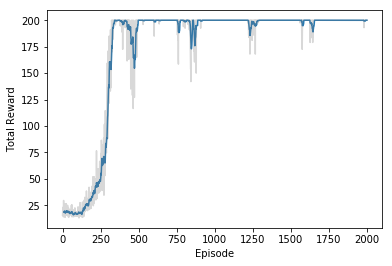

In [13]:
smoothed_rews = running_mean(median_rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(median_eps, median_rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')